In [1]:
#pip install ace_tools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%pip install scikit-surprise



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2463220 sha256=94cfb64b9a380f8dac9457e90345166d960f014e12c196a9a29b3c55a477b927
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [2]:
import torch
from sklearn.preprocessing import LabelEncoder

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Funciones para guardar y ver recomendaciones

In [5]:
import inspect

def guardar_preds_modelo(df, model, user_tensor, item_tensor, time_tensor,
                         name_columna, neighbor_users_list=None):
    """
    Guarda predicciones y valida que estén alineadas. Se adapta al tipo de modelo.
    """
    model.eval()

    with torch.no_grad():
        # Verificar qué argumentos acepta el forward del modelo
        sig = inspect.signature(model.forward)
        accepts_neighbors = "neighbor_users_list" in sig.parameters
        accepts_time = "time_ids" in sig.parameters

        kwargs = {}
        if accepts_neighbors and neighbor_users_list is not None:
            kwargs["neighbor_users_list"] = neighbor_users_list
        if accepts_time:
            kwargs["time_ids"] = time_tensor

        preds = model(user_tensor, item_tensor, **kwargs).cpu().numpy()

    df = df.copy()
    df[name_columna] = preds

    # Validación de alineación
    df_check = pd.DataFrame({
        "user_id": user_tensor.cpu().numpy(),
        "item_id": item_tensor.cpu().numpy(),
        "time_idx": time_tensor.cpu().numpy() if time_tensor is not None else df["time_idx"].values
    })

    # Comparación robusta que ignora diferencias de tipo y de índice
    valores_originales = df[["user_id", "item_id", "time_idx"]].values
    valores_check = df_check[["user_id", "item_id", "time_idx"]].values

    if not np.array_equal(valores_originales, valores_check):
        raise ValueError("⚠️ Las predicciones no están alineadas correctamente con el DataFrame.")


    print(f"✅ Predicciones guardadas como '{name_columna}'")
    return df

def agregar_predicciones(df_cv_base, df_test_base, nombre_columna, preds_cv, preds_test):
    """
    Agrega predicciones al DataFrame base (sin sobrescribir).

    Parámetros:
    - df_cv_base: DataFrame de entrenamiento (con columnas previas)
    - df_test_base: DataFrame de test (con columnas previas)
    - nombre_columna: nombre de la nueva columna (string)
    - preds_cv: array o tensor de predicciones para df_cv_base
    - preds_test: array o tensor de predicciones para df_test_base

    Retorna:
    - df_cv_base y df_test_base con la nueva columna agregada
    """
    import numpy as np
    import torch

    # Convertir a numpy si son tensores
    if isinstance(preds_cv, torch.Tensor):
        preds_cv = preds_cv.cpu().numpy()
    if isinstance(preds_test, torch.Tensor):
        preds_test = preds_test.cpu().numpy()

    # Asegurar longitud consistente
    assert len(preds_cv) == len(df_cv_base), "Longitud no coincide en train"
    assert len(preds_test) == len(df_test_base), "Longitud no coincide en test"

    df_cv_base[nombre_columna] = preds_cv
    df_test_base[nombre_columna] = preds_test

    print(f"✅ Columna '{nombre_columna}' agregada correctamente.")
    return df_cv_base, df_test_base


In [6]:
def recomendar_jugadores_a_equipo(
    equipo_id,                         # El ID del equipo (item_id)
    lista_jugadores,                   # Lista de IDs de jugadores (user_ids)
    modelo,                            # Modelo: .predict(user_id, item_id) o .predict(X) sklearn-style
    extra_features_df=None,            # (opcional) DataFrame con features extra de jugadores, indexado por user_id
    top_k=5,                          # Cuántos jugadores recomendar
    exclude_ids=None,                  # Lista de jugadores a excluir (ej: ya están en el equipo)
    features_base=None,                # Si usás blending/sklearn: lista de features a armar para predicción
    equipo_info=None                   # Si tu modelo necesita features del equipo (extra)
):
    """
    Devuelve DataFrame ordenado con los mejores jugadores predichos para el equipo.
    """

    # Filtrar jugadores excluidos
    candidatos = [j for j in lista_jugadores if exclude_ids is None or j not in exclude_ids]

    # Si tu modelo es tipo .predict(user_id, item_id)
    if hasattr(modelo, "__call__"):
        preds = [modelo(jugador, equipo_id) for jugador in candidatos]
    else:
        # Supongamos que es un modelo sklearn-style que recibe un DataFrame
        # Armamos el DataFrame para cada jugador
        X_pred = []
        for jugador in candidatos:
            row = {
                'user_id': jugador,
                'item_id': equipo_id
            }
            if extra_features_df is not None and jugador in extra_features_df.index:
                for col in extra_features_df.columns:
                    row[col] = extra_features_df.loc[jugador, col]
            # Si necesitas features del equipo:
            if equipo_info is not None and equipo_id in equipo_info.index:
                for col in equipo_info.columns:
                    row[col] = equipo_info.loc[equipo_id, col]
            X_pred.append(row)
        X_pred = pd.DataFrame(X_pred)
        # Si usás blending: seleccioná solo las columnas de features usados
        if features_base is not None:
            X_pred = X_pred[features_base]
        preds = modelo.predict(X_pred)

    # DataFrame ordenado
    df_result = pd.DataFrame({
        'jugador_id': candidatos,
        'predicted_rating': preds
    }).sort_values("predicted_rating", ascending=False)

    return df_result.head(top_k)


In [7]:
def recomendar_jugadores_equipo_nombre(
    nombre_equipo,
    año,                        # <-- ahora pasa el año real, no el índice temporal
    jugadores_filtrados,        # DataFrame con ['Nombre', 'ID Jugador', 'Equipo']
    modelo,
    user_encoder, item_encoder,
    df_cv,                      # <-- necesitás esto para el mapping de años
    top_k=10
):
    # ---- Buscar equipo por nombre y filtrar ----
    if nombre_equipo not in jugadores_filtrados['Equipo'].unique():
        raise ValueError(f"Equipo '{nombre_equipo}' no encontrado en jugadores_filtrados")
    equipo_id = nombre_equipo

    if equipo_id not in item_encoder.classes_:
        print(f"Equipo '{equipo_id}' no conocido por el modelo. No se puede recomendar.")
        return pd.DataFrame()

    equipo_id_idx = item_encoder.transform([equipo_id])[0]

    # --- Codificar año (mapping robusto usando las categorías del modelo) ---
    time_categories = df_cv["Año_Orden"].astype("category").cat.categories
    if año not in time_categories.values:
        print(f"Año {año} no está en las categorías del modelo.")
        return pd.DataFrame()
    time_idx = pd.Categorical([año], categories=time_categories).codes[0]

    jugadores_df = jugadores_filtrados[['Nombre', 'ID Jugador']].drop_duplicates('ID Jugador')
    nombres = jugadores_df['Nombre'].tolist()
    ids_jugadores = jugadores_df['ID Jugador'].tolist()

    # Filtrar solo jugadores conocidos por el modelo
    ids_jugadores_validos = [jid for jid in ids_jugadores if jid in user_encoder.classes_]
    nombres_validos = [nombres[i] for i, jid in enumerate(ids_jugadores) if jid in user_encoder.classes_]

    if len(ids_jugadores_validos) == 0:
        print("No hay jugadores conocidos por el modelo para recomendar.")
        return pd.DataFrame()

    usuarios_idx = user_encoder.transform(ids_jugadores_validos)

    import torch
    user_tensor = torch.tensor(usuarios_idx, dtype=torch.long)
    item_tensor = torch.tensor([equipo_id_idx] * len(usuarios_idx), dtype=torch.long)
    time_tensor = torch.tensor([time_idx] * len(usuarios_idx), dtype=torch.long)

    # --- Detectar si el modelo requiere neighbor_users_list ---
    import inspect
    forward_args = inspect.signature(modelo.forward).parameters
    with torch.no_grad():
        if "neighbor_users_list" in forward_args:
            neighbor_users_list = [[] for _ in range(len(user_tensor))]
            preds = modelo(user_tensor, item_tensor, time_tensor, neighbor_users_list, use_dot=True).cpu().numpy()
        else:
            preds = modelo(user_tensor, item_tensor, time_tensor, use_dot=True).cpu().numpy()

    result = pd.DataFrame({
        'Nombre': nombres_validos,
        'ID Jugador': ids_jugadores_validos,
        'predicted_rating': preds
    }).sort_values('predicted_rating', ascending=False).reset_index(drop=True)

    return result.head(top_k)


## Analisis dataset besoccer

In [8]:
file_path = "/content/drive/My Drive/TESIS/historical_season_stats_player.csv"

# Cargar el dataset
jugadores_compacto_bs = pd.read_csv(file_path)

# Confirmar que se cargó correctamente
print(jugadores_compacto_bs.head())

         Club     Temp  PJ  Goles  Asistencias  PT  PS     MIN Edad  Pts.  \
0  Alianza FC  2024/25   3      0            1   3   0   250.0   25   6.1   
1  Alianza FC  2023/24  44      0            2  44   0  3789.0   24   6.3   
2  Alianza FC  2022/23  44      2            1  43   1  3848.0   23   6.9   
3  Alianza FC  2021/22  22      0            0  22   0  1963.0   22   6.4   
4     Espinho  2020/21   1      0            0   0   1    33.0   21   4.1   

   ELO id_jugador_besoccer     jugador      equipo  
0   70              429313  E. NAVARRO  ALIANZA FC  
1   71              429313  E. NAVARRO  ALIANZA FC  
2   67              429313  E. NAVARRO  ALIANZA FC  
3   53              429313  E. NAVARRO  ALIANZA FC  
4   41              429313  E. NAVARRO  ALIANZA FC  


In [9]:
jugadores_antes_ = jugadores_compacto_bs["id_jugador_besoccer"].nunique()
equipos_antes_ = jugadores_compacto_bs["Club"].nunique()

print(f"Jugadores antes de filtrar: {jugadores_antes_}")
print(f"Equipos antes de filtrar: {equipos_antes_}")

Jugadores antes de filtrar: 16356
Equipos antes de filtrar: 6973


Cantidad de equipos: 6973
Cantidad de jugadores únicos: 16356


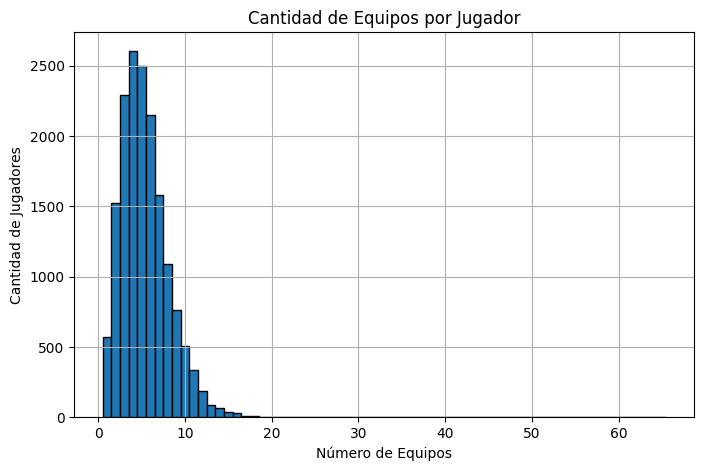

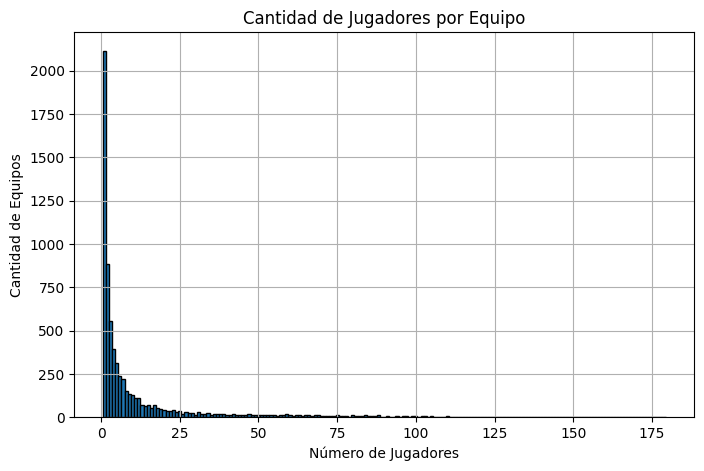

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = jugadores_compacto_bs
# Suponiendo que ya tenés cargado tu DataFrame como `df`
# df = pd.read_csv('tu_archivo.csv')  # si es que lo tenés que cargar

# Estadísticas básicas
cantidad_equipos = df['Club'].nunique()
cantidad_jugadores_unicos = df['id_jugador_besoccer'].nunique()

print("Cantidad de equipos:", cantidad_equipos)
print("Cantidad de jugadores únicos:", cantidad_jugadores_unicos)

# Equipos por jugador
equipos_por_jugador = df.groupby('id_jugador_besoccer')['Club'].nunique()

# Jugadores por equipo
jugadores_por_equipo = df.groupby('Club')['id_jugador_besoccer'].nunique()

# Histograma: cantidad de equipos por jugador
plt.figure(figsize=(8, 5))
plt.hist(equipos_por_jugador, bins=range(1, equipos_por_jugador.max() + 2), edgecolor='black', align='left')
plt.title('Cantidad de Equipos por Jugador')
plt.xlabel('Número de Equipos')
plt.ylabel('Cantidad de Jugadores')
plt.grid(True)
plt.show()

# Histograma: cantidad de jugadores por equipo
plt.figure(figsize=(8, 5))
plt.hist(jugadores_por_equipo, bins=range(1, jugadores_por_equipo.max() + 2), edgecolor='black', align='left')
plt.title('Cantidad de Jugadores por Equipo')
plt.xlabel('Número de Jugadores')
plt.ylabel('Cantidad de Equipos')
plt.grid(True)
plt.show()




In [11]:
display(df)

Club     Temp  PJ  Goles  Asistencias  PT  PS  \
0                  Alianza FC  2024/25   3      0            1   3   0   
1                  Alianza FC  2023/24  44      0            2  44   0   
2                  Alianza FC  2022/23  44      2            1  43   1   
3                  Alianza FC  2021/22  22      0            0  22   0   
4                     Espinho  2020/21   1      0            0   0   1   
...                       ...      ...  ..    ...          ...  ..  ..   
180900             Vizela U23  2024/25  26      9            5  25   1   
180901             Vizela U23  2023/24   1      0            0   1   0   
180902  Vitória Guimarães U19  2022/23  34      4            0  21  13   
180903  Vitória Guimarães U17  2021/22  17      7            0  11   6   
180904  Vitória Guimarães U15  2019/20   1      0            0   1   0   

           MIN Edad  Pts.  ELO id_jugador_besoccer     jugador      equipo  
0        250.0   25   6.1   70              429313  E. NAVARRO  ALIANZA FC  
1       3789.0   24   6.3   71              429313  E. NAVARRO  ALIANZA FC  
2       3848.0   23   6.9   67              429313  E. NAVARRO  ALIANZA FC  
3       1963.0   22   6.4   53              429313  E. NAVARRO  ALIANZA FC  
4         33.0   21   4.1   41              429313  E. NAVARRO  ALIANZA FC  
...        ...  ...   ...  ...                 ...         ...         ...  
180900  2084.0   19   7.6   47              937476    P. RAMOS      VIZELA  
180901    38.0   18   5.2   39              937476    P. RAMOS      VIZELA  
180902  2056.0   17   6.0   42              937476    P. RAMOS      VIZELA  
180903  1189.0   16   6.6   38              937476    P. RAMOS      VIZELA  
180904    90.0   14   4.5   27              937476    P. RAMOS      VIZELA  

[180905 rows x 14 columns]

In [12]:
import pandas as pd

# Copia del DataFrame original
jugadores_compacto = df.copy()

# Renombrar columnas para estandarizar
jugadores_compacto.rename(columns={
    "Temp": "Año",
    "MIN": "Minutos Jugados",
    "Pts.": "Rating",
    "PJ": "Partidos Jugados",
    "id_jugador_besoccer": "ID Jugador",
    "jugador": "Nombre",
    "Club": "Equipo"
}, inplace=True)

# Eliminar filas sin valor en "Año"
jugadores_compacto = jugadores_compacto.dropna(subset=["Año"])

# Función para extraer año final de temporadas tipo "2021/22"
def extraer_anio_final(temporada):
    try:
        if "/" in temporada:
            return int(temporada.split("/")[1])
        elif temporada.isdigit():
            return int(temporada)
    except:
        return None

# Aplicar la extracción de año
jugadores_compacto["Año_Orden"] = jugadores_compacto["Año"].apply(extraer_anio_final)
jugadores_compacto = jugadores_compacto.dropna(subset=["Año_Orden"])
jugadores_compacto["Año_Orden"] = jugadores_compacto["Año_Orden"].astype(int)

# Calcular minutos por partido
jugadores_compacto["Minutos Por Partido"] = jugadores_compacto["Minutos Jugados"] / jugadores_compacto["Partidos Jugados"]

# Definir columnas clave y de agregación
columnas_clave = ["ID Jugador", "Equipo"]
columnas_sumar = ["Asistencias", "Goles", "Partidos Jugados", "Minutos Jugados"]
columnas_promediar = ["Rating", "Minutos Por Partido"]

# Agrupación por jugador
jugadores_agrupados = jugadores_compacto.groupby(columnas_clave, as_index=False).agg(
    {
        **{col: "sum" for col in columnas_sumar},
        **{col: "mean" for col in columnas_promediar},
        "Año_Orden": "max",
        "Nombre": "first"
    }
)

# Reconstruir columna de temporada
def reconstruir_temporada(anio):
    return f"{(anio - 1)}/{anio}"

jugadores_agrupados["Año"] = jugadores_agrupados["Año_Orden"].apply(reconstruir_temporada)
jugadores_agrupados.drop(columns=["Año_Orden"], inplace=True)

# Filtrar jugadores con al menos 400 minutos y rating > 0
jugadores_filtrados = jugadores_agrupados[
    (jugadores_agrupados["Minutos Jugados"] >= 400) &
    (jugadores_agrupados["Rating"] > 0)
]

# Mostrar resultado
display(jugadores_filtrados)


ID Jugador                  Equipo  Asistencias  Goles  \
0        1000257  C.D. San Marcelino 'A'            0      3   
3        1000257               CF Gandia            0      8   
4        1000257          Júpiter Leonés            0      6   
6        1000284             CD Roda U19            0      8   
7        1000284            Villarreal B            1      3   
...          ...                     ...          ...    ...   
87638     zawada           Wolfsburg U17            0     19   
87639     zawada           Wolfsburg U19            1     36   
87640       zigi               Liefering            0     59   
87642       zigi                 Sochaux            0     46   
87644       zigi              St. Gallen            1    312   

       Partidos Jugados  Minutos Jugados    Rating  Minutos Por Partido  \
0                    24           1406.0  5.900000            58.583333   
3                    33           1412.0  5.500000            36.000000   
4                    36           2313.0  6.300000            64.250000   
6                    21           1644.0  7.200000            78.285714   
7                    33           1431.0  5.050000            34.881944   
...                 ...              ...       ...                  ...   
87638                25           2159.0  7.700000            86.360000   
87639                46           3042.0  6.500000            57.576584   
87640                33           2970.0  5.800000            90.000000   
87642                33           2881.0  5.866667            87.240741   
87644               211          18895.0  6.650000            89.542298   

              Nombre    Año  
0           P. MARCO  20/21  
3           P. MARCO  22/23  
4           P. MARCO  23/24  
6      VÍCTOR MORENO  21/22  
7      VÍCTOR MORENO  24/25  
...              ...    ...  
87638   OSKAR ZAWADA  12/13  
87639   OSKAR ZAWADA  14/15  
87640    L. ATI ZIGI  16/17  
87642    L. ATI ZIGI  19/20  
87644    L. ATI ZIGI  24/25  

[65137 rows x 10 columns]

In [13]:
# Filtrar jugadores con al menos 400 minutos jugados y Pts. mayor a 0
jugadores_filtrados = jugadores_filtrados[jugadores_filtrados["Minutos Jugados"] >= 400]
jugadores_filtrados = jugadores_filtrados[jugadores_filtrados["Rating"] > 0]

# Mostrar el resultado
display(jugadores_filtrados)

ID Jugador                  Equipo  Asistencias  Goles  \
0        1000257  C.D. San Marcelino 'A'            0      3   
3        1000257               CF Gandia            0      8   
4        1000257          Júpiter Leonés            0      6   
6        1000284             CD Roda U19            0      8   
7        1000284            Villarreal B            1      3   
...          ...                     ...          ...    ...   
87638     zawada           Wolfsburg U17            0     19   
87639     zawada           Wolfsburg U19            1     36   
87640       zigi               Liefering            0     59   
87642       zigi                 Sochaux            0     46   
87644       zigi              St. Gallen            1    312   

       Partidos Jugados  Minutos Jugados    Rating  Minutos Por Partido  \
0                    24           1406.0  5.900000            58.583333   
3                    33           1412.0  5.500000            36.000000   
4                    36           2313.0  6.300000            64.250000   
6                    21           1644.0  7.200000            78.285714   
7                    33           1431.0  5.050000            34.881944   
...                 ...              ...       ...                  ...   
87638                25           2159.0  7.700000            86.360000   
87639                46           3042.0  6.500000            57.576584   
87640                33           2970.0  5.800000            90.000000   
87642                33           2881.0  5.866667            87.240741   
87644               211          18895.0  6.650000            89.542298   

              Nombre    Año  
0           P. MARCO  20/21  
3           P. MARCO  22/23  
4           P. MARCO  23/24  
6      VÍCTOR MORENO  21/22  
7      VÍCTOR MORENO  24/25  
...              ...    ...  
87638   OSKAR ZAWADA  12/13  
87639   OSKAR ZAWADA  14/15  
87640    L. ATI ZIGI  16/17  
87642    L. ATI ZIGI  19/20  
87644    L. ATI ZIGI  24/25  

[65137 rows x 10 columns]

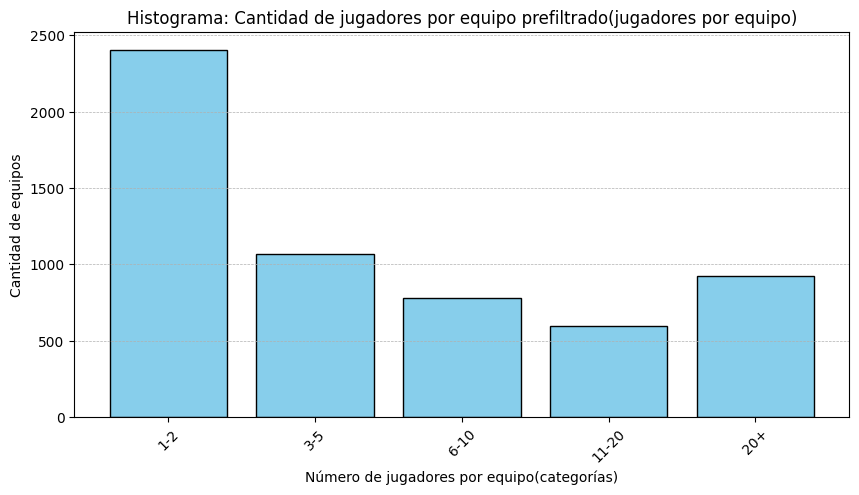

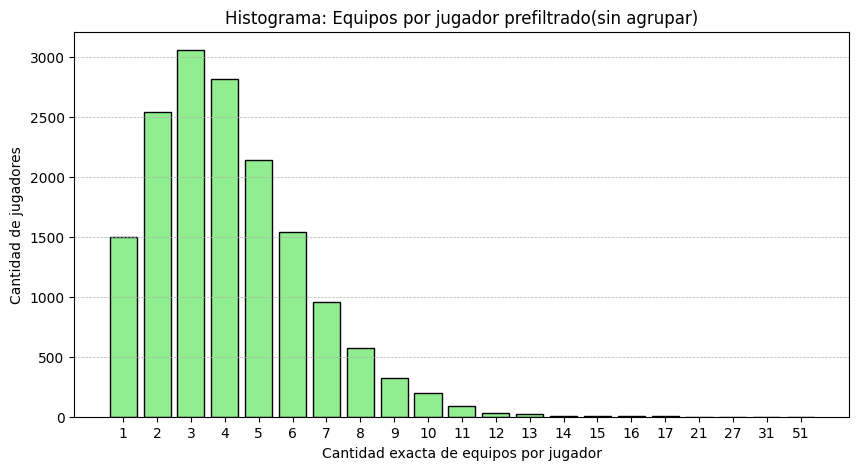

In [14]:
# Mostrar resultados de antes y después


# 4. Histograma: jugadores por equipo (agrupado)
jugadores_por_equipo = jugadores_filtrados.groupby("Equipo")["ID Jugador"].nunique()
bins = [1, 3, 6, 11, 21, jugadores_por_equipo.max() + 1]
labels = ["1-2", "3-5", "6-10", "11-20", "20+"]
jugadores_por_equipo_binned = pd.cut(jugadores_por_equipo, bins=bins, labels=labels, include_lowest=True, right=False)
conteo_equipo = jugadores_por_equipo_binned.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(conteo_equipo.index.astype(str), conteo_equipo.values, color='skyblue', edgecolor='black')
plt.xlabel("Número de jugadores por equipo(categorías)")
plt.ylabel("Cantidad de equipos")
plt.title("Histograma: Cantidad de jugadores por equipo prefiltrado(jugadores por equipo)")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.show()

# Recuento exacto de equipos por jugador
equipos_por_jugador = jugadores_filtrados.groupby("ID Jugador")["Equipo"].nunique()
conteo_exacto = equipos_por_jugador.value_counts().sort_index()

# Graficar
plt.figure(figsize=(10, 5))
plt.bar(conteo_exacto.index.astype(str), conteo_exacto.values, color='lightgreen', edgecolor='black')
plt.xlabel("Cantidad exacta de equipos por jugador")
plt.ylabel("Cantidad de jugadores")
plt.title("Histograma: Equipos por jugador prefiltrado(sin agrupar)")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=0)
plt.show()

In [15]:
# Contar cuántos equipos distintos tuvo cada jugador
equipos_por_jugador = jugadores_filtrados.groupby("ID Jugador")["Equipo"].nunique()

# Quedarse solo con los jugadores que hayan jugado en más de 2 clubes
jugadores_validos = equipos_por_jugador[equipos_por_jugador > 4].index

# Filtrar el DataFrame original
jugadores_filtrados_bs = jugadores_filtrados[jugadores_filtrados["ID Jugador"].isin(jugadores_validos)]
jugadores_filtrados = jugadores_filtrados_bs

In [16]:
duplicados = jugadores_filtrados.duplicated(subset=["ID Jugador", "Equipo"], keep=False)

# Mostrar solo los duplicados encontrados
jugadores_repetidos = jugadores_filtrados[duplicados]

# Ver los casos únicos
jugadores_repetidos_unicos = jugadores_repetidos[["ID Jugador", "Equipo"]].drop_duplicates()

print(jugadores_repetidos_unicos)


Empty DataFrame
Columns: [ID Jugador, Equipo]
Index: []


In [17]:
# Contar jugadores únicos en Racing
num_jugadores_racing = jugadores_filtrados[jugadores_filtrados["Equipo"] == "Sevilla"]["ID Jugador"].nunique()
print(f"Cantidad de jugadores en Racing: {num_jugadores_racing}")


Cantidad de jugadores en Racing: 71


## Me quedo con los equipos de Europa

In [ ]:
import pandas as pd

# Suponiendo que el archivo está en tu Google Drive en la misma carpeta
equipos_europa = pd.read_excel("/content/drive/MyDrive/TESIS/equipos_europa.xlsx")

# Asegurate de que las columnas necesarias están
print(equipos_europa.columns)


Index(['Equipo', 'Liga', 'Pais'], dtype='object')


In [ ]:
# Filtrar los jugadores cuyo equipo esté en la lista de equipos de Europa
jugadores_europa = jugadores_filtrados[jugadores_filtrados["Equipo"].isin(equipos_europa["Equipo"])]
jugadores_europa = jugadores_europa.merge(
    equipos_europa[["Equipo", "Liga", "Pais"]],
    on="Equipo",
    how="left"
)
#jugadores_filtrados = jugadores_europa

## Subset de mayor densidad de jugadores por equipo

In [ ]:
import pandas as pd

# Suponiendo que jugadores_filtrados ya está cargado

# 1. Contar cantidad de jugadores por equipo
equipos_top = (
    jugadores_filtrados.groupby("Equipo")["ID Jugador"]
    .nunique()
    .sort_values(ascending=False)
    .head(100) #PARA EL DE SOFA SCORE
    #.head(400) #PARA EL DE SOFA SCORE
    .index
)

# 2. Contar cantidad de equipos (o filas) por jugador
jugadores_top = (
    jugadores_filtrados.groupby("ID Jugador")["Equipo"]
    .nunique()
    .sort_values(ascending=False)
    .head(1000) #PARA EL DE BE SOCCER
    #.head(3500) #PARA EL DE SOFA SCORE
    .index
)

# 3. Filtrar el dataset quedándote con la intersección
jugadores_filtrados_interseccion = jugadores_filtrados[
    (jugadores_filtrados["Equipo"].isin(equipos_top)) &
    (jugadores_filtrados["ID Jugador"].isin(jugadores_top))
]

# 4. Mostrar resumen final
print(f"➡️ Total de filas luego de filtrar: {len(jugadores_filtrados_interseccion)}")


➡️ Total de filas luego de filtrar: 526


In [ ]:
jugadores_filtrados = jugadores_filtrados_interseccion

In [ ]:
# Contar cuántos equipos distintos tuvo cada jugador
equipos_por_jugador = jugadores_filtrados.groupby("ID Jugador")["Equipo"].nunique()

# Quedarse solo con los jugadores que hayan jugado en más de 2 clubes
jugadores_validos = equipos_por_jugador[equipos_por_jugador > 2].index

# Filtrar el DataFrame original
jugadores_filtrados_bs = jugadores_filtrados[jugadores_filtrados["ID Jugador"].isin(jugadores_validos)]
jugadores_filtrados = jugadores_filtrados_bs


# Estadisticas y filtrado

## Calculo estadisticas

In [18]:
# Calcular cuántos equipos ha tenido cada jugador
equipos_por_jugador = jugadores_filtrados.groupby("ID Jugador")["Equipo"].nunique()

# Calcular estadísticas de equipos por jugador
promedio_equipos = equipos_por_jugador.mean()
desvio_equipos = equipos_por_jugador.std()

# Calcular estadísticas de rating
promedio_rating = jugadores_filtrados["Rating"].mean()
desvio_rating = jugadores_filtrados["Rating"].std()

# Calcular minutos promedio por jugador
minutos_promedio_jugador = jugadores_filtrados.groupby("ID Jugador")["Minutos Jugados"].sum().mean()
desvio_minutos_jugador = jugadores_filtrados.groupby("ID Jugador")["Minutos Jugados"].sum().std()

# Mostrar resultados
print("📊 Estadísticas Calculadas:")
print(f"✅ Promedio de equipos por jugador: {promedio_equipos:.2f}")
print(f"✅ Desvío estándar de equipos por jugador: {desvio_equipos:.2f}")
print(f"✅ Rating promedio de los jugadores: {promedio_rating:.2f}")
print(f"✅ Desvío estándar del rating: {desvio_rating:.2f}")
print(f"✅ Minutos promedio jugados por jugador: {minutos_promedio_jugador:.2f}")
print(f"✅ Desvío estándar de minutos jugados por jugador: {desvio_minutos_jugador:.2f}")

📊 Estadísticas Calculadas:
✅ Promedio de equipos por jugador: 6.48
✅ Desvío estándar de equipos por jugador: 1.84
✅ Rating promedio de los jugadores: 6.05
✅ Desvío estándar del rating: 0.86
✅ Minutos promedio jugados por jugador: 20950.20
✅ Desvío estándar de minutos jugados por jugador: 10826.86


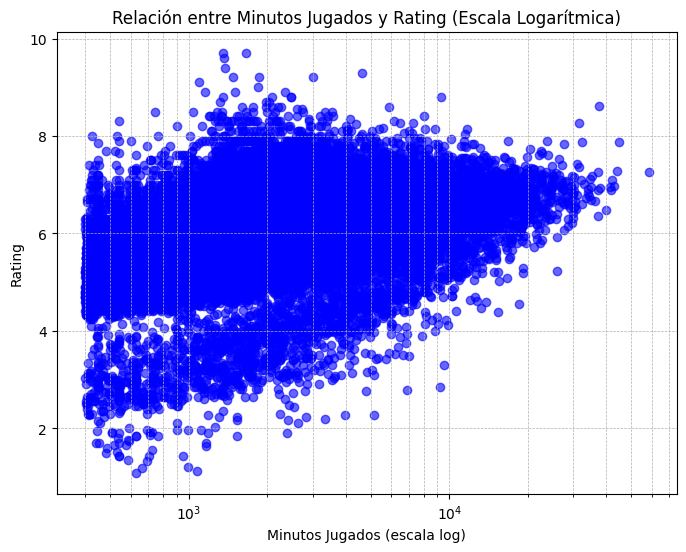

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(jugadores_filtrados["Minutos Jugados"], jugadores_filtrados["Rating"], alpha=0.6, color='blue')

# Configurar escala logarítmica en el eje X
plt.xscale("log")

# Etiquetas y título
plt.xlabel("Minutos Jugados (escala log)")
plt.ylabel("Rating")
plt.title("Relación entre Minutos Jugados y Rating (Escala Logarítmica)")

# Mostrar el gráfico
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

<ipython-input-20-5446da99e7f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jugadores_filtrados["Bin"] = pd.cut(jugadores_filtrados["Minutos Jugados"], bins, labels=False)


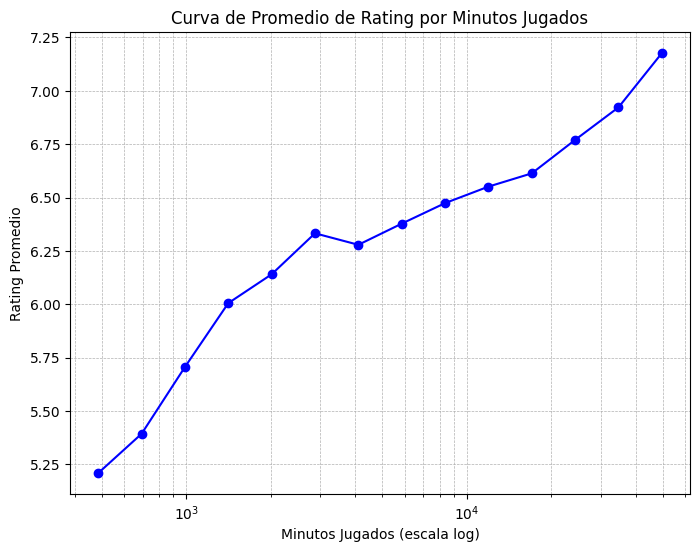

In [20]:
import numpy as np
bins = np.logspace(np.log10(jugadores_filtrados["Minutos Jugados"].min()),
                   np.log10(jugadores_filtrados["Minutos Jugados"].max()), num=15)
# Asignar cada jugador a un bin de minutos jugados
jugadores_filtrados["Bin"] = pd.cut(jugadores_filtrados["Minutos Jugados"], bins, labels=False)

# Calcular el promedio de rating para cada bin
rating_promedio_por_bin = jugadores_filtrados.groupby("Bin")["Rating"].mean()

# Obtener el centro de cada bin para graficar
bin_centros = [bins[i] + (bins[i+1] - bins[i])/2 for i in range(len(bins)-1)]

# Graficar la curva
plt.figure(figsize=(8, 6))
plt.plot(bin_centros[:len(rating_promedio_por_bin)], rating_promedio_por_bin, marker='o', linestyle='-', color='blue')

# Configurar escala logarítmica en el eje X
plt.xscale("log")

# Etiquetas y título
plt.xlabel("Minutos Jugados (escala log)")
plt.ylabel("Rating Promedio")
plt.title("Curva de Promedio de Rating por Minutos Jugados")

# Mostrar el gráfico
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

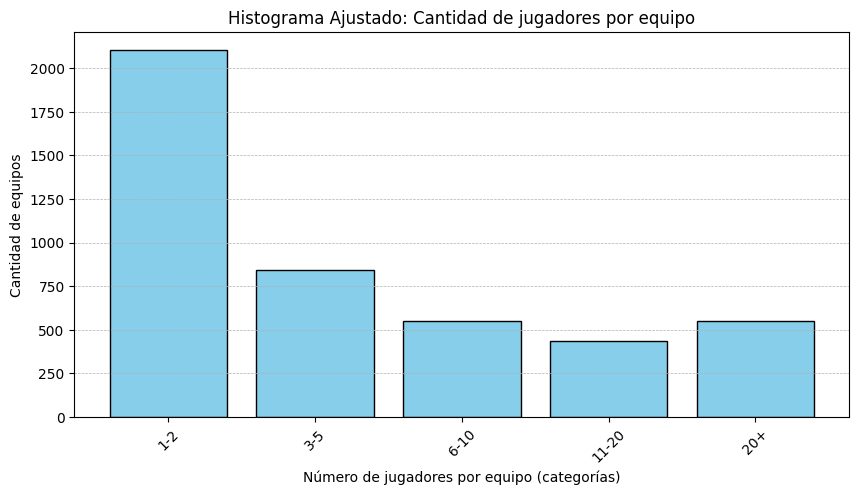

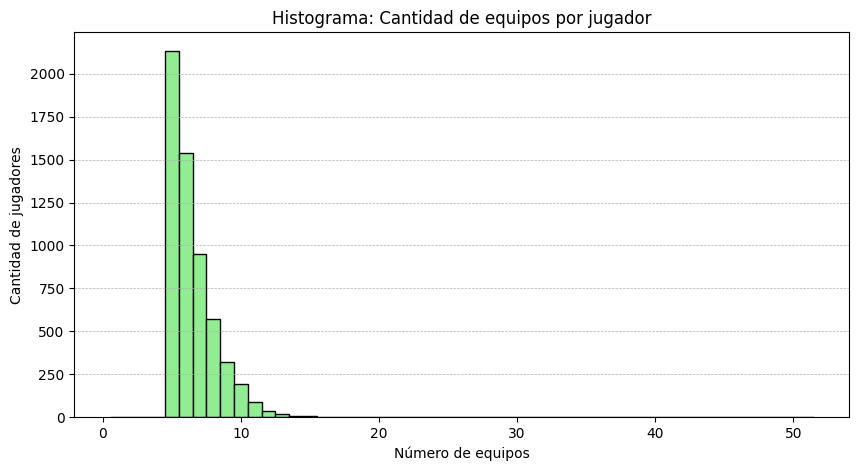

In [21]:
# Agrupar jugadores por equipo
jugadores_por_equipo = jugadores_filtrados.groupby("Equipo")["ID Jugador"].nunique()

# Definir los bins y etiquetas para las categorías personalizadas
bins = [1, 3, 6, 11, 21, jugadores_por_equipo.max() + 1]  # +1 para incluir el máximo valor
labels = ["1-2", "3-5", "6-10", "11-20", "20+"]

# Crear una nueva columna con los bins
jugadores_por_equipo_binned = pd.cut(jugadores_por_equipo, bins=bins, labels=labels, include_lowest=True, right=False)

# Contar la frecuencia de cada bin
conteo_bins = jugadores_por_equipo_binned.value_counts().sort_index()

# Graficar el histograma ajustado con las nuevas categorías
plt.figure(figsize=(10, 5))
plt.bar(conteo_bins.index.astype(str), conteo_bins.values, color='skyblue', edgecolor='black')

# Etiquetas y título
plt.xlabel("Número de jugadores por equipo (categorías)")
plt.ylabel("Cantidad de equipos")
plt.title("Histograma Ajustado: Cantidad de jugadores por equipo")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)

# Mostrar el gráfico
plt.show()

# -----------------------------------------
# Histograma 2: Cantidad de equipos por jugador
# -----------------------------------------
equipos_por_jugador = jugadores_filtrados.groupby("ID Jugador")["Equipo"].nunique()

plt.figure(figsize=(10, 5))
plt.hist(equipos_por_jugador, bins=range(1, equipos_por_jugador.max() + 2), align='left', color='lightgreen', edgecolor='black')
plt.title("Histograma: Cantidad de equipos por jugador")
plt.xlabel("Número de equipos")
plt.ylabel("Cantidad de jugadores")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

Jugadores antes de filtrar: 5885
Equipos antes de filtrar: 4480
Jugadores después de filtrar: 5872
Equipos después de filtrar: 1741


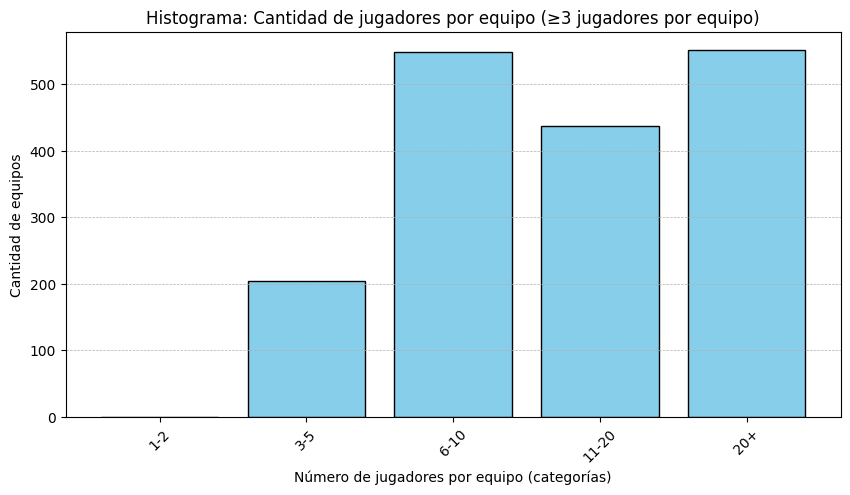

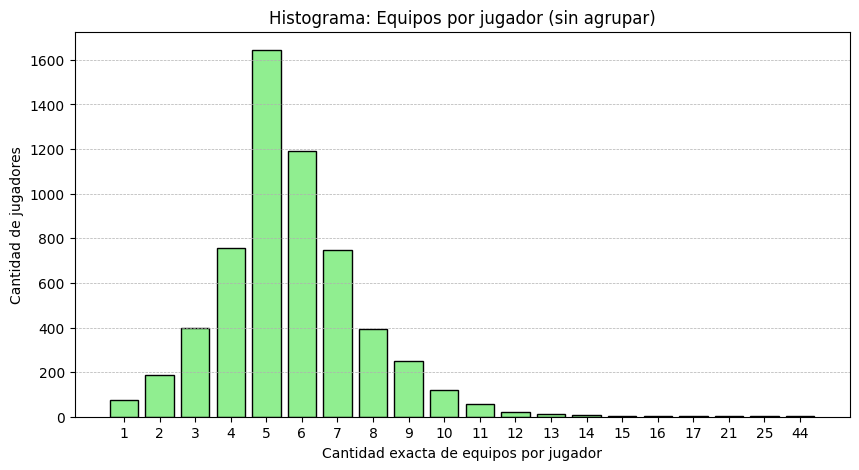

In [22]:
jugadores = jugadores_filtrados

# Obtener el número de jugadores y equipos antes de hacer cualquier filtro
jugadores_antes = jugadores["ID Jugador"].nunique()
equipos_antes = jugadores["Equipo"].nunique()

# 2. Colapsar datos por jugador y equipo (sumar y promediar lo que corresponde)
columnas_clave = ["ID Jugador", "Nombre", "Equipo"]
columnas_sumar = ["Asistencias", "Goles", "Partidos Jugados", "Minutos Jugados"]
columnas_promediar = ["Rating", "Minutos Por Partido"]

jugadores_agrupados = jugadores

# Filtrar equipos con al menos 3 jugadores
jugadores_por_equipo = jugadores_agrupados.groupby("Equipo")["ID Jugador"].nunique()
equipos_validos = jugadores_por_equipo[jugadores_por_equipo >= 5].index
jugadores_filtrados = jugadores_agrupados[jugadores_agrupados["Equipo"].isin(equipos_validos)]

# Obtener el número de jugadores y equipos después de hacer los filtros
jugadores_despues = jugadores_filtrados["ID Jugador"].nunique()
equipos_despues = jugadores_filtrados["Equipo"].nunique()

# Mostrar resultados de antes y después
print(f"Jugadores antes de filtrar: {jugadores_antes}")
print(f"Equipos antes de filtrar: {equipos_antes}")
print(f"Jugadores después de filtrar: {jugadores_despues}")
print(f"Equipos después de filtrar: {equipos_despues}")

# 4. Histograma: jugadores por equipo (agrupado)
jugadores_por_equipo = jugadores_filtrados.groupby("Equipo")["ID Jugador"].nunique()
bins = [1, 3, 6, 11, 21, jugadores_por_equipo.max() + 1]
labels = ["1-2", "3-5", "6-10", "11-20", "20+"]
jugadores_por_equipo_binned = pd.cut(jugadores_por_equipo, bins=bins, labels=labels, include_lowest=True, right=False)
conteo_equipo = jugadores_por_equipo_binned.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(conteo_equipo.index.astype(str), conteo_equipo.values, color='skyblue', edgecolor='black')
plt.xlabel("Número de jugadores por equipo (categorías)")
plt.ylabel("Cantidad de equipos")
plt.title("Histograma: Cantidad de jugadores por equipo (≥3 jugadores por equipo)")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.show()

# Recuento exacto de equipos por jugador
equipos_por_jugador = jugadores_filtrados.groupby("ID Jugador")["Equipo"].nunique()
conteo_exacto = equipos_por_jugador.value_counts().sort_index()

# Graficar
plt.figure(figsize=(10, 5))
plt.bar(conteo_exacto.index.astype(str), conteo_exacto.values, color='lightgreen', edgecolor='black')
plt.xlabel("Cantidad exacta de equipos por jugador")
plt.ylabel("Cantidad de jugadores")
plt.title("Histograma: Equipos por jugador (sin agrupar)")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=0)
plt.show()

In [23]:
print(jugadores_filtrados.head())
print(len(jugadores_filtrados))

   ID Jugador           Equipo  Asistencias  Goles  Partidos Jugados  \
16    1000294  Real Unión Club            0      1                28   
18    1000294     Villarreal B            1      0                64   
19    1000294     Villarreal C            0      0                 9   
20    1000294   Villarreal U19            0      0                37   
54    1000525        Barakaldo            0      1                28   

    Minutos Jugados  Rating  Minutos Por Partido          Nombre    Año  Bin  
16           1881.0    6.40            67.178571    A. ESPIGARES  22/23  4.0  
18           5214.0    6.35            81.288368    A. ESPIGARES  24/25  7.0  
19            729.0    6.10            81.000000    A. ESPIGARES  21/22  1.0  
20           3227.0    6.40            84.277778    A. ESPIGARES  21/22  5.0  
54            880.0    5.00            31.428571  JESÚS MARTÍNEZ  24/25  2.0  
33220


## Me fijo la componente conexa más grande para probar ahí


In [ ]:
import networkx as nx
import pandas as pd
from collections import Counter

# Crear una lista de pares (jugador, equipo)
pares_jugador_equipo = jugadores_filtrados[["ID Jugador", "Equipo"]].dropna()

# Agrupar por jugador y generar todas las combinaciones de equipos que compartió
G = nx.Graph()

for jugador, grupo in pares_jugador_equipo.groupby("ID Jugador"):
    equipos = grupo["Equipo"].unique()
    for i in range(len(equipos)):
        for j in range(i + 1, len(equipos)):
            G.add_edge(equipos[i], equipos[j])

# Obtener componentes conexas
componentes = list(nx.connected_components(G))

# Calcular tamaño de cada componente
tamanios = [len(componente) for componente in componentes]

# Mostrar cantidad de equipos por cluster
conteo = Counter(tamanios)
print("📊 Cantidad de equipos en cada cluster (según tamaño del cluster):")
for tam, cantidad in sorted(conteo.items()):
    print(f"Clusters de tamaño {tam}: {cantidad}")


📊 Cantidad de equipos en cada cluster (según tamaño del cluster):
Clusters de tamaño 3151: 1


In [ ]:
# Filtrar componentes de tamaño 2
clusters_tam_2 = [comp for comp in componentes if len(comp) == 2]

# Mostrar los equipos de esos clusters
for i, cluster in enumerate(clusters_tam_2, start=1):
    equipos = list(cluster)
    print(f"Cluster {i}: {equipos[0]} - {equipos[1]}")


In [ ]:
# Obtener todos los equipos que pertenecen a clusters de tamaño 2
equipos_a_eliminar = set()
for cluster in clusters_tam_2:
    equipos_a_eliminar.update(cluster)

print(f"🧹 Filtrado realizado. Registros originales: {len(jugadores_filtrados)}")

# Filtrar jugadores_filtrados quitando esos equipos
jugadores_filtrados = jugadores_filtrados[~jugadores_filtrados["Equipo"].isin(equipos_a_eliminar)].copy()

# Mostrar resultado
print(f"📉 Registros luego de eliminar equipos de clusters de tamaño 2: {len(jugadores_filtrados)}")


🧹 Filtrado realizado. Registros originales: 55506
📉 Registros luego de eliminar equipos de clusters de tamaño 2: 55506


In [ ]:
import networkx as nx
import pandas as pd

# 1. Crear grafo
G = nx.Graph()

# Agregar aristas: un jugador conecta todos los equipos en los que jugó
for jugador, grupos in jugadores_filtrados.groupby("ID Jugador"):
    equipos = grupos["Equipo"].unique()
    for i in range(len(equipos)):
        for j in range(i + 1, len(equipos)):
            G.add_edge(equipos[i], equipos[j])

# 2. Detectar y remover los puentes (aristas únicas que conectan subcomponentes)
bridges = list(nx.bridges(G))
G.remove_edges_from(bridges)

# 3. Calcular nuevas componentes conexas
componentes = list(nx.connected_components(G))

# 4. Mostrar tamaños
tamaños = [len(c) for c in componentes]
conteo = pd.Series(tamaños).value_counts().sort_index()

print("📊 Componentes luego de remover puentes:")
for tam, cant in conteo.items():
    print(f"{cant} componente(s) de tamaño {tam}")


📊 Componentes luego de remover puentes:
1 componente(s) de tamaño 1
1 componente(s) de tamaño 3150


In [ ]:
# 5. Componentes pequeñas (menos de 5 nodos/equipos)
componentes_pequeñas = [c for c in componentes if len(c) < 5]

# 6. Equipos a eliminar
equipos_a_eliminar = sorted(set().union(*componentes_pequeñas))

# 7. Mostrar equipos
print("\n🚫 Equipos en componentes pequeñas (tamaño < 5):")
for equipo in equipos_a_eliminar:
    print(f"- {equipo}")

# 8. Filtrar el dataframe
jugadores_filtrados_filtrado = jugadores_filtrados[~jugadores_filtrados["Equipo"].isin(equipos_a_eliminar)].copy()

# 9. Confirmar resumen
print(f"\n✅ Jugadores restantes luego del filtrado: {len(jugadores_filtrados_filtrado)}")
print(f"🧹 Equipos eliminados: {len(equipos_a_eliminar)}")

# 10. Contar filas eliminadas
filas_eliminadas = len(jugadores_filtrados) - len(jugadores_filtrados_filtrado)
print(f"📉 Filas eliminadas del dataset: {filas_eliminadas}")



🚫 Equipos en componentes pequeñas (tamaño < 5):
- ENPPI

✅ Jugadores restantes luego del filtrado: 55503
🧹 Equipos eliminados: 1
📉 Filas eliminadas del dataset: 3


In [ ]:
equipos_originales = set(jugadores_filtrados_filtrado["Equipo"].unique())
print(f"Equipos originales: {len(equipos_originales)}")

# Filtrar nodos con al menos 3 vecinos
equipos_con_3_vecinos = [n for n in G.nodes if G.degree[n] >= 3]

# Crear subgrafo solo con esos equipos
G_filtrado = G.subgraph(equipos_con_3_vecinos).copy()

# Opcional: ver cuántos nodos quedaron
print(f"Quedaron {len(G_filtrado.nodes)} equipos con al menos 3 vecinos.")
equipos_con_3_vecinos = {n for n in G.nodes if G.degree[n] >= 3}
print(f"Equipos con ≥3 vecinos: {len(equipos_con_3_vecinos)}")

jugadores_filtrados_filtrado = jugadores_filtrados[jugadores_filtrados["Equipo"].isin(equipos_con_3_vecinos)]
print(f"Filas después del filtrado: {len(jugadores_filtrados_filtrado)}")




Equipos originales: 3150
Quedaron 3145 equipos con al menos 3 vecinos.
Equipos con ≥3 vecinos: 3145
Filas después del filtrado: 55487


In [ ]:
equipos_removidos = equipos_originales - equipos_con_3_vecinos
jugadores_removidos = jugadores_filtrados[jugadores_filtrados["Equipo"].isin(equipos_removidos)]
print(f"Filas eliminadas: {len(jugadores_removidos)}")

jugadores_filtrados = jugadores_filtrados_filtrado

Filas eliminadas: 0


In [ ]:
#jugadores_filtrados.to_csv("jugadores_filtrados.csv")

# Primeras pruebas de modelos y cross validation

## Probamos modelo de factores latentes con todo el dataset

In [24]:
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # si usás GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [25]:
df = jugadores_filtrados[["ID Jugador", "Equipo", "Rating", "Año"]].dropna()


In [26]:
# Nos quedamos con columnas: ID Jugador, Equipo, Minutos Jugados

# Encodear IDs como índices
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df["user_id"] = user_encoder.fit_transform(df["ID Jugador"])
df["item_id"] = item_encoder.fit_transform(df["Equipo"])
df["time_idx"] = df["Año"].astype("category").cat.codes


num_users = df["user_id"].nunique()
num_items = df["item_id"].nunique()

In [27]:
import torch.nn as nn

class MFModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, lambda_reg):
        super(MFModel, self).__init__()
        self.user_factors = nn.Embedding(num_users, embedding_dim)
        self.item_factors = nn.Embedding(num_items, embedding_dim)
        self.lambda_reg = lambda_reg

    def forward(self, user_ids, item_ids):
        user_vecs = self.user_factors(user_ids)
        item_vecs = self.item_factors(item_ids)
        preds = (user_vecs * item_vecs).sum(1)
        return preds

    def loss(self, preds, ratings, user_ids, item_ids):
        mse = nn.functional.mse_loss(preds, ratings)
        reg = self.lambda_reg * (
            self.user_factors(user_ids).norm(2).pow(2) +
            self.item_factors(item_ids).norm(2).pow(2)
        ).mean()
        return mse + reg


In [28]:
from torch.utils.data import DataLoader, TensorDataset

# Hiperparámetros
embedding_dim = 20
lambda_reg = 0.01
lr = 0.01
epochs = 10

# Dataset en tensores
user_ids = torch.tensor(df["user_id"].values, dtype=torch.long)
item_ids = torch.tensor(df["item_id"].values, dtype=torch.long)
ratings = torch.tensor(df["Rating"].values, dtype=torch.float32)

dataset = TensorDataset(user_ids, item_ids, ratings)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

# Modelo y optimizador
model = MFModel(num_users, num_items, embedding_dim, lambda_reg)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Entrenamiento
for epoch in range(epochs):
    total_loss = 0
    for batch_user, batch_item, batch_rating in loader:
        preds = model(batch_user, batch_item)
        loss = model.loss(preds, batch_rating, batch_user, batch_item)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/10, Loss: 25291.6287
Epoch 2/10, Loss: 17805.2279
Epoch 3/10, Loss: 13989.6522
Epoch 4/10, Loss: 11725.9803
Epoch 5/10, Loss: 10159.4094
Epoch 6/10, Loss: 8940.9470
Epoch 7/10, Loss: 7935.9288
Epoch 8/10, Loss: 7110.4673
Epoch 9/10, Loss: 6445.2187
Epoch 10/10, Loss: 5907.4393


In [29]:
import inspect

def recomendar_jugadores_para_equipo(
    nombre_equipo, modelo, df, jugadores_filtrados, user_encoder, item_encoder,
    top_n=5, año=2025
):
    # Codificar equipo
    if nombre_equipo not in item_encoder.classes_:
        print(f"Equipo '{nombre_equipo}' no encontrado.")
        return []

    equipo_id = item_encoder.transform([nombre_equipo])[0]

    # Codificar año
    time_categories = df["Año_Orden"].astype("category").cat.categories
    if año not in time_categories.values:
        print(f"Año {año} no está en las categorías del modelo.")
        return []

    time_idx = pd.Categorical([año], categories=time_categories).codes[0]

    # Jugadores nuevos (no presentes en ese equipo)
    todos_los_jugadores = df["user_id"].unique()
    jugadores_existentes = df[df["item_id"] == equipo_id]["user_id"].unique()
    jugadores_nuevos = list(set(todos_los_jugadores) - set(jugadores_existentes))
    jugadores_nuevos = [uid for uid in jugadores_nuevos if uid < modelo.user_factors.num_embeddings]

    if not jugadores_nuevos:
        print("⚠️ No hay jugadores nuevos válidos para recomendar.")
        return []

    equipo_tensor = torch.tensor([equipo_id] * len(jugadores_nuevos), dtype=torch.long)
    jugadores_tensor = torch.tensor(jugadores_nuevos, dtype=torch.long)
    tiempo_tensor = torch.tensor([time_idx] * len(jugadores_nuevos), dtype=torch.long)

    # Detectar cantidad de argumentos del modelo
    n_args = len(inspect.signature(modelo.forward).parameters)
    modelo.eval()
    with torch.no_grad():
        if n_args == 2:
            ratings_estimados = modelo(jugadores_tensor, equipo_tensor)
        elif n_args == 3:
            ratings_estimados = modelo(jugadores_tensor, equipo_tensor, tiempo_tensor)
        else:
            raise ValueError("No puedo inferir los argumentos para el modelo.")

    # Top N
    top_indices = torch.topk(ratings_estimados, top_n).indices
    top_user_ids = [jugadores_nuevos[i.item()] for i in top_indices]
    top_scores = [ratings_estimados[i].item() for i in top_indices]

    # Mapping a nombres reales
    user_id_to_real_id = df.drop_duplicates("user_id")[["user_id", "ID Jugador"]].set_index("user_id")["ID Jugador"].to_dict()
    top_real_ids = [user_id_to_real_id[uid] for uid in top_user_ids]

    id_to_nombre = jugadores_filtrados.drop_duplicates("ID Jugador")[["ID Jugador", "Nombre"]].set_index("ID Jugador")["Nombre"].to_dict()
    nombres_jugadores = [id_to_nombre.get(jid, "Nombre no encontrado") for jid in top_real_ids]

    # Mostrar recomendaciones
    recomendaciones = list(zip(nombres_jugadores, top_scores))
    print(f"\n🎯 Recomendaciones para el equipo '{nombre_equipo}' en el año {año}:")
    for nombre, score in recomendaciones:
        print(f"Jugador: {nombre}, Rating estimado: {score:.2f}")

    return recomendaciones


In [30]:
def recomendar_equipos_para_jugador(nombre_jugador, modelo, df, jugadores_filtrados, user_encoder, item_encoder, top_n=5, año=2025):
    # Buscar ID del jugador
    id_map = jugadores_filtrados.drop_duplicates("Nombre")[["Nombre", "ID Jugador"]].set_index("Nombre")["ID Jugador"].to_dict()
    if nombre_jugador not in id_map:
        print(f"Jugador '{nombre_jugador}' no encontrado.")
        return []

    id_jugador_real = id_map[nombre_jugador]

    # Obtener user_id codificado
    if id_jugador_real not in df["ID Jugador"].values:
        print(f"Jugador '{nombre_jugador}' no aparece en los datos.")
        return []

    user_id = df[df["ID Jugador"] == id_jugador_real]["user_id"].iloc[0]
    num_users = modelo.user_factors.num_embeddings
    num_items = modelo.item_factors.num_embeddings
    num_times = modelo.num_times

    # Chequeo de rango
    if user_id >= num_users:
        print(f"user_id {user_id} fuera del rango del modelo.")
        return []

    # Codificar año
    if año not in df["Año_Orden"].unique():
        print(f"Año {año} no está presente en los datos.")
        return []

    time_idx = pd.Categorical([año], categories=df["Año_Orden"].unique()).codes[0]
    if time_idx >= num_times:
        print(f"Año {año} tiene índice {time_idx}, fuera del rango del modelo.")
        return []

    # Equipos válidos y no jugados
    todos_los_equipos = df["item_id"].unique()
    equipos_existentes = df[df["user_id"] == user_id]["item_id"].unique()
    equipos_nuevos = list(set(todos_los_equipos) - set(equipos_existentes))
    equipos_validos = [eid for eid in equipos_nuevos if eid < num_items]

    if not equipos_validos:
        print("No hay equipos válidos para recomendar.")
        return []

    # Crear tensores
    jugador_tensor = torch.tensor([user_id] * len(equipos_validos), dtype=torch.long)
    equipos_tensor = torch.tensor(equipos_validos, dtype=torch.long)
    time_tensor = torch.tensor([time_idx] * len(equipos_validos), dtype=torch.long)

    # Predecir ratings
    modelo.eval()
    with torch.no_grad():
        ratings_estimados = modelo(jugador_tensor, equipos_tensor, time_tensor)

    # Seleccionar mejores
    top_indices = torch.topk(ratings_estimados, top_n).indices
    top_item_ids = [equipos_validos[i.item()] for i in top_indices]
    top_scores = [ratings_estimados[i].item() for i in top_indices]

    # Mapear a nombre de equipo
    item_id_to_nombre = df.drop_duplicates("item_id")[["item_id", "Equipo"]].set_index("item_id")["Equipo"].to_dict()
    nombres_equipos = [item_id_to_nombre.get(eid, "Equipo no encontrado") for eid in top_item_ids]

    # Mostrar resultados
    recomendaciones = list(zip(nombres_equipos, top_scores))
    print(f"\n🎯 Recomendaciones de equipos para el jugador '{nombre_jugador}' en el año {año}:")
    for nombre, score in recomendaciones:
        print(f"Equipo: {nombre}, Rating estimado: {score:.2f}")

    return recomendaciones


In [31]:
def recomendar_jugadores_equipo_nombre_MFsimple(
    nombre_equipo,
    jugadores_filtrados,
    modelo,
    user_encoder, item_encoder,
    top_k=5
):
    # Buscar equipo
    if nombre_equipo not in jugadores_filtrados['Equipo'].unique():
        raise ValueError(f"Equipo '{nombre_equipo}' no encontrado en jugadores_filtrados")
    equipo_id = nombre_equipo
    if equipo_id not in item_encoder.classes_:
        print(f"Equipo '{equipo_id}' no conocido por el modelo. No se puede recomendar.")
        return pd.DataFrame()
    equipo_id_idx = item_encoder.transform([equipo_id])[0]

    # Listar jugadores únicos y sus índices válidos
    jugadores_df = jugadores_filtrados[['Nombre', 'ID Jugador']].drop_duplicates('ID Jugador')
    nombres = jugadores_df['Nombre'].tolist()
    ids_jugadores = jugadores_df['ID Jugador'].tolist()
    ids_jugadores_validos = [jid for jid in ids_jugadores if jid in user_encoder.classes_]
    nombres_validos = [nombres[i] for i, jid in enumerate(ids_jugadores) if jid in user_encoder.classes_]
    if len(ids_jugadores_validos) == 0:
        print("No hay jugadores conocidos por el modelo para recomendar.")
        return pd.DataFrame()
    usuarios_idx = user_encoder.transform(ids_jugadores_validos)

    import torch
    user_tensor = torch.tensor(usuarios_idx, dtype=torch.long)
    item_tensor = torch.tensor([equipo_id_idx] * len(usuarios_idx), dtype=torch.long)

    modelo.eval()
    with torch.no_grad():
        preds = modelo(user_tensor, item_tensor).cpu().numpy()

    result = pd.DataFrame({
        'Nombre': nombres_validos,
        'ID Jugador': ids_jugadores_validos,
        'predicted_rating': preds
    }).sort_values('predicted_rating', ascending=False).reset_index(drop=True)

    return result.head(top_k)


In [32]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Extraer año final de temporada
def extraer_anio_final(temporada):
    try:
        temporada = str(temporada)
        if "/" in temporada:
            return 2000 + int(temporada.split("/")[1])
        elif temporada.isdigit():
            return int(temporada)
    except:
        return None

df["Año_Orden"] = df["Año"].apply(extraer_anio_final)
df = df.dropna(subset=["Año_Orden"])
df["Año_Orden"] = df["Año_Orden"].astype(int)

# Separar mitad de 2025 para test
df_2025 = df[df["Año_Orden"] == 2025].copy()
df_test_final = df_2025.sample(frac=0.5, random_state=42)
df_cv = df.drop(index=df_test_final.index).copy()

# Filtrar test para que no haya jugadores/equipos nuevos
ids_entrenamiento = set(df_cv["ID Jugador"])
equipos_entrenamiento = set(df_cv["Equipo"])

df_test_final_filtrado = df_test_final[
    df_test_final["ID Jugador"].isin(ids_entrenamiento) &
    df_test_final["Equipo"].isin(equipos_entrenamiento)
].copy()

# Codificación
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df_cv["user_id"] = user_encoder.fit_transform(df_cv["ID Jugador"])
df_cv["item_id"] = item_encoder.fit_transform(df_cv["Equipo"])
df_cv["time_idx"] = df_cv["Año_Orden"].astype("category").cat.codes

df_test_final_filtrado["user_id"] = user_encoder.transform(df_test_final_filtrado["ID Jugador"])
df_test_final_filtrado["item_id"] = item_encoder.transform(df_test_final_filtrado["Equipo"])
df_test_final_filtrado["time_idx"] = pd.Categorical(
    df_test_final_filtrado["Año_Orden"], categories=df_cv["Año_Orden"].unique()
).codes

# Resumen
print(f"📦 Total de datos: {len(df)}")
print(f"🧪 Test final (filtrado): {len(df_test_final_filtrado)} registros")
print(f"🎯 Entrenamiento y validación (df_cv): {len(df_cv)} registros")


📦 Total de datos: 33220
🧪 Test final (filtrado): 3079 registros
🎯 Entrenamiento y validación (df_cv): 30104 registros


In [33]:
print(np.mean(df["Rating"]))
print(np.mean(df_cv["Rating"]))
print(np.mean(df_test_final_filtrado["Rating"]))
print(np.std(df["Rating"]))
print(np.std(df_cv["Rating"]))
print(np.std(df_test_final_filtrado["Rating"]))

6.027479370748825
6.02596341870014
6.046552811430207
0.8677326736986303
0.8702607937065981
0.8393445049199771


<ipython-input-34-1cd087e896fa>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


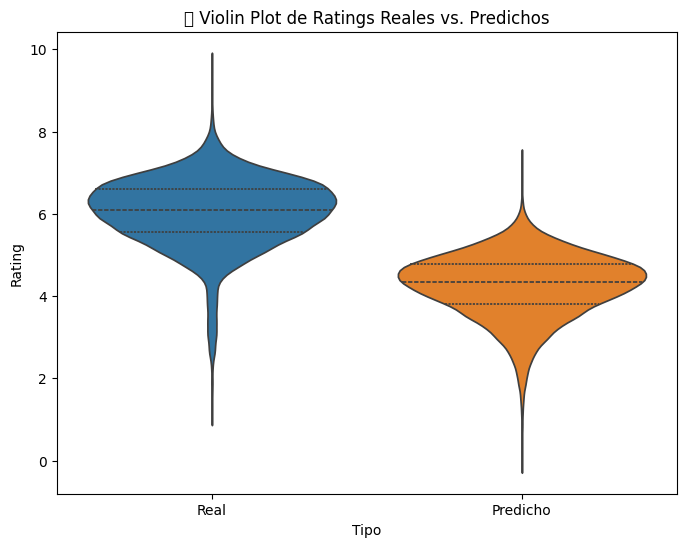

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Predecimos sobre TODO el dataset original (no hace falta separar train/test si solo querés visualizar)
model.eval()
with torch.no_grad():
    preds = model(user_ids, item_ids).numpy()

# Creamos DataFrame con ratings reales y predichos
df_plot = pd.DataFrame({
    "Rating_real": df["Rating"].values,
    "Rating_predicho": preds
})

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Suponiendo que ya tenés estos dos arrays:
# y_true = valores reales
# y_pred = valores predichos por el modelo

# Armamos DataFrame apilado
df_violin = pd.DataFrame({
    "Rating": np.concatenate([df["Rating"].values, preds]),
    "Tipo": ["Real"] * len(df["Rating"].values) + ["Predicho"] * len(preds)
})
colores = {"Real": "#1f77b4", "Predicho": "#ff7f0e"}  # Azul y naranja

plt.figure(figsize=(8, 6))
sns.violinplot(
    x="Tipo",
    y="Rating",
    data=df_violin,
    inner="quartile",
    palette = colores
)
plt.title("🎻 Violin Plot de Ratings Reales vs. Predichos")
plt.show()



In [35]:
recomendados = recomendar_jugadores_para_equipo(
    nombre_equipo="Sevilla",
    df = df,
    jugadores_filtrados=jugadores_filtrados,
    modelo=model,  # tu modelo entrenado de este bloque
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    top_n=5
)
print(recomendados)



🎯 Recomendaciones para el equipo 'Sevilla' en el año 2025:
Jugador: M. RYAN, Rating estimado: 5.68
Jugador: M. SALAH, Rating estimado: 5.53
Jugador: H. MORENO, Rating estimado: 5.45
Jugador: NICOLAS TAGLIAFICO, Rating estimado: 5.40
Jugador: C. ZAPATA, Rating estimado: 5.23
[('M. RYAN', 5.684422969818115), ('M. SALAH', 5.534426689147949), ('H. MORENO', 5.453414440155029), ('NICOLAS TAGLIAFICO', 5.399399757385254), ('C. ZAPATA', 5.23354959487915)]


In [36]:
#recomendar_jugadores_para_equipo("Racing", model, df, jugadores_filtrados, user_encoder, item_encoder, top_n=5)


## Modelo solo factores latentes separando train y test

In [57]:
from torch.utils.data import DataLoader, TensorDataset

# Hiperparámetros
embedding_dim = 20
lambda_reg = 0.01
lr = 0.01
epochs = 30

# Dataset en tensores
user_ids = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
item_ids = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
ratings = torch.tensor(df_cv["Rating"].values, dtype=torch.float32)

dataset = TensorDataset(user_ids, item_ids, ratings)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

# Modelo y optimizador
model = MFModel(
    num_users=df_cv["user_id"].nunique(),
    num_items=df_cv["item_id"].nunique(),
    embedding_dim=embedding_dim,
    lambda_reg=lambda_reg,
    )
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Entrenamiento
for epoch in range(epochs):
    total_loss = 0
    for batch_user, batch_item, batch_rating in loader:
        preds = model(batch_user, batch_item)
        loss = model.loss(preds, batch_rating, batch_user, batch_item)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/30, Loss: 23029.1319
Epoch 2/30, Loss: 16407.0314
Epoch 3/30, Loss: 12898.7001
Epoch 4/30, Loss: 10802.0234
Epoch 5/30, Loss: 9382.1666
Epoch 6/30, Loss: 8322.9510
Epoch 7/30, Loss: 7479.8430
Epoch 8/30, Loss: 6779.9412
Epoch 9/30, Loss: 6202.3837
Epoch 10/30, Loss: 5721.2642
Epoch 11/30, Loss: 5314.6551
Epoch 12/30, Loss: 4971.3367
Epoch 13/30, Loss: 4679.5978
Epoch 14/30, Loss: 4431.5102
Epoch 15/30, Loss: 4223.0362
Epoch 16/30, Loss: 4053.4649
Epoch 17/30, Loss: 3912.7217
Epoch 18/30, Loss: 3802.3531
Epoch 19/30, Loss: 3715.8302
Epoch 20/30, Loss: 3648.5953
Epoch 21/30, Loss: 3598.7474
Epoch 22/30, Loss: 3561.6926
Epoch 23/30, Loss: 3533.8407
Epoch 24/30, Loss: 3514.1946
Epoch 25/30, Loss: 3499.1868
Epoch 26/30, Loss: 3489.9131
Epoch 27/30, Loss: 3481.4830
Epoch 28/30, Loss: 3475.8021
Epoch 29/30, Loss: 3472.1053
Epoch 30/30, Loss: 3469.1278


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import spearmanr, kendalltau


# --- EVALUACIÓN EN TEST FINAL (FILTRADO) ---
test_user = torch.tensor(df_test_final_filtrado["user_id"].values, dtype=torch.long)
test_item = torch.tensor(df_test_final_filtrado["item_id"].values, dtype=torch.long)
test_time = torch.tensor(df_test_final_filtrado["time_idx"].values, dtype=torch.long)
test_rating = torch.tensor(df_test_final_filtrado["Rating"].values, dtype=torch.float32)

model.eval()
with torch.no_grad():
    pred_test = model(test_user, test_item).cpu().numpy()
    true_test = test_rating.cpu().numpy()

def pmae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

# Métricas
rmse = np.sqrt(np.mean((pred_test - true_test) ** 2))
mae = mean_absolute_error(true_test, pred_test)
r2 = r2_score(true_test, pred_test)
spearman_corr, _ = spearmanr(true_test, pred_test)
kendall_corr, _ = kendalltau(true_test, pred_test)
pmae_value = pmae(true_test, pred_test)

# Resultados
print("\n📊 Evaluación en test final (2025, solo jugadores/equipos conocidos):")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")
print(f"PMAE (%)    : {pmae_value:.2f}")

resultados_metricas = []



# Guardá resultados en un diccionario (agregá otros campos si querés, ej: nombre del modelo, hiperparámetros)
resultados_metricas.append({
    "Modelo": "basicSVD_0",      # o hiperparámetros, etc.
    "RMSE": rmse,
    "MAE": mae,
    "R2": r2,
    "Spearman": spearman_corr,
    "Kendall": kendall_corr,
    "PMAE": pmae_value
})

# Al final, convertí a DataFrame:
df_metricas = pd.DataFrame(resultados_metricas)


📊 Evaluación en test final (2025, solo jugadores/equipos conocidos):
RMSE        : 1.7098
MAE         : 1.5183
R²          : -3.1495
Spearman ρ  : 0.1611
Kendall τ   : 0.1099
PMAE (%)    : 24.75


<ipython-input-59-365c0dfa38b7>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


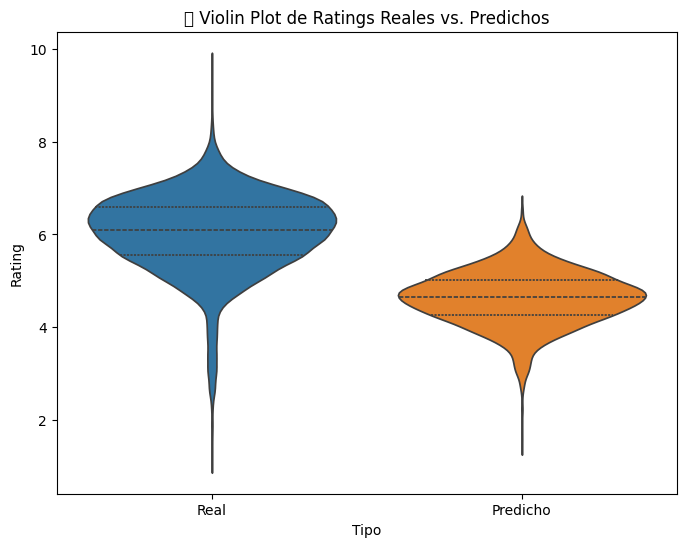

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Predecimos sobre TODO el dataset original (no hace falta separar train/test si solo querés visualizar)
model.eval()
with torch.no_grad():
    preds = model(test_user, test_item).numpy()

# Creamos DataFrame con ratings reales y predichos
df_plot = pd.DataFrame({
    "Rating_real": df_test_final_filtrado["Rating"].values,
    "Rating_predicho": preds
})

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Suponiendo que ya tenés estos dos arrays:
# y_true = valores reales
# y_pred = valores predichos por el modelo

# Armamos DataFrame apilado
df_violin = pd.DataFrame({
    "Rating": np.concatenate([df["Rating"].values, preds]),
    "Tipo": ["Real"] * len(df["Rating"].values) + ["Predicho"] * len(preds)
})
colores = {"Real": "#1f77b4", "Predicho": "#ff7f0e"}  # Azul y naranja

plt.figure(figsize=(8, 6))
sns.violinplot(
    x="Tipo",
    y="Rating",
    data=df_violin,
    inner="quartile",
    palette = colores
)
plt.title("🎻 Violin Plot de Ratings Reales vs. Predichos")
plt.show()



In [60]:
# 🔁 SOLO UNA VEZ al comienzo, antes de cualquier modelo:
df_cv_preds = df_cv.copy()
df_test_preds = df_test_final_filtrado.copy()


# --- Generar predicciones ---
pred_cv = guardar_preds_modelo(
    df=df_cv,
    model=model,
    user_tensor=user_ids,
    item_tensor=item_ids,
    time_tensor=None,
    name_columna="temp_basicSVD_0"  # nombre temporal, no se usará
)["temp_basicSVD_0"]

pred_test = guardar_preds_modelo(
    df=df_test_final_filtrado,
    model=model,
    user_tensor=test_user,
    item_tensor=test_item,
    time_tensor=None,
    name_columna="temp_basicSVD_0"
)["temp_basicSVD_0"]

df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds,
    df_test_preds,
    nombre_columna="pred_basicSVD_0",
    preds_cv=pred_cv,
    preds_test=pred_test
)

✅ Predicciones guardadas como 'temp_basicSVD_0'
✅ Predicciones guardadas como 'temp_basicSVD_0'
✅ Columna 'pred_basicSVD_0' agregada correctamente.


## Cross validation para probar varios parámetros

In [61]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Extraer año final de temporada
def extraer_anio_final(temporada):
    try:
        temporada = str(temporada)
        if "/" in temporada:
            return 2000 + int(temporada.split("/")[1])
        elif temporada.isdigit():
            return int(temporada)
    except:
        return None

df["Año_Orden"] = df["Año"].apply(extraer_anio_final)
df = df.dropna(subset=["Año_Orden"])
df["Año_Orden"] = df["Año_Orden"].astype(int)

# Separar mitad de 2025 para test
df_2025 = df[df["Año_Orden"] == 2025].copy()
df_test_final = df_2025.sample(frac=0.5, random_state=42)
df_cv = df.drop(index=df_test_final.index).copy()

# Filtrar test para que no haya jugadores/equipos nuevos
ids_entrenamiento = set(df_cv["ID Jugador"])
equipos_entrenamiento = set(df_cv["Equipo"])

df_test_final_filtrado = df_test_final[
    df_test_final["ID Jugador"].isin(ids_entrenamiento) &
    df_test_final["Equipo"].isin(equipos_entrenamiento)
].copy()

# Codificación
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df_cv["user_id"] = user_encoder.fit_transform(df_cv["ID Jugador"])
df_cv["item_id"] = item_encoder.fit_transform(df_cv["Equipo"])
df_cv["time_idx"] = df_cv["Año_Orden"].astype("category").cat.codes

df_test_final_filtrado["user_id"] = user_encoder.transform(df_test_final_filtrado["ID Jugador"])
df_test_final_filtrado["item_id"] = item_encoder.transform(df_test_final_filtrado["Equipo"])
df_test_final_filtrado["time_idx"] = pd.Categorical(
    df_test_final_filtrado["Año_Orden"], categories=df_cv["Año_Orden"].unique()
).codes

# Resumen
print(f"📦 Total de datos: {len(df)}")
print(f"🧪 Test final (filtrado): {len(df_test_final_filtrado)} registros")
print(f"🎯 Entrenamiento y validación (df_cv): {len(df_cv)} registros")


📦 Total de datos: 33220
🧪 Test final (filtrado): 3079 registros
🎯 Entrenamiento y validación (df_cv): 30104 registros


In [62]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def train_and_evaluate(df_cv, embedding_dim, lambda_reg, lr, epochs=5):
    # Tensores
    user_ids = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
    item_ids = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
    time_ids = torch.tensor(df_cv["time_idx"].values, dtype=torch.long)
    ratings = torch.tensor(df_cv["Rating"].values, dtype=torch.float32)

    # Train/Val split
    X = list(zip(user_ids, item_ids, time_ids))
    X_train, X_val, y_train, y_val = train_test_split(X, ratings, test_size=0.2, random_state=42)

    train_user, train_item, train_time = zip(*X_train)
    val_user, val_item, val_time = zip(*X_val)

    train_dataset = TensorDataset(
        torch.tensor(train_user), torch.tensor(train_item),
        torch.tensor(train_time), y_train
    )
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    # Parámetros del modelo
    num_users = df_cv["user_id"].nunique()
    num_items = df_cv["item_id"].nunique()
    num_times = df_cv["time_idx"].nunique()
    global_mean = df_cv["Rating"].mean()

    class MFModel(nn.Module):
        def __init__(self, num_users, num_items, num_times, embedding_dim, lambda_reg, global_mean):
            super().__init__()
            self.embedding_dim = embedding_dim
            self.num_times = num_times
            self.lambda_reg = lambda_reg
            self.mu = global_mean

            # Factores latentes
            self.user_factors = nn.Embedding(num_users, embedding_dim)
            self.item_factors = nn.Embedding(num_items, embedding_dim)

            # Sesgos básicos
            self.user_bias = nn.Embedding(num_users, 1)
            self.item_bias = nn.Embedding(num_items, 1)

            # Sesgos por jugador-tiempo y equipo-tiempo
            self.user_time_bias = nn.Embedding(num_users * num_times, 1)
            self.item_time_bias = nn.Embedding(num_items * num_times, 1)

            # Inicialización normal con std = 1 / sqrt(d)
            std = 1.0 / embedding_dim**0.5
            for emb in [
                self.user_factors, self.item_factors,
                self.user_bias, self.item_bias,
                self.user_time_bias, self.item_time_bias
            ]:
                nn.init.normal_(emb.weight, mean=0.0, std=std)

        def forward(self, user_ids, item_ids, time_ids):
            p_u = self.user_factors(user_ids)
            q_i = self.item_factors(item_ids)

            b_u = self.user_bias(user_ids).squeeze()
            b_i = self.item_bias(item_ids).squeeze()

            user_time_index = user_ids * self.num_times + time_ids
            item_time_index = item_ids * self.num_times + time_ids

            b_ut = self.user_time_bias(user_time_index).squeeze()
            b_it = self.item_time_bias(item_time_index).squeeze()

            dot = (p_u * q_i).sum(1)
            return self.mu + b_u + b_i + b_ut + b_it + dot

        def loss(self, preds, ratings, user_ids, item_ids, time_ids):
            user_time_index = user_ids * self.num_times + time_ids
            item_time_index = item_ids * self.num_times + time_ids

            mse = nn.functional.mse_loss(preds, ratings)
            reg = self.lambda_reg * (
                self.user_factors(user_ids).norm(2).pow(2) +
                self.item_factors(item_ids).norm(2).pow(2) +
                self.user_bias(user_ids).norm(2).pow(2) +
                self.item_bias(item_ids).norm(2).pow(2) +
                self.user_time_bias(user_time_index).norm(2).pow(2) +
                self.item_time_bias(item_time_index).norm(2).pow(2)
            ).mean()
            return mse + reg


    # Instanciar y entrenar
    model = MFModel(num_users, num_items, num_times, embedding_dim, lambda_reg, global_mean)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for user, item, time, rating in train_loader:
            preds = model(user, item, time)
            loss = model.loss(preds, rating, user, item, time)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluación
    model.eval()
    with torch.no_grad():
        val_preds = model(torch.tensor(val_user), torch.tensor(val_item), torch.tensor(val_time)).cpu().numpy()
        y_true = y_val.cpu().numpy()

    rmse_val = np.sqrt(np.mean((val_preds - y_true) ** 2))
    mae_val = mean_absolute_error(y_true, val_preds)
    r2_val = r2_score(y_true, val_preds)

    return rmse_val, mae_val, r2_val, model


In [63]:
# Hiperparámetros a probar
import itertools

embedding_dims = [1, 2, 3, 5, 8, 11, 15, 20, 25, 30]
lambda_regs = [0.01, 0.1]
lrs = [0.01, 0.001]

best_rmse = float("inf")
best_params = None
best_model = None
resultados = []

print("🔍 Buscando mejores hiperparámetros...\n")

for emb_dim, lmbda, lr in itertools.product(embedding_dims, lambda_regs, lrs):
    rmse, mae, r2, model = train_and_evaluate(df_cv, emb_dim, lmbda, lr)
    print(f"✅ emb={emb_dim}, lambda={lmbda}, lr={lr} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    resultados.append({
        "embedding_dim": emb_dim,
        "lambda_reg": lmbda,
        "learning_rate": lr,
        "rmse_val": rmse,
        "mae_val": mae,
        "r2_val": r2
    })

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (emb_dim, lmbda, lr)
        best_model = model


print(f"\n🏆 Mejor combinación encontrada (en validación hasta 2024):")
print(f"embedding_dim={best_params[0]}, lambda={best_params[1]}, lr={best_params[2]} → RMSE: {best_rmse:.4f}")

🔍 Buscando mejores hiperparámetros...

✅ emb=1, lambda=0.01, lr=0.01 → RMSE: 1.5638, MAE: 1.2250, R²: -2.1156
✅ emb=1, lambda=0.01, lr=0.001 → RMSE: 2.2143, MAE: 1.7441, R²: -5.2465
✅ emb=1, lambda=0.1, lr=0.01 → RMSE: 1.4898, MAE: 1.1687, R²: -1.8278
✅ emb=1, lambda=0.1, lr=0.001 → RMSE: 2.1707, MAE: 1.7206, R²: -5.0034
✅ emb=2, lambda=0.01, lr=0.01 → RMSE: 1.2089, MAE: 0.9387, R²: -0.8620
✅ emb=2, lambda=0.01, lr=0.001 → RMSE: 1.5925, MAE: 1.2632, R²: -2.2310
✅ emb=2, lambda=0.1, lr=0.01 → RMSE: 1.1756, MAE: 0.9120, R²: -0.7607
✅ emb=2, lambda=0.1, lr=0.001 → RMSE: 1.5891, MAE: 1.2525, R²: -2.2172
✅ emb=3, lambda=0.01, lr=0.01 → RMSE: 1.0974, MAE: 0.8467, R²: -0.5344
✅ emb=3, lambda=0.01, lr=0.001 → RMSE: 1.4258, MAE: 1.1142, R²: -1.5900
✅ emb=3, lambda=0.1, lr=0.01 → RMSE: 1.0690, MAE: 0.8258, R²: -0.4560
✅ emb=3, lambda=0.1, lr=0.001 → RMSE: 1.3797, MAE: 1.0779, R²: -1.4254
✅ emb=5, lambda=0.01, lr=0.01 → RMSE: 1.0016, MAE: 0.7678, R²: -0.2781
✅ emb=5, lambda=0.01, lr=0.001 → RMSE:

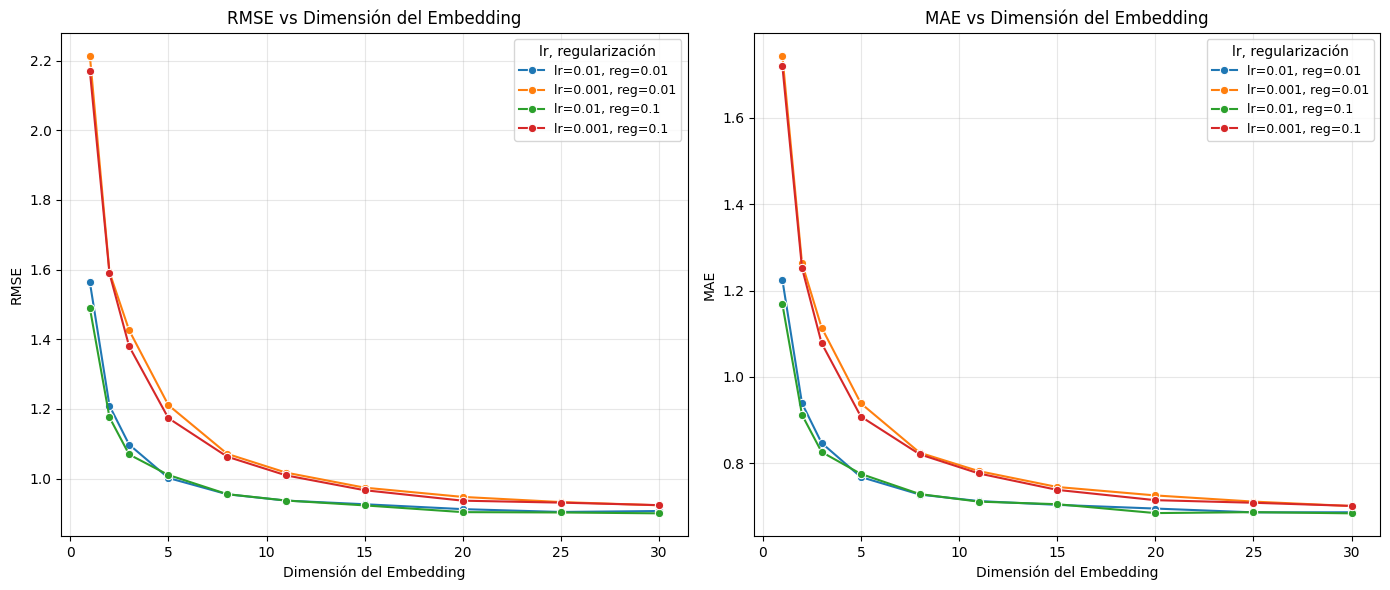

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_resultados = pd.DataFrame(resultados)
# Si no lo hiciste ya: agregá una columna que combine lr y lambda para el color
df_resultados["combo"] = df_resultados.apply(
    lambda row: f"lr={row['learning_rate']}, reg={row['lambda_reg']}", axis=1
)

# Asegurate de que embedding_dim esté ordenado numéricamente
df_resultados = df_resultados.sort_values("embedding_dim")

# Gráfico
plt.figure(figsize=(14, 6))

# --- RMSE ---
plt.subplot(1, 2, 1)
sns.lineplot(
    data=df_resultados,
    x="embedding_dim",
    y="rmse_val",
    hue="combo",
    marker="o",
    palette="tab10"
)
plt.title("RMSE vs Dimensión del Embedding")
plt.xlabel("Dimensión del Embedding")
plt.ylabel("RMSE")
plt.grid(True, alpha=0.3)
plt.legend(title="lr, regularización", fontsize=9)

# --- MAE ---
plt.subplot(1, 2, 2)
sns.lineplot(
    data=df_resultados,
    x="embedding_dim",
    y="mae_val",
    hue="combo",
    marker="o",
    palette="tab10"
)
plt.title("MAE vs Dimensión del Embedding")
plt.xlabel("Dimensión del Embedding")
plt.ylabel("MAE")
plt.grid(True, alpha=0.3)
plt.legend(title="lr, regularización", fontsize=9)

plt.tight_layout()
plt.show()


In [65]:
from scipy.stats import spearmanr, kendalltau

# Evaluación en test final (temporada 2025)
test_user = torch.tensor(df_test_final_filtrado["user_id"].values, dtype=torch.long)
test_item = torch.tensor(df_test_final_filtrado["item_id"].values, dtype=torch.long)
test_time = torch.tensor(df_test_final_filtrado["time_idx"].values, dtype=torch.long)
test_rating = torch.tensor(df_test_final_filtrado["Rating"].values, dtype=torch.float32)

best_model.eval()
with torch.no_grad():
    test_preds = best_model(test_user, test_item, test_time).cpu().numpy()
    test_true = test_rating.cpu().numpy()

# Métricas clásicas
rmse_test_final = np.sqrt(np.mean((test_preds - test_true) ** 2))
mae_test_final = mean_absolute_error(test_true, test_preds)
r2_test_final = r2_score(test_true, test_preds)

# Métricas de orden
spearman_corr, _ = spearmanr(test_true, test_preds)
kendall_corr, _ = kendalltau(test_true, test_preds)

# Mostrar resultados
print(f"\n📊 Evaluación final (temporada 2025):")
print(f"RMSE        : {rmse_test_final:.4f}")
print(f"MAE         : {mae_test_final:.4f}")
print(f"R²          : {r2_test_final:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")

# Mostrar tabla ordenada por RMSE de validación
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values("rmse_val").reset_index(drop=True)

print("\n📋 Tabla de resultados ordenada por RMSE (validación hasta 2024):")
print(df_resultados)



📊 Evaluación final (temporada 2025):
RMSE        : 0.8805
MAE         : 0.6672
R²          : -0.1004
Spearman ρ  : 0.0089
Kendall τ   : 0.0058

📋 Tabla de resultados ordenada por RMSE (validación hasta 2024):
    embedding_dim  lambda_reg  learning_rate  rmse_val   mae_val    r2_val
0              30        0.10          0.010  0.899939  0.683674 -0.031825
1              25        0.10          0.010  0.902428  0.686421 -0.037539
2              20        0.10          0.010  0.903392  0.684249 -0.039757
3              25        0.01          0.010  0.903893  0.685963 -0.040911
4              30        0.01          0.010  0.906619  0.686165 -0.047199
5              20        0.01          0.010  0.912021  0.694768 -0.059717
6              15        0.10          0.010  0.922779  0.704872 -0.084864
7              30        0.01          0.001  0.922983  0.700581 -0.085342
8              30        0.10          0.001  0.923476  0.700874 -0.086502
9              15        0.01          0

## Codigo para otra distribución de train test

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# --- Función para extraer año final de temporada (igual que antes) ---
def extraer_anio_final(temporada):
    try:
        temporada = str(temporada)
        if "/" in temporada:
            return 2000 + int(temporada.split("/")[1])
        elif temporada.isdigit():
            return int(temporada)
    except:
        return None

df["Año_Orden"] = df["Año"].apply(extraer_anio_final)
df = df.dropna(subset=["Año_Orden"])
df["Año_Orden"] = df["Año_Orden"].astype(int)

# --- Seleccionar los 3000 jugadores con más registros ---
top_players = df["ID Jugador"].value_counts().nlargest(3000).index

# --- Tomar el último dato de cada uno de esos jugadores para test ---
df_top_players = df[df["ID Jugador"].isin(top_players)].copy()
idx_last = df_top_players.groupby("ID Jugador")["Año_Orden"].idxmax()
df_test_final = df.loc[idx_last].copy()

# --- El resto va a train ---
df_cv = df.drop(index=idx_last).copy()

# --- Asegurarse que todos los jugadores y equipos en test estén en train ---
ids_entrenamiento = set(df_cv["ID Jugador"])
equipos_entrenamiento = set(df_cv["Equipo"])
df_test_final_filtrado = df_test_final[
    df_test_final["ID Jugador"].isin(ids_entrenamiento) &
    df_test_final["Equipo"].isin(equipos_entrenamiento)
].copy()

# --- Codificación ---
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df_cv["user_id"] = user_encoder.fit_transform(df_cv["ID Jugador"])
df_cv["item_id"] = item_encoder.fit_transform(df_cv["Equipo"])
df_cv["time_idx"] = df_cv["Año_Orden"].astype("category").cat.codes

df_test_final_filtrado["user_id"] = user_encoder.transform(df_test_final_filtrado["ID Jugador"])
df_test_final_filtrado["item_id"] = item_encoder.transform(df_test_final_filtrado["Equipo"])
df_test_final_filtrado["time_idx"] = pd.Categorical(
    df_test_final_filtrado["Año_Orden"], categories=df_cv["Año_Orden"].unique()
).codes

# --- Resumen ---
print(f"📦 Total de datos: {len(df)}")
print(f"🧪 Test final (filtrado): {len(df_test_final_filtrado)} registros")
print(f"🎯 Entrenamiento y validación (df_cv): {len(df_cv)} registros")


📦 Total de datos: 33220
🧪 Test final (filtrado): 3000 registros
🎯 Entrenamiento y validación (df_cv): 30220 registros


## Compruebo al modelo final entrenado con datos hasta 2024 y testeando en 2025 con embedding dim chica y sin temporalidad!

In [179]:
class MFModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, lambda_reg, global_mean):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.lambda_reg = lambda_reg
        self.mu = global_mean

        self.user_factors = nn.Embedding(num_users, embedding_dim)
        self.item_factors = nn.Embedding(num_items, embedding_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        std = 1.0 / embedding_dim
        for emb in [
            self.user_factors, self.item_factors,
            self.user_bias, self.item_bias
        ]:
            nn.init.normal_(emb.weight, mean=0.0, std=std)

    def forward(self, user_ids, item_ids, time_ids=None):  # time_ids queda pero no se usa
        p_u = self.user_factors(user_ids)
        q_i = self.item_factors(item_ids)
        b_u = self.user_bias(user_ids).squeeze()
        b_i = self.item_bias(item_ids).squeeze()
        dot = (p_u * q_i).sum(1)
        return self.mu + b_u + b_i + dot

    def loss(self, preds, ratings, user_ids, item_ids, time_ids=None):  # time_ids no se usa
        mse = nn.functional.mse_loss(preds, ratings)
        reg = self.lambda_reg * (
            0.125*self.user_factors(user_ids).norm(2).pow(2) +
            0.125*self.item_factors(item_ids).norm(2).pow(2) +
            1*self.user_bias(user_ids).norm(2).pow(2) +
            1*self.item_bias(item_ids).norm(2).pow(2)
        ).mean()
        return mse + reg


In [180]:
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau
import numpy as np

# --- ENTRENAMIENTO ---
train_user = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
train_item = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
train_time = torch.tensor(df_cv["time_idx"].values, dtype=torch.long)
train_rating = torch.tensor(df_cv["Rating"].values, dtype=torch.float32)

train_dataset_SVD = TensorDataset(train_user, train_item, train_time, train_rating)
train_loader_SVD = DataLoader(train_dataset_SVD, batch_size=128, shuffle=True)

# Crear modelo final
final_model_basicSVD = MFModel(
    num_users=df_cv["user_id"].nunique(),
    num_items=df_cv["item_id"].nunique(),
    embedding_dim=10,
    lambda_reg=best_params[1],
    global_mean=df_cv["Rating"].mean()
)

optimizer = torch.optim.Adam(final_model_basicSVD.parameters(), lr=best_params[2])

# Entrenar modelo
for epoch in range(5):
    final_model_basicSVD.train()
    total_loss = 0
    for user, item, time, rating in train_loader_SVD:
        preds = final_model_basicSVD(user, item, time)
        loss = final_model_basicSVD.loss(preds, rating, user, item, time)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/4, Loss: {total_loss:.2f}")

# --- EVALUACIÓN EN TEST FINAL (FILTRADO) ---
test_user = torch.tensor(df_test_final_filtrado["user_id"].values, dtype=torch.long)
test_item = torch.tensor(df_test_final_filtrado["item_id"].values, dtype=torch.long)
test_time = torch.tensor(df_test_final_filtrado["time_idx"].values, dtype=torch.long)
test_rating = torch.tensor(df_test_final_filtrado["Rating"].values, dtype=torch.float32)

final_model_basicSVD.eval()
with torch.no_grad():
    pred_test = final_model_basicSVD(test_user, test_item, test_time).cpu().numpy()
    true_test = test_rating.cpu().numpy()

# Métricas
rmse = np.sqrt(np.mean((pred_test - true_test) ** 2))
mae = mean_absolute_error(true_test, pred_test)
r2 = r2_score(true_test, pred_test)
spearman_corr, _ = spearmanr(true_test, pred_test)
kendall_corr, _ = kendalltau(true_test, pred_test)
pmae_value = pmae(true_test, pred_test)


# Resultados
print("\n📊 Evaluación en test final (2025, solo jugadores/equipos conocidos):")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")
print(f"PMAE        : {pmae_value:.2f}")


# Guardá resultados en un diccionario (agregá otros campos si querés, ej: nombre del modelo, hiperparámetros)
resultados_metricas.append({
    "Modelo": "basicSVD_v2",      # o hiperparámetros, etc.
    "RMSE": rmse,
    "MAE": mae,
    "R2": r2,
    "Spearman": spearman_corr,
    "Kendall": kendall_corr,
    "PMAE": pmae_value
})

# Al final, convertí a DataFrame:
df_metricas = pd.DataFrame(resultados_metricas)


Epoch 1/4, Loss: 220.46
Epoch 2/4, Loss: 188.61
Epoch 3/4, Loss: 190.38
Epoch 4/4, Loss: 192.56
Epoch 5/4, Loss: 193.07

📊 Evaluación en test final (2025, solo jugadores/equipos conocidos):
RMSE        : 0.8347
MAE         : 0.6301
R²          : 0.0110
Spearman ρ  : 0.1236
Kendall τ   : 0.0836
PMAE        : 11.76


In [181]:
# --- Generar predicciones ---
pred_cv = guardar_preds_modelo(
    df=df_cv,
    model=final_model_basicSVD,
    user_tensor=train_user,
    item_tensor=train_item,
    time_tensor=None,
    name_columna="temp_basicSVD_v1"  # nombre temporal, no se usará
)["temp_basicSVD_v1"]

pred_test = guardar_preds_modelo(
    df=df_test_final_filtrado,
    model=final_model_basicSVD,
    user_tensor=test_user,
    item_tensor=test_item,
    time_tensor=None,
    name_columna="temp_basicSVD_v1"
)["temp_basicSVD_v1"]

df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds,
    df_test_preds,
    nombre_columna="pred_basicSVD_v1",
    preds_cv=pred_cv,
    preds_test=pred_test
)



✅ Predicciones guardadas como 'temp_basicSVD_v1'
✅ Predicciones guardadas como 'temp_basicSVD_v1'
✅ Columna 'pred_basicSVD_v1' agregada correctamente.


In [182]:
def recomendar_jugadores_para_equipo_(
    nombre_equipo, modelo, df, jugadores_filtrados, user_encoder, item_encoder,
    top_n=5, año=2025
):
    # Codificar equipo
    if nombre_equipo not in item_encoder.classes_:
        print(f"Equipo '{nombre_equipo}' no encontrado.")
        return []

    equipo_id = item_encoder.transform([nombre_equipo])[0]

    # Codificar año
    time_categories = df["Año_Orden"].astype("category").cat.categories
    if año not in time_categories.values:
        print(f"Año {año} no está en las categorías del modelo.")
        return []

    time_idx = pd.Categorical([año], categories=time_categories).codes[0]

    # Jugadores que no jugaron aún en ese equipo
    todos_los_jugadores = df["user_id"].unique()
    jugadores_existentes = df[df["item_id"] == equipo_id]["user_id"].unique()
    jugadores_nuevos = list(set(todos_los_jugadores) - set(jugadores_existentes))

    # Filtro por jugadores válidos según el modelo
    jugadores_nuevos = [uid for uid in jugadores_nuevos if uid < modelo.user_factors.num_embeddings]

    if not jugadores_nuevos:
        print("⚠️ No hay jugadores nuevos válidos para recomendar.")
        return []

    # Tensores
    equipo_tensor = torch.tensor([equipo_id] * len(jugadores_nuevos), dtype=torch.long)
    jugadores_tensor = torch.tensor(jugadores_nuevos, dtype=torch.long)
    # El modelo espera un argumento de tiempo pero no lo usa; le pasamos ceros:
    tiempo_tensor = torch.tensor([0] * len(jugadores_nuevos), dtype=torch.long)

    # Predicción
    modelo.eval()
    with torch.no_grad():
        ratings_estimados = modelo(jugadores_tensor, equipo_tensor, tiempo_tensor)

    # Top N
    top_indices = torch.topk(ratings_estimados, top_n).indices
    top_user_ids = [jugadores_nuevos[i.item()] for i in top_indices]
    top_scores = [ratings_estimados[i].item() for i in top_indices]

    # Mapping a nombres reales
    user_id_to_real_id = df.drop_duplicates("user_id")[["user_id", "ID Jugador"]].set_index("user_id")["ID Jugador"].to_dict()
    top_real_ids = [user_id_to_real_id[uid] for uid in top_user_ids]

    id_to_nombre = jugadores_filtrados.drop_duplicates("ID Jugador")[["ID Jugador", "Nombre"]].set_index("ID Jugador")["Nombre"].to_dict()
    nombres_jugadores = [id_to_nombre.get(jid, "Nombre no encontrado") for jid in top_real_ids]

    # Mostrar recomendaciones
    recomendaciones = list(zip(nombres_jugadores, top_scores))
    print(f"\n🎯 Recomendaciones para el equipo '{nombre_equipo}' en el año {año}:")
    for nombre, score in recomendaciones:
        print(f"Jugador: {nombre}, Rating estimado: {score:.2f}")

    return recomendaciones


In [183]:
import torch
import pandas as pd # Asegúrate de importar pandas si no lo está globalmente

# ... (tu clase MFModel y el resto del código de entrenamiento) ...

def recomendar_jugadores_para_equipo_corregida( # Renombrada para claridad
    nombre_equipo, modelo, df, jugadores_filtrados, user_encoder, item_encoder,
    top_n=5, año=2025
):
    # Codificar equipo
    if nombre_equipo not in item_encoder.classes_:
        print(f"Equipo '{nombre_equipo}' no encontrado.")
        return []
    equipo_id = item_encoder.transform([nombre_equipo])[0]

    # Codificar año
    # Asegúrate de que df["Año_Orden"] exista y esté correctamente formateado
    # Esta línea puede fallar si df no tiene "Año_Orden" o si los valores no coinciden
    if "Año_Orden" not in df.columns:
        print("Error: La columna 'Año_Orden' no se encuentra en el DataFrame 'df'.")
        # Intenta usar una columna de tiempo por defecto si el modelo no la usa
        # O maneja el error de forma más robusta.
        # Por ahora, si el modelo NO usa el tiempo, podemos pasar un dummy.
        # PERO, si el modelo SÍ usara el tiempo, esto sería incorrecto.
        # Para tu modelo actual (MFModel que ignora time_ids), esto es aceptable como fallback.
        print("Asumiendo time_idx=0 ya que el modelo actual no usa el tiempo.")
        time_idx = 0
    else:
        time_categories = df["Año_Orden"].astype("category").cat.categories
        if año not in time_categories.values:
            print(f"Año {año} no está en las categorías del modelo para 'Año_Orden'.")
            # De nuevo, manejo de error o fallback
            print(f"Intentando usar el primer año disponible: {time_categories.values[0] if len(time_categories.values) > 0 else 'N/A'}")
            if len(time_categories.values) > 0:
                 time_idx = pd.Categorical([time_categories.values[0]], categories=time_categories).codes[0]
            else:
                print("No hay categorías de tiempo disponibles. Usando time_idx=0.")
                time_idx = 0 # Fallback
        else:
            time_idx = pd.Categorical([año], categories=time_categories).codes[0]


    # Jugadores nuevos (no presentes en ese equipo)
    todos_los_jugadores = df["user_id"].unique()
    jugadores_existentes = df[df["item_id"] == equipo_id]["user_id"].unique()
    jugadores_nuevos = list(set(todos_los_jugadores) - set(jugadores_existentes))

    # Filtro por jugadores válidos según el modelo
    # Asumiendo que tu modelo usa user_factors para determinar el num_embeddings para usuarios
    num_embeddings_user = modelo.user_factors.num_embeddings if hasattr(modelo, 'user_factors') else float('inf')
    jugadores_nuevos = [uid for uid in jugadores_nuevos if uid < num_embeddings_user]

    if not jugadores_nuevos:
        print("⚠️ No hay jugadores nuevos válidos para recomendar.")
        return []

    equipo_tensor = torch.tensor([equipo_id] * len(jugadores_nuevos), dtype=torch.long)
    jugadores_tensor = torch.tensor(jugadores_nuevos, dtype=torch.long)
    tiempo_tensor = torch.tensor([time_idx] * len(jugadores_nuevos), dtype=torch.long) # Usando el time_idx del año

    modelo.eval()
    with torch.no_grad():
        # Llamada directa, asumiendo que el forward siempre toma user, item, time
        # (incluso si time_ids es None por defecto y no se usa internamente)
        ratings_estimados = modelo(jugadores_tensor, equipo_tensor, tiempo_tensor)

    # Top N
    # Asegurarse de que top_n no sea mayor que el número de ratings estimados
    k = min(top_n, len(ratings_estimados))
    if k == 0:
        print("⚠️ No hay ratings estimados para seleccionar top N.")
        return []
    top_indices = torch.topk(ratings_estimados, k).indices # Usar k en lugar de top_n
    top_user_ids = [jugadores_nuevos[i.item()] for i in top_indices]
    top_scores = [ratings_estimados[i].item() for i in top_indices]

    # Mapping a nombres reales
    # Asegurarse de que las columnas 'user_id', 'ID Jugador', 'Nombre' existen
    if not all(col in df.columns for col in ["user_id", "ID Jugador"]):
        print("Error: 'df' debe contener las columnas 'user_id' y 'ID Jugador'.")
        return []
    if not all(col in jugadores_filtrados.columns for col in ["ID Jugador", "Nombre"]):
        print("Error: 'jugadores_filtrados' debe contener las columnas 'ID Jugador' y 'Nombre'.")
        return []

    user_id_to_real_id = df.drop_duplicates("user_id")[["user_id", "ID Jugador"]].set_index("user_id")["ID Jugador"].to_dict()
    top_real_ids = [user_id_to_real_id.get(uid) for uid in top_user_ids] # Usar .get() para evitar KeyError
    top_real_ids = [rid for rid in top_real_ids if rid is not None] # Filtrar None si algún user_id no mapea

    id_to_nombre = jugadores_filtrados.drop_duplicates("ID Jugador")[["ID Jugador", "Nombre"]].set_index("ID Jugador")["Nombre"].to_dict()
    nombres_jugadores = [id_to_nombre.get(jid, f"Nombre no encontrado para ID {jid}") for jid in top_real_ids]

    # Mostrar recomendaciones
    recomendaciones = list(zip(nombres_jugadores, top_scores[:len(nombres_jugadores)])) # Asegurar que las longitudes coincidan
    print(f"\n🎯 Recomendaciones para el equipo '{nombre_equipo}' en el año {año}:")
    for nombre, score in recomendaciones:
        print(f"Jugador: {nombre}, Rating estimado: {score:.2f}")

    return recomendaciones

<ipython-input-184-b4a8175ade55>:17: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


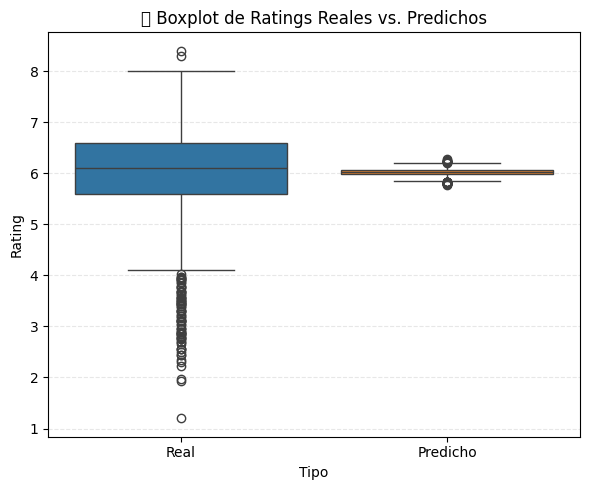

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear DataFrame para comparar
df_box = pd.DataFrame({
    "Real": true_test,
    "Predicho": pred_test
})

# Boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_box)
plt.title("📦 Boxplot de Ratings Reales vs. Predichos")
plt.ylabel("Rating")
plt.xlabel("Tipo")
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


<ipython-input-185-90e548ba3061>:8: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


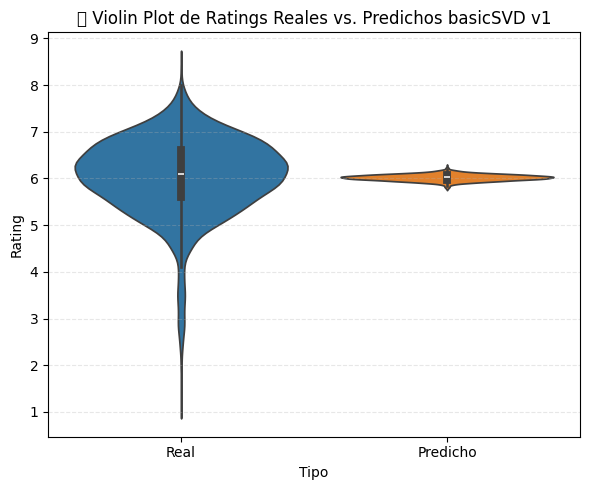

In [185]:
# Violin plot
plt.figure(figsize=(6, 5))
sns.violinplot(data=df_box)
plt.title("🎻 Violin Plot de Ratings Reales vs. Predichos basicSVD v1")
plt.ylabel("Rating")
plt.xlabel("Tipo")
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [186]:
## EN TODO EL DATASET
# --- ENTRENAMIENTO ---
train_user = torch.tensor(df["user_id"].values, dtype=torch.long)
train_item = torch.tensor(df["item_id"].values, dtype=torch.long)
train_time = torch.tensor(df["time_idx"].values, dtype=torch.long)
train_rating = torch.tensor(df["Rating"].values, dtype=torch.float32)

train_dataset = TensorDataset(train_user, train_item, train_time, train_rating)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Crear modelo final
final_model_basicSVD = MFModel(
    num_users=df["user_id"].nunique(),
    num_items=df["item_id"].nunique(),
    embedding_dim=10,
    lambda_reg=best_params[1],
    global_mean=df["Rating"].mean()
)

optimizer = torch.optim.Adam(final_model_basicSVD.parameters(), lr=best_params[2])

# Entrenar modelo
for epoch in range(10):
    final_model_basicSVD.train()
    total_loss = 0
    for user, item, time, rating in train_loader:
        preds = final_model_basicSVD(user, item, time)
        loss = final_model_basicSVD.loss(preds, rating, user, item, time)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/10, Loss: {total_loss:.2f}")

Epoch 1/10, Loss: 238.89
Epoch 2/10, Loss: 206.91
Epoch 3/10, Loss: 209.04
Epoch 4/10, Loss: 211.44
Epoch 5/10, Loss: 212.17
Epoch 6/10, Loss: 212.15
Epoch 7/10, Loss: 212.26
Epoch 8/10, Loss: 211.81
Epoch 9/10, Loss: 212.33
Epoch 10/10, Loss: 212.60


In [187]:
recomendados = recomendar_jugadores_para_equipo_corregida(
    nombre_equipo="Chelsea",
    df = df,
    jugadores_filtrados=jugadores_filtrados,
    modelo=final_model_basicSVD,  # tu modelo entrenado de este bloque
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    top_n=5
)
print(recomendados)



🎯 Recomendaciones para el equipo 'Chelsea' en el año 2025:
Jugador: HÉLITON, Rating estimado: 6.27
Jugador: D. ABAGNA, Rating estimado: 6.23
Jugador: L. GORETZKA, Rating estimado: 6.23
Jugador: C. BISHOP, Rating estimado: 6.22
Jugador: C. RONALDO, Rating estimado: 6.20
[('HÉLITON', 6.2741899490356445), ('D. ABAGNA', 6.234457969665527), ('L. GORETZKA', 6.225633144378662), ('C. BISHOP', 6.2249674797058105), ('C. RONALDO', 6.198967456817627)]


## Analisis de parámetros

In [ ]:
import torch

# Parámetros
nombre_jugador = "C. RONALDO"
nombre_equipo = "Racing"
año = 2025

# ID real del jugador
real_id = jugadores_filtrados[jugadores_filtrados["Nombre"] == nombre_jugador]["ID Jugador"].iloc[0]

# Codificación
user_id = df[df["ID Jugador"] == real_id]["user_id"].iloc[0]
item_id = item_encoder.transform([nombre_equipo])[0]

# Codificar año como índice temporal
time_categories = df["Año_Orden"].astype("category").cat.categories
time_idx = pd.Categorical([año], categories=time_categories).codes[0]

# Tensores
user_tensor = torch.tensor([user_id], dtype=torch.long)
item_tensor = torch.tensor([item_id], dtype=torch.long)
time_tensor = torch.tensor([time_idx], dtype=torch.long)

# Obtener componentes
final_model_basicSVD.eval()
with torch.no_grad():
    mu = final_model_basicSVD.mu.item()
    b_u = final_model_basicSVD.user_bias(user_tensor).item()
    b_i = final_model_basicSVD.item_bias(item_tensor).item()
    dot = (final_model_basicSVD.user_factors(user_tensor) * final_model_basicSVD.item_factors(item_tensor)).sum().item()
    pred = mu + b_u + b_i + dot

# Mostrar
print(f"\n🔍 Descomposición de predicción para:")
print(f"Jugador: {nombre_jugador} → user_id = {user_id}")
print(f"Equipo : {nombre_equipo} → item_id = {item_id}")
print(f"Año    : {año} → time_idx = {time_idx}")
print(f"\n🧩 Componentes del modelo:")
print(f"μ (media global)      : {mu:.4f}")
print(f"b_u (sesgo jugador)   : {b_u:.4f}")
print(f"b_i (sesgo equipo)    : {b_i:.4f}")
print(f"pu · qi (producto dot): {dot:.4f}")
print(f"\n📈 Predicción total   : {pred:.4f}")



🔍 Descomposición de predicción para:
Jugador: C. RONALDO → user_id = 2329
Equipo : Racing → item_id = 1241
Año    : 2025 → time_idx = 23

🧩 Componentes del modelo:
μ (media global)      : 6.0275
b_u (sesgo jugador)   : 0.2482
b_i (sesgo equipo)    : -0.0311
pu · qi (producto dot): 0.2124

📈 Predicción total   : 6.4569


# Benchmarks

## Benchmarks basicos

In [75]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import spearmanr, kendalltau
import numpy as np

# Ratings reales del test
y_test = df_test_final_filtrado["Rating"].values

# Predictor 1: media del entrenamiento
mean_rating = df_cv["Rating"].mean()
y_pred_media = np.full_like(y_test, fill_value=mean_rating)

# Predictor 2: sampleo de valores reales
np.random.seed(42)
y_pred_sampleado = np.random.choice(df_cv["Rating"].values, size=len(y_test), replace=True)


# Función para calcular todas las métricas
def evaluar_completo(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    pmae_value = pmae(true_test, pred_test)

    if np.all(y_pred == y_pred[0]):
        spearman_corr = float('nan')
        kendall_corr = float('nan')
        resultados_metricas.append({
          "Modelo": "media",      # o hiperparámetros, etc.
          "RMSE": rmse,
          "MAE": mae,
          "R2": r2,
          "Spearman": spearman_corr,
          "Kendall": kendall_corr,
          "PMAE": pmae_value
          })
    else:
        spearman_corr = float(spearmanr(y_true, y_pred)[0])
        kendall_corr = float(kendalltau(y_true, y_pred)[0])
        resultados_metricas.append({
          "Modelo": "sampling",      # o hiperparámetros, etc.
          "RMSE": rmse,
          "MAE": mae,
          "R2": r2,
          "Spearman": spearman_corr,
          "Kendall": kendall_corr,
          "PMAE": pmae_value
          })


    return {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Spearman ρ": spearman_corr,
        "Kendall τ": kendall_corr,
        "PMAE": pmae_value
    }


# Evaluar ambos
print("📊 Predictor que devuelve la media:")
print(evaluar_completo(y_test, y_pred_media))

print("\n🎲 Predictor que samplea desde el entrenamiento:")
print(evaluar_completo(y_test, y_pred_sampleado))


📊 Predictor que devuelve la media:
{'RMSE': 0.8395969991801753, 'MAE': 0.6350255563838769, 'R2': -0.0006017368000317269, 'Spearman ρ': nan, 'Kendall τ': nan, 'PMAE': np.float32(11.796558)}

🎲 Predictor que samplea desde el entrenamiento:
{'RMSE': 1.2070837574051103, 'MAE': 0.923795709721335, 'R2': -1.0682084545348918, 'Spearman ρ': -0.0014357326656869343, 'Kendall τ': -0.0011908864542105968, 'PMAE': np.float32(11.796558)}


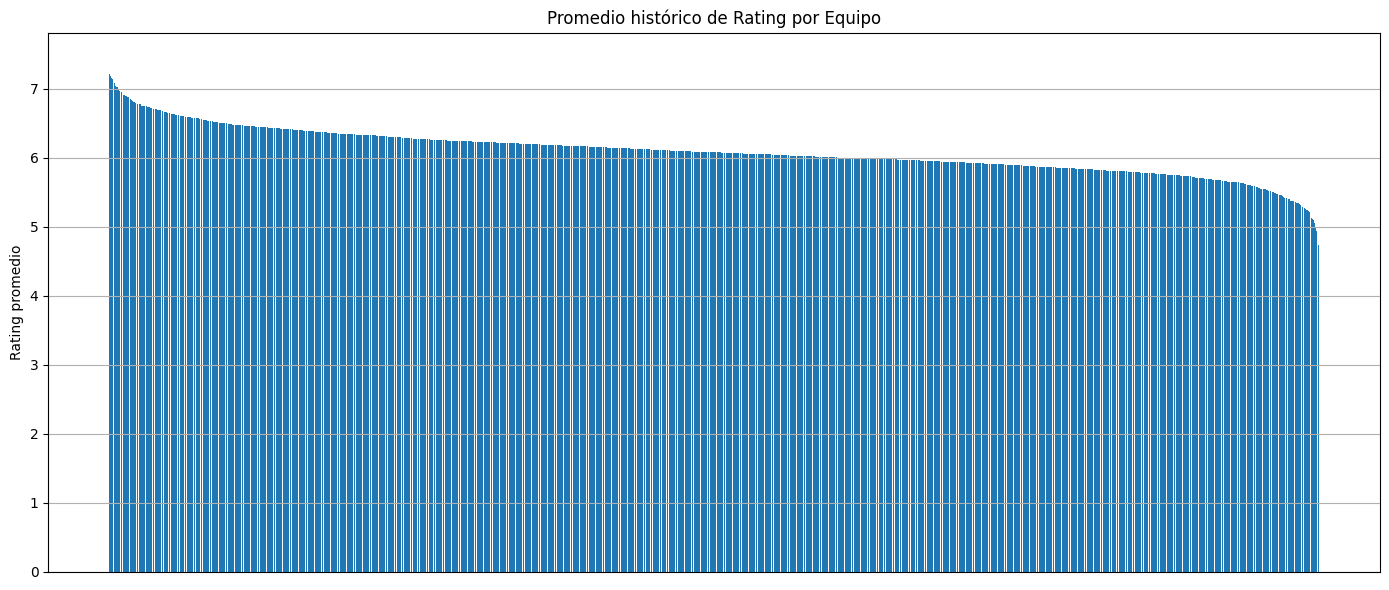

In [76]:
# 1. Calcular promedio histórico de ratings por equipo
rating_promedio_equipo = df.groupby("Equipo")["Rating"].mean().sort_values(ascending=False)

# 2. Graficar
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.bar(range(len(rating_promedio_equipo)), rating_promedio_equipo.values)
plt.title("Promedio histórico de Rating por Equipo")
plt.ylabel("Rating promedio")
plt.xticks([])  # Oculta los ticks del eje x
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


## Pruebo benchmark ML

In [77]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import spearmanr, kendalltau
from sklearn.model_selection import ParameterGrid

# Columnas que vamos a usar
columnas_extra = [
    "ID Jugador",
    "Asistencias",
    "Goles",
    "Minutos Jugados",
    "Minutos Por Partido",
    "Partidos Jugados"
]

# Merge con features adicionales
jugadores_extra = jugadores_filtrados[columnas_extra].drop_duplicates("ID Jugador")
df_cv_ml = df_cv.merge(jugadores_extra, on="ID Jugador", how="left")
df_test_ml = df_test_final_filtrado.merge(jugadores_extra, on="ID Jugador", how="left")

# Eliminar columna "Año" si está
df_cv_ml = df_cv_ml.drop(columns=["Año"], errors="ignore")
df_test_ml = df_test_ml.drop(columns=["Año"], errors="ignore")

# Codificar "Posición"
le_pos = LabelEncoder()

# Features y target
X_train = df_cv_ml.drop(columns=["Rating", "ID Jugador", "Equipo", "user_id", "item_id", "time_idx"], errors="ignore")
y_train = df_cv_ml["Rating"]
X_test = df_test_ml.drop(columns=["Rating", "ID Jugador", "Equipo", "user_id", "item_id", "time_idx"], errors="ignore")
y_test = df_test_ml["Rating"]

# Definición del grid de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01],
    'max_depth': [5]
}

# Ejecutar grid search manual
resultados_grid = []

for params in ParameterGrid(param_grid):
    model = XGBRegressor(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        random_state=42,
        verbosity=0
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spearman_corr, _ = spearmanr(y_test, y_pred)
    kendall_corr, _ = kendalltau(y_test, y_pred)
    pmae_value = pmae(true_test, pred_test)

    resultados_grid.append({
        "n_estimators": params['n_estimators'],
        "learning_rate": params['learning_rate'],
        "max_depth": params['max_depth'],
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Spearman ρ": spearman_corr,
        "Kendall τ": kendall_corr,
        "PMAE": pmae_value
    })

    resultados_metricas.append({
          "Modelo": "XGBoost",      # o hiperparámetros, etc.
          "RMSE": rmse,
          "MAE": mae,
          "R2": r2,
          "Spearman": spearman_corr,
          "Kendall": kendall_corr,
          "PMAE": pmae_value
          })

# Mostrar resultados ordenados por RMSE
df_resultados_grid = pd.DataFrame(resultados_grid).sort_values("MAE").reset_index(drop=True)
df_resultados_grid


n_estimators  learning_rate  max_depth      RMSE       MAE        R2  \
0           200           0.01          5  0.812973  0.603968  0.061852   
1           100           0.01          5  0.816501  0.609862  0.053691   
2            50           0.01          5  0.823371  0.617896  0.037699   

   Spearman ρ  Kendall τ       PMAE  
0    0.309477   0.215548  11.796558  
1    0.308861   0.214811  11.796558  
2    0.304080   0.211566  11.796558

               Feature  Importancia
4  Minutos Por Partido     0.426107
3      Minutos Jugados     0.177960
2                Goles     0.111349
0            Año_Orden     0.101198
1          Asistencias     0.097529
5     Partidos Jugados     0.085857


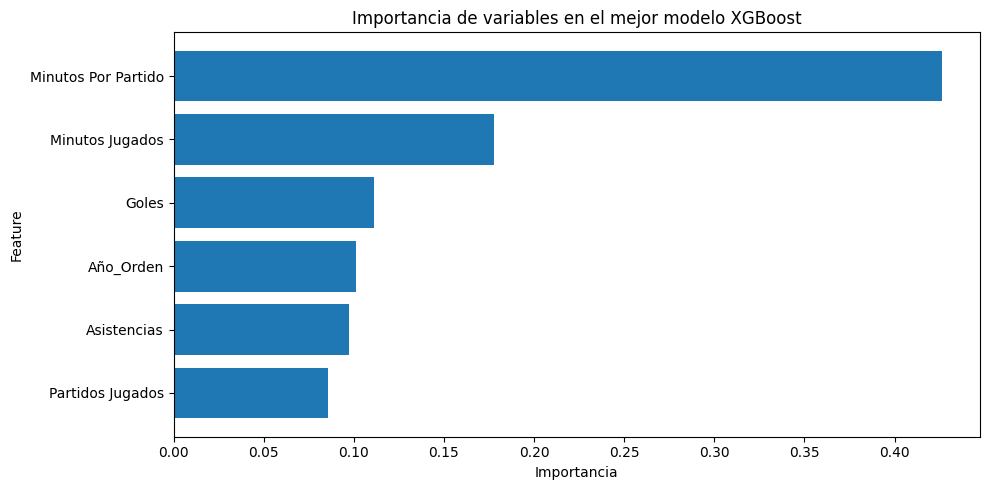

In [78]:
# Obtener los mejores hiperparámetros (primer fila del DataFrame ordenado)
mejores_params = df_resultados_grid.iloc[0][["n_estimators", "learning_rate", "max_depth"]].to_dict()

# Entrenar el modelo con los mejores hiperparámetros
mejor_modelo = XGBRegressor(
    n_estimators=int(mejores_params["n_estimators"]),
    learning_rate=mejores_params["learning_rate"],
    max_depth=int(mejores_params["max_depth"]),
    random_state=42
)
mejor_modelo.fit(X_train, y_train)

import matplotlib.pyplot as plt

# Obtener importancia de features
importancias = mejor_modelo.feature_importances_
nombres_features = X_train.columns

# Crear DataFrame para visualizar
df_importancias = pd.DataFrame({
    "Feature": nombres_features,
    "Importancia": importancias
}).sort_values("Importancia", ascending=False)

# Mostrar tabla
print(df_importancias)

# Gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(df_importancias["Feature"], df_importancias["Importancia"])
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de variables en el mejor modelo XGBoost")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Benchmarks promedios

In [79]:
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau
import numpy as np

# --- Preparar datos ---
df_train = df_cv.copy()
df_test = df_test_final_filtrado.copy()

# --- Medias por equipo e individuo ---
media_equipo = df_train.groupby("item_id")["Rating"].mean().to_dict()
media_jugador = df_train.groupby("user_id")["Rating"].mean().to_dict()

# --- Predicción por media del equipo ---
pred_equipo = df_test["item_id"].map(media_equipo).fillna(df_train["Rating"].mean()).values
true_test = df_test["Rating"].values

# --- Métricas para media de equipo ---
print("🎯 Benchmark: Media histórica del EQUIPO")
print(f"RMSE        : {np.sqrt(np.mean((pred_equipo - true_test) ** 2)):.4f}")
print(f"MAE         : {mean_absolute_error(true_test, pred_equipo):.4f}")
print(f"R²          : {r2_score(true_test, pred_equipo):.4f}")
print(f"Spearman ρ  : {spearmanr(true_test, pred_equipo)[0]:.4f}")
print(f"Kendall τ   : {kendalltau(true_test, pred_equipo)[0]:.4f}")
print(f"PMAE        : {pmae(true_test, pred_equipo):.2f}")

resultados_metricas.append({
          "Modelo": "Media Equipo",      # o hiperparámetros, etc.
          "RMSE": np.sqrt(np.mean((pred_equipo - true_test) ** 2)),
          "MAE": mean_absolute_error(true_test, pred_equipo),
          "R2": r2_score(true_test, pred_equipo),
          "Spearman": spearmanr(true_test, pred_equipo)[0],
          "Kendall": kendalltau(true_test, pred_equipo)[0],
          "PMAE": pmae(true_test, pred_equipo)
          })

print("\n" + "-"*50)

# --- Predicción por media del jugador ---
pred_jugador = df_test["user_id"].map(media_jugador).fillna(df_train["Rating"].mean()).values

# --- Métricas para media de jugador ---
print("🎯 Benchmark: Media histórica del JUGADOR")
print(f"RMSE        : {np.sqrt(np.mean((pred_jugador - true_test) ** 2)):.4f}")
print(f"MAE         : {mean_absolute_error(true_test, pred_jugador):.4f}")
print(f"R²          : {r2_score(true_test, pred_jugador):.4f}")
print(f"Spearman ρ  : {spearmanr(true_test, pred_jugador)[0]:.4f}")
print(f"Kendall τ   : {kendalltau(true_test, pred_jugador)[0]:.4f}")
print(f"PMAE        : {pmae(true_test, pred_jugador):.2f}")

resultados_metricas.append({
          "Modelo": "Media Jugador",      # o hiperparámetros, etc.
          "RMSE": np.sqrt(np.mean((pred_jugador - true_test) ** 2)),
          "MAE": mean_absolute_error(true_test, pred_jugador),
          "R2": r2_score(true_test, pred_jugador),
          "Spearman": spearmanr(true_test, pred_jugador)[0],
          "Kendall": kendalltau(true_test, pred_jugador)[0],
          "PMAE": pmae(true_test, pred_jugador)
          })


🎯 Benchmark: Media histórica del EQUIPO
RMSE        : 0.8451
MAE         : 0.6437
R²          : -0.0137
Spearman ρ  : 0.1234
Kendall τ   : 0.0833
PMAE        : 11.92

--------------------------------------------------
🎯 Benchmark: Media histórica del JUGADOR
RMSE        : 0.9248
MAE         : 0.6864
R²          : -0.2140
Spearman ρ  : 0.1694
Kendall τ   : 0.1157
PMAE        : 12.65


## Predictores base

In [80]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau

# --- Preparar datos ---
train_user = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
train_item = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
train_time = torch.tensor(df_cv["time_idx"].values, dtype=torch.long)
train_rating = torch.tensor(df_cv["Rating"].values, dtype=torch.float32)

train_dataset = TensorDataset(train_user, train_item, train_time, train_rating)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# --- Modelo base general con y sin sesgos temporales ---
class MFModel(nn.Module):
    def __init__(self, num_users, num_items, num_times, embedding_dim, lambda_reg, global_mean):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_times = num_times
        self.lambda_reg = lambda_reg
        self.mu = global_mean

        self.user_factors = nn.Embedding(num_users, embedding_dim)
        self.item_factors = nn.Embedding(num_items, embedding_dim)

        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.user_time_bias = nn.Embedding(num_users * num_times, 1)
        self.item_time_bias = nn.Embedding(num_items * num_times, 1)

        std = 1.0 / embedding_dim**0.5
        for emb in [
            self.user_factors, self.item_factors,
            self.user_bias, self.item_bias
        ]:
            nn.init.normal_(emb.weight, mean=0.0, std=std)

        nn.init.normal_(self.user_time_bias.weight, mean=0.0, std=1e-3)
        nn.init.normal_(self.item_time_bias.weight, mean=0.0, std=1e-3)

    def forward(self, user_ids, item_ids, time_ids, use_dot=True):
        user_time_index = user_ids * self.num_times + time_ids
        item_time_index = item_ids * self.num_times + time_ids

        b_u = self.user_bias(user_ids).squeeze()
        b_i = self.item_bias(item_ids).squeeze()
        b_ut = self.user_time_bias(user_time_index).squeeze()
        b_it = self.item_time_bias(item_time_index).squeeze()

        if use_dot:
            p_u = self.user_factors(user_ids)
            q_i = self.item_factors(item_ids)
            dot = (p_u * q_i).sum(1)
        else:
            dot = 0.0

        return self.mu + b_u + b_i + b_ut + b_it + dot

    def loss(self, preds, ratings, user_ids, item_ids, time_ids, use_dot=True):
        user_time_index = user_ids * self.num_times + time_ids
        item_time_index = item_ids * self.num_times + time_ids

        reg = self.lambda_reg * (
            self.user_bias(user_ids).norm(2).pow(2) +
            self.item_bias(item_ids).norm(2).pow(2) +
            self.user_time_bias(user_time_index).norm(2).pow(2) +
            self.item_time_bias(item_time_index).norm(2).pow(2)
        )

        if use_dot:
            reg += self.lambda_reg * 0.025 * (
                self.user_factors(user_ids).norm(2).pow(2) +
                self.item_factors(item_ids).norm(2).pow(2)
            )

        mse = nn.functional.mse_loss(preds, ratings)
        return mse + reg.mean()

# --- Función para crear modelo base ---
def crear_modelo_base(lambda_reg, global_mean, num_users, num_items, num_times, embedding_dim=1):
    model = MFModel(num_users, num_items, num_times, embedding_dim, lambda_reg, global_mean)
    model.user_factors.weight.requires_grad = False
    model.item_factors.weight.requires_grad = False
    return model

# --- Entrenar modelo SIN sesgos temporales ---
modelo_sin_temp = crear_modelo_base(
    lambda_reg=best_params[1],
    global_mean=df_cv["Rating"].mean(),
    num_users=df_cv["user_id"].nunique(),
    num_items=df_cv["item_id"].nunique(),
    num_times=df_cv["time_idx"].nunique()
)
modelo_sin_temp.user_time_bias.weight.requires_grad = False
modelo_sin_temp.item_time_bias.weight.requires_grad = False

opt_sin = torch.optim.Adam(filter(lambda p: p.requires_grad, modelo_sin_temp.parameters()), lr=0.01)

print("🔧 Entrenando modelo base SIN sesgos temporales")
for epoch in range(15):
    modelo_sin_temp.train()
    total_loss = 0
    for user, item, time, rating in train_loader:
        preds = modelo_sin_temp(user, item, time, use_dot=False)
        loss = modelo_sin_temp.loss(preds, rating, user, item, time, use_dot=False)
        opt_sin.zero_grad()
        loss.backward()
        opt_sin.step()
        total_loss += loss.item()
    print(f"[SIN TEMP] Epoch {epoch+1}/20, Loss: {total_loss:.4f}")

# --- Entrenar modelo CON sesgos temporales ---
modelo_con_temp = crear_modelo_base(
    lambda_reg=best_params[1],
    global_mean=df_cv["Rating"].mean(),
    num_users=df_cv["user_id"].nunique(),
    num_items=df_cv["item_id"].nunique(),
    num_times=df_cv["time_idx"].nunique()
)
opt_con = torch.optim.Adam(filter(lambda p: p.requires_grad, modelo_con_temp.parameters()), lr=0.01)

print("\n🔧 Entrenando modelo base CON sesgos temporales")
for epoch in range(20):
    modelo_con_temp.train()
    total_loss = 0
    for user, item, time, rating in train_loader:
        preds = modelo_con_temp(user, item, time, use_dot=False)
        loss = modelo_con_temp.loss(preds, rating, user, item, time, use_dot=False)
        opt_con.zero_grad()
        loss.backward()
        opt_con.step()
        total_loss += loss.item()
    print(f"[CON TEMP] Epoch {epoch+1}/20, Loss: {total_loss:.4f}")

# --- Preparar test ---
test_user = torch.tensor(df_test_final_filtrado["user_id"].values, dtype=torch.long)
test_item = torch.tensor(df_test_final_filtrado["item_id"].values, dtype=torch.long)
test_time = torch.tensor(df_test_final_filtrado["time_idx"].values, dtype=torch.long)
test_rating = torch.tensor(df_test_final_filtrado["Rating"].values, dtype=torch.float32)
true = test_rating.cpu().numpy()

# --- Evaluar SIN sesgos temporales ---
modelo_sin_temp.eval()
with torch.no_grad():
    b_u = modelo_sin_temp.user_bias(test_user).squeeze()
    b_i = modelo_sin_temp.item_bias(test_item).squeeze()
    pred_sin = modelo_sin_temp.mu + b_u + b_i

pred_sin_np = pred_sin.cpu().numpy()

print("\n📊 Evaluación modelo base SIN sesgos temporales")
print(f"RMSE        : {np.sqrt(np.mean((pred_sin_np - true) ** 2)):.4f}")
print(f"MAE         : {mean_absolute_error(true, pred_sin_np):.4f}")
print(f"R²          : {r2_score(true, pred_sin_np):.4f}")
print(f"Spearman ρ  : {spearmanr(true, pred_sin_np)[0]:.4f}")
print(f"Kendall τ   : {kendalltau(true, pred_sin_np)[0]:.4f}")
print(f"PMAE        : {pmae(true, pred_sin_np):.2f}")

resultados_metricas.append({
          "Modelo": "Baseline_sin_temp",      # o hiperparámetros, etc.
          "RMSE": np.sqrt(np.mean((pred_sin_np - true) ** 2)),
          "MAE": mean_absolute_error(true, pred_sin_np),
          "R2": r2_score(true, pred_sin_np),
          "Spearman": spearmanr(true, pred_sin_np)[0],
          "Kendall": kendalltau(true, pred_sin_np)[0],
          "PMAE": pmae(true, pred_sin_np)
          })

# --- Evaluar CON sesgos temporales ---
modelo_con_temp.eval()
with torch.no_grad():
    b_u = modelo_con_temp.user_bias(test_user).squeeze()
    b_i = modelo_con_temp.item_bias(test_item).squeeze()
    ut_idx = test_user * modelo_con_temp.num_times + test_time
    it_idx = test_item * modelo_con_temp.num_times + test_time
    b_ut = modelo_con_temp.user_time_bias(ut_idx).squeeze()
    b_it = modelo_con_temp.item_time_bias(it_idx).squeeze()
    pred_con = modelo_con_temp.mu + b_u + b_i + b_ut + b_it

pred_con_np = pred_con.cpu().numpy()

print("\n📊 Evaluación modelo base CON sesgos temporales")
print(f"RMSE        : {np.sqrt(np.mean((pred_con_np - true) ** 2)):.4f}")
print(f"MAE         : {mean_absolute_error(true, pred_con_np):.4f}")
print(f"R²          : {r2_score(true, pred_con_np):.4f}")
print(f"Spearman ρ  : {spearmanr(true, pred_con_np)[0]:.4f}")
print(f"Kendall τ   : {kendalltau(true, pred_con_np)[0]:.4f}")
print(f"PMAE        : {pmae(true, pred_con_np):.2f}")

resultados_metricas.append({
          "Modelo": "Baseline_con_temp",      # o hiperparámetros, etc.
          "RMSE": np.sqrt(np.mean((pred_con_np - true) ** 2)),
          "MAE": mean_absolute_error(true, pred_con_np),
          "R2": r2_score(true, pred_con_np),
          "Spearman": spearmanr(true, pred_con_np)[0],
          "Kendall": kendalltau(true, pred_con_np)[0],
          "PMAE": pmae(true, pred_con_np)
          })


🔧 Entrenando modelo base SIN sesgos temporales
[SIN TEMP] Epoch 1/20, Loss: 5049.4885
[SIN TEMP] Epoch 2/20, Loss: 2605.4619
[SIN TEMP] Epoch 3/20, Loss: 1466.5073
[SIN TEMP] Epoch 4/20, Loss: 889.2986
[SIN TEMP] Epoch 5/20, Loss: 582.0101
[SIN TEMP] Epoch 6/20, Loss: 411.4708
[SIN TEMP] Epoch 7/20, Loss: 315.2092
[SIN TEMP] Epoch 8/20, Loss: 259.4891
[SIN TEMP] Epoch 9/20, Loss: 226.7712
[SIN TEMP] Epoch 10/20, Loss: 209.0198
[SIN TEMP] Epoch 11/20, Loss: 198.4674
[SIN TEMP] Epoch 12/20, Loss: 191.7659
[SIN TEMP] Epoch 13/20, Loss: 188.3341
[SIN TEMP] Epoch 14/20, Loss: 186.6305
[SIN TEMP] Epoch 15/20, Loss: 185.4133

🔧 Entrenando modelo base CON sesgos temporales
[CON TEMP] Epoch 1/20, Loss: 5128.1130
[CON TEMP] Epoch 2/20, Loss: 2652.5391
[CON TEMP] Epoch 3/20, Loss: 1504.0576
[CON TEMP] Epoch 4/20, Loss: 924.0915
[CON TEMP] Epoch 5/20, Loss: 613.3691
[CON TEMP] Epoch 6/20, Loss: 441.0562
[CON TEMP] Epoch 7/20, Loss: 342.5296
[CON TEMP] Epoch 8/20, Loss: 284.9494
[CON TEMP] Epoch 9/

In [81]:


pred_cv = guardar_preds_modelo(
    df=df_cv,
    model=modelo_sin_temp,
    user_tensor=train_user,
    item_tensor=train_item,
    time_tensor=train_time,
    name_columna="temp_baseline_sin_temp"
)["temp_baseline_sin_temp"]

pred_test = guardar_preds_modelo(
    df=df_test_final_filtrado,
    model=modelo_sin_temp,
    user_tensor=test_user,
    item_tensor=test_item,
    time_tensor=test_time,
    name_columna="temp_baseline_sin_temp"
)["temp_baseline_sin_temp"]

df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds,
    df_test_preds,
    nombre_columna="pred_baseline_sin_temp",
    preds_cv=pred_cv,
    preds_test=pred_test
)

pred_cv = guardar_preds_modelo(
    df=df_cv,
    model=modelo_con_temp,
    user_tensor=train_user,
    item_tensor=train_item,
    time_tensor=train_time,
    name_columna="temp_baseline_con_temp"
)["temp_baseline_con_temp"]

pred_test = guardar_preds_modelo(
    df=df_test_final_filtrado,
    model=modelo_con_temp,
    user_tensor=test_user,
    item_tensor=test_item,
    time_tensor=test_time,
    name_columna="temp_baseline_con_temp"
)["temp_baseline_con_temp"]


df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds,
    df_test_preds,
    nombre_columna="pred_baseline_con_temp",
    preds_cv=pred_cv,
    preds_test=pred_test
)

✅ Predicciones guardadas como 'temp_baseline_sin_temp'
✅ Predicciones guardadas como 'temp_baseline_sin_temp'
✅ Columna 'pred_baseline_sin_temp' agregada correctamente.
✅ Predicciones guardadas como 'temp_baseline_con_temp'
✅ Predicciones guardadas como 'temp_baseline_con_temp'
✅ Columna 'pred_baseline_con_temp' agregada correctamente.


## Predictores base que tienen en cuenta bins de tiempo mayores

In [82]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau

# --- Agrupar Año_Orden en bins de 3 temporadas ---
def asignar_bin(anio, base=2000, bin_size=3):
    return (anio - base) // bin_size

df_cv["time_bin"] = df_cv["Año_Orden"].apply(asignar_bin)
df_test_final_filtrado["time_bin"] = df_test_final_filtrado["Año_Orden"].apply(asignar_bin)

# Mapear bin a índices
bin_categories = sorted(set(df_cv["time_bin"]).union(df_test_final_filtrado["time_bin"]))
bin_to_idx = {b: i for i, b in enumerate(bin_categories)}

df_cv["time_idx"] = df_cv["time_bin"].map(bin_to_idx)
df_test_final_filtrado["time_idx"] = df_test_final_filtrado["time_bin"].map(bin_to_idx)

# --- Preparar tensores ---
train_user = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
train_item = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
train_time = torch.tensor(df_cv["time_idx"].values, dtype=torch.long)
train_rating = torch.tensor(df_cv["Rating"].values, dtype=torch.float32)

train_dataset = TensorDataset(train_user, train_item, train_time, train_rating)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# --- Modelo base con sesgos y agrupación temporal ---
class MFModel(nn.Module):
    def __init__(self, num_users, num_items, num_times, embedding_dim, lambda_reg, global_mean):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_times = num_times
        self.lambda_reg = lambda_reg
        self.mu = global_mean

        self.user_factors = nn.Embedding(num_users, embedding_dim)
        self.item_factors = nn.Embedding(num_items, embedding_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.user_time_bias = nn.Embedding(num_users * num_times, 1)
        self.item_time_bias = nn.Embedding(num_items * num_times, 1)

        std = 1.0 / embedding_dim**0.5
        for emb in [self.user_factors, self.item_factors, self.user_bias, self.item_bias]:
            nn.init.normal_(emb.weight, mean=0.0, std=std)
        nn.init.normal_(self.user_time_bias.weight, mean=0.0, std=1e-3)
        nn.init.normal_(self.item_time_bias.weight, mean=0.0, std=1e-3)

    def forward(self, user_ids, item_ids, time_ids, use_dot=True):
        user_time_index = user_ids * self.num_times + time_ids
        item_time_index = item_ids * self.num_times + time_ids

        b_u = self.user_bias(user_ids).squeeze()
        b_i = self.item_bias(item_ids).squeeze()
        b_ut = self.user_time_bias(user_time_index).squeeze()
        b_it = self.item_time_bias(item_time_index).squeeze()

        dot = 0.0
        if use_dot:
            p_u = self.user_factors(user_ids)
            q_i = self.item_factors(item_ids)
            dot = (p_u * q_i).sum(1)

        return self.mu + b_u + b_i + b_ut + b_it + dot

    def loss(self, preds, ratings, user_ids, item_ids, time_ids, use_dot=True):
        user_time_index = user_ids * self.num_times + time_ids
        item_time_index = item_ids * self.num_times + time_ids

        reg = self.lambda_reg * (
            self.user_bias(user_ids).norm(2).pow(2) +
            self.item_bias(item_ids).norm(2).pow(2) +
            self.user_time_bias(user_time_index).norm(2).pow(2) +
            self.item_time_bias(item_time_index).norm(2).pow(2)
        )

        if use_dot:
            reg += self.lambda_reg * 0.025 * (
                self.user_factors(user_ids).norm(2).pow(2) +
                self.item_factors(item_ids).norm(2).pow(2)
            )

        mse = nn.functional.mse_loss(preds, ratings)
        return mse + reg.mean()

# --- Entrenar modelo CON sesgos temporales agrupados ---
modelo_con_temp = MFModel(
    num_users=df_cv["user_id"].nunique(),
    num_items=df_cv["item_id"].nunique(),
    num_times=df_cv["time_idx"].nunique(),
    embedding_dim=1,
    lambda_reg=best_params[1],
    global_mean=df_cv["Rating"].mean()
)

opt_con = torch.optim.Adam(filter(lambda p: p.requires_grad, modelo_con_temp.parameters()), lr=0.01)

print("🔧 Entrenando modelo base CON sesgos temporales (bins de 3 temporadas)")
for epoch in range(10):
    modelo_con_temp.train()
    total_loss = 0
    for user, item, time, rating in train_loader:
        preds = modelo_con_temp(user, item, time, use_dot=False)
        loss = modelo_con_temp.loss(preds, rating, user, item, time, use_dot=False)
        opt_con.zero_grad()
        loss.backward()
        opt_con.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/10, Loss: {total_loss:.4f}")

# --- Evaluación en test ---
test_user = torch.tensor(df_test_final_filtrado["user_id"].values, dtype=torch.long)
test_item = torch.tensor(df_test_final_filtrado["item_id"].values, dtype=torch.long)
test_time = torch.tensor(df_test_final_filtrado["time_idx"].values, dtype=torch.long)
test_rating = torch.tensor(df_test_final_filtrado["Rating"].values, dtype=torch.float32)
true = test_rating.cpu().numpy()

modelo_con_temp.eval()
with torch.no_grad():
    ut_idx = test_user * modelo_con_temp.num_times + test_time
    it_idx = test_item * modelo_con_temp.num_times + test_time
    b_u = modelo_con_temp.user_bias(test_user).squeeze()
    b_i = modelo_con_temp.item_bias(test_item).squeeze()
    b_ut = modelo_con_temp.user_time_bias(ut_idx).squeeze()
    b_it = modelo_con_temp.item_time_bias(it_idx).squeeze()
    pred = modelo_con_temp.mu + b_u + b_i + b_ut + b_it

pred_np = pred.cpu().numpy()

print("\n📊 Evaluación modelo base CON sesgos temporales (agrupados en bins)")
print(f"RMSE        : {np.sqrt(np.mean((pred_np - true) ** 2)):.4f}")
print(f"MAE         : {mean_absolute_error(true, pred_np):.4f}")
print(f"R²          : {r2_score(true, pred_np):.4f}")
print(f"Spearman ρ  : {spearmanr(true, pred_np)[0]:.4f}")
print(f"Kendall τ   : {kendalltau(true, pred_np)[0]:.4f}")
print(f"PMAE        : {pmae(true, pred_np):.2f}")

resultados_metricas.append({
          "Modelo": "Baseline_con_temp_bins",      # o hiperparámetros, etc.
          "RMSE": np.sqrt(np.mean((pred_np - true) ** 2)),
          "MAE": mean_absolute_error(true, pred_np),
          "R2": r2_score(true, pred_np),
          "Spearman": spearmanr(true, pred_np)[0],
          "Kendall": kendalltau(true, pred_np)[0],
          "PMAE": pmae(true, pred_np)
          })


🔧 Entrenando modelo base CON sesgos temporales (bins de 3 temporadas)
Epoch 1/10, Loss: 4858.0314
Epoch 2/10, Loss: 2502.5683
Epoch 3/10, Loss: 1417.4029
Epoch 4/10, Loss: 867.9233
Epoch 5/10, Loss: 573.4768
Epoch 6/10, Loss: 411.0748
Epoch 7/10, Loss: 320.0646
Epoch 8/10, Loss: 268.0773
Epoch 9/10, Loss: 237.8206
Epoch 10/10, Loss: 219.5691

📊 Evaluación modelo base CON sesgos temporales (agrupados en bins)
RMSE        : 0.8383
MAE         : 0.6340
R²          : 0.0025
Spearman ρ  : 0.1171
Kendall τ   : 0.0795
PMAE        : 11.82


## Predictores base timeSVD++

In [83]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau

# --- Preparar tensores ---
train_user = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
train_item = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
train_time = torch.tensor(df_cv["time_idx"].values, dtype=torch.long)
train_rating = torch.tensor(df_cv["Rating"].values, dtype=torch.float32)

# --- Modelo con desviación temporal y bins ---
class TemporalBiasModel(nn.Module):
    def __init__(self, num_users, num_items, num_times, num_bins, global_mean):
        super().__init__()
        self.mu = global_mean
        self.num_times = num_times
        self.num_bins = num_bins

        self.user_bias = nn.Embedding(num_users, 1)
        self.alpha_u = nn.Embedding(num_users, 1)
        self.bu_t = nn.Embedding(num_users * num_times, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.item_bin_bias = nn.Embedding(num_items * num_bins, 1)

        for emb in [self.user_bias, self.alpha_u, self.bu_t, self.item_bias, self.item_bin_bias]:
            nn.init.normal_(emb.weight, std=0.01)

    def forward(self, user_ids, item_ids, dev_ut, user_time_idx, item_bin_idx):
        bu = self.user_bias(user_ids).squeeze()
        au = self.alpha_u(user_ids).squeeze()
        but = self.bu_t(user_time_idx).squeeze()
        bi = self.item_bias(item_ids).squeeze()
        bibin = self.item_bin_bias(item_bin_idx).squeeze()
        return self.mu + bu + au * dev_ut + but + bi + bibin

    def loss(self, preds, ratings, user_ids, item_ids, dev_ut, user_time_idx, item_bin_idx, lambda_reg):
        reg = lambda_reg * (
            self.user_bias(user_ids).norm(2).pow(2) +
            self.alpha_u(user_ids).norm(2).pow(2) +
            self.bu_t(user_time_idx).norm(2).pow(2) +
            self.item_bias(item_ids).norm(2).pow(2) +
            self.item_bin_bias(item_bin_idx).norm(2).pow(2)
        )
        mse = nn.functional.mse_loss(preds, ratings)
        return mse + reg.mean()

# --- Parámetros ---
mu = df_cv["Rating"].mean()
num_users = df_cv["user_id"].nunique()
num_items = df_cv["item_id"].nunique()
num_times = df_cv["time_idx"].nunique()
num_bins = 3
lambda_reg = 0.01
lr = 0.01
epochs = 10
batch_size = 128

# --- Desviación temporal dev_u(t) ---
user_date_mean = df_cv.groupby("user_id")["time_idx"].mean()
def compute_dev_ut(df):
    dev_ut = []
    for idx, row in df.iterrows():
        tu = user_date_mean[row["user_id"]]
        delta = row["time_idx"] - tu
        dev = np.sign(delta) * (abs(delta) ** 0.4)
        dev_ut.append(dev)
    return torch.tensor(dev_ut, dtype=torch.float32)

dev_ut_train = compute_dev_ut(df_cv)
user_time_idx = torch.tensor(df_cv["user_id"].values * num_times + df_cv["time_idx"].values, dtype=torch.long)
bin_size = int(np.ceil(num_times / num_bins))
item_bin_idx = torch.tensor(df_cv["item_id"].values * num_bins + df_cv["time_idx"].values // bin_size, dtype=torch.long)

# --- Entrenamiento completo sin batch ---
model = TemporalBiasModel(num_users, num_items, num_times, num_bins, mu)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lambda_reg = 0.01

print("🕰️ Entrenando modelo con sesgos temporales (sección 4.2) SIN batch")
model.train()
for epoch in range(10):
    preds = model(train_user, train_item, dev_ut_train, user_time_idx, item_bin_idx)
    loss = model.loss(preds, train_rating, train_user, train_item, dev_ut_train, user_time_idx, item_bin_idx, lambda_reg)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/10, Loss: {loss.item():.4f}")



🕰️ Entrenando modelo con sesgos temporales (sección 4.2) SIN batch
Epoch 1/10, Loss: 0.9079
Epoch 2/10, Loss: 0.8150
Epoch 3/10, Loss: 0.7880
Epoch 4/10, Loss: 0.8007
Epoch 5/10, Loss: 0.8115
Epoch 6/10, Loss: 0.8003
Epoch 7/10, Loss: 0.7831
Epoch 8/10, Loss: 0.7756
Epoch 9/10, Loss: 0.7775
Epoch 10/10, Loss: 0.7784


In [84]:
# --- Preparar datos de test ---
test_user = torch.tensor(df_test_final_filtrado["user_id"].values, dtype=torch.long)
test_item = torch.tensor(df_test_final_filtrado["item_id"].values, dtype=torch.long)
test_time = torch.tensor(df_test_final_filtrado["time_idx"].values, dtype=torch.long)
true = df_test_final_filtrado["Rating"].values

# --- Desviación temporal dev_u(t) para test ---
user_date_mean_test = df_cv.groupby("user_id")["time_idx"].mean()
def compute_dev_ut_test(df):
    dev_ut = []
    for idx, row in df.iterrows():
        tu = user_date_mean_test.get(row["user_id"], df_cv["time_idx"].mean())
        delta = row["time_idx"] - tu
        dev = np.sign(delta) * (abs(delta) ** 0.4)
        dev_ut.append(dev)
    return torch.tensor(dev_ut, dtype=torch.float32)

dev_ut_test = compute_dev_ut_test(df_test_final_filtrado)
user_time_idx_test = test_user * num_times + test_time
item_bin_idx_test = test_item * num_bins + test_time // bin_size

# --- Predicción sin batch ---
model.eval()
with torch.no_grad():
    pred = model(test_user, test_item, dev_ut_test, user_time_idx_test, item_bin_idx_test)
    pred_np = pred.cpu().numpy()

# --- Métricas ---
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(true, pred_np))
mae = mean_absolute_error(true, pred_np)
r2 = r2_score(true, pred_np)
spearman_corr, _ = spearmanr(true, pred_np)
kendall_corr, _ = kendalltau(true, pred_np)
pmae_value = pmae(true_test, pred_np)

print("\n📊 Evaluación predictor base del timeSVD++:")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")
print(f"PMAE        : {pmae_value:.2f}")

resultados_metricas.append({
          "Modelo": "baseline_timeSVD++",      # o hiperparámetros, etc.
          "RMSE": rmse,
          "MAE": mae,
          "R2": r2,
          "Spearman": spearman_corr,
          "Kendall": kendall_corr,
          "PMAE": pmae_value
          })



📊 Evaluación predictor base del timeSVD++:
RMSE        : 0.8391
MAE         : 0.6345
R²          : 0.0007
Spearman ρ  : 0.0635
Kendall τ   : 0.0427
PMAE        : 11.84


# Modelos de factores latentes

## Entreno predictores base y embeddings por separado

In [85]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# --- Preparar tensores ---
train_user = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
train_item = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
train_time = torch.tensor(df_cv["time_idx"].values, dtype=torch.long)
train_rating = torch.tensor(df_cv["Rating"].values, dtype=torch.float32)

train_dataset_SVD_2 = TensorDataset(train_user, train_item, train_time, train_rating)
train_loader_SVD_2 = DataLoader(train_dataset_SVD_2, batch_size=128, shuffle=True)

# --- Definir el modelo con opción de sesgo jugador-año desactivado ---
class MFModel(nn.Module):
    def __init__(self, num_users, num_items, num_times, embedding_dim, lambda_reg, global_mean):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_times = num_times
        self.lambda_reg = lambda_reg
        self.mu = global_mean

        self.user_factors = nn.Embedding(num_users, embedding_dim)
        self.item_factors = nn.Embedding(num_items, embedding_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        # Sesgos temporales
        # self.user_time_bias = nn.Embedding(num_users * num_times, 1)  # Sesgo jugador-año
        self.item_time_bias = nn.Embedding(num_items * num_times, 1)

        std = 1.0 / embedding_dim**0.5
        for emb in [
            self.user_factors, self.item_factors,
            self.user_bias, self.item_bias,
        ]:
            nn.init.normal_(emb.weight, mean=0.0, std=std)
        # Inicializar sesgos temporales
        # nn.init.normal_(self.user_time_bias.weight, mean=0.0, std=1e-3)
        nn.init.normal_(self.item_time_bias.weight, mean=0.0, std=1e-3)

    def forward(self, user_ids, item_ids, time_ids, use_dot=True):
        user_time_index = user_ids * self.num_times + time_ids
        item_time_index = item_ids * self.num_times + time_ids

        b_u = self.user_bias(user_ids).squeeze()
        b_i = self.item_bias(item_ids).squeeze()
        # b_ut = self.user_time_bias(user_time_index).squeeze()  # Sesgo jugador-año
        b_it = self.item_time_bias(item_time_index).squeeze()

        if use_dot:
            p_u = self.user_factors(user_ids)
            q_i = self.item_factors(item_ids)
            dot = (p_u * q_i).sum(1)
        else:
            dot = 0.0

        # return self.mu + b_u + b_i + b_ut + b_it + dot
        return self.mu + b_u + b_i + b_it + dot  # sin sesgo jugador-año

    def loss(self, preds, ratings, user_ids, item_ids, time_ids, use_dot=True):
        user_time_index = user_ids * self.num_times + time_ids
        item_time_index = item_ids * self.num_times + time_ids

        reg = self.lambda_reg * (
            5 * self.user_bias(user_ids).norm(2).pow(2) +
            self.item_bias(item_ids).norm(2).pow(2) +
            # self.user_time_bias(user_time_index).norm(2).pow(2) +  # Sesgo jugador-año
            self.item_time_bias(item_time_index).norm(2).pow(2)
        )

        if use_dot:
            reg += self.lambda_reg * 0.25 * (
                self.user_factors(user_ids).norm(2).pow(2) +
                self.item_factors(item_ids).norm(2).pow(2)
            )

        mse = nn.functional.mse_loss(preds, ratings)
        return mse + reg.mean()

# --- Crear modelo ---
final_model = MFModel(
    num_users=df_cv["user_id"].nunique(),
    num_items=df_cv["item_id"].nunique(),
    num_times=df_cv["time_idx"].nunique(),
    embedding_dim=10,
    lambda_reg=best_params[1],
    global_mean=df_cv["Rating"].mean()
)

# --- Etapa 1: entrenar solo los sesgos ---
for param in [final_model.user_factors, final_model.item_factors]:
    param.weight.requires_grad = False

optimizer_bias = torch.optim.Adam(
    filter(lambda p: p.requires_grad, final_model.parameters()), lr=0.01
)

print("🔧 Etapa 1: Entrenando solo sesgos (sin dot)")
for epoch in range(5):
    final_model.train()
    total_loss = 0
    for user, item, time, rating in train_loader_SVD_2:
        preds = final_model(user, item, time, use_dot=False)
        loss = final_model.loss(preds, rating, user, item, time, use_dot=False)
        optimizer_bias.zero_grad()
        loss.backward()
        optimizer_bias.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/10, Loss: {total_loss:.4f}")

# --- Etapa 2: entrenar embeddings (con dot) ---
for param in [final_model.user_factors, final_model.item_factors]:
    param.weight.requires_grad = True

optimizer_all = torch.optim.Adam(final_model.parameters(), lr=best_params[2])

print("\n🧠 Etapa 2: Entrenando todo el modelo (con dot)")
for epoch in range(5):
    final_model.train()
    total_loss = 0
    for user, item, time, rating in train_loader_SVD_2:
        preds = final_model(user, item, time, use_dot=True)
        loss = final_model.loss(preds, rating, user, item, time, use_dot=True)
        optimizer_all.zero_grad()
        loss.backward()
        optimizer_all.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/10, Loss: {total_loss:.4f}")


🔧 Etapa 1: Entrenando solo sesgos (sin dot)
Epoch 1/10, Loss: 1200.1499
Epoch 2/10, Loss: 388.6684
Epoch 3/10, Loss: 235.7261
Epoch 4/10, Loss: 203.8373
Epoch 5/10, Loss: 196.0423

🧠 Etapa 2: Entrenando todo el modelo (con dot)
Epoch 1/10, Loss: 899.2180
Epoch 2/10, Loss: 316.5950
Epoch 3/10, Loss: 229.1963
Epoch 4/10, Loss: 212.0080
Epoch 5/10, Loss: 208.4793


In [86]:
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau
import numpy as np

# Preparar tensores de test (ya filtrados)
test_user = torch.tensor(df_test_final_filtrado["user_id"].values, dtype=torch.long)
test_item = torch.tensor(df_test_final_filtrado["item_id"].values, dtype=torch.long)
test_time = torch.tensor(df_test_final_filtrado["time_idx"].values, dtype=torch.long)
test_rating = torch.tensor(df_test_final_filtrado["Rating"].values, dtype=torch.float32)

# Evaluación
final_model.eval()
with torch.no_grad():
    pred_test = final_model(test_user, test_item, test_time).cpu().numpy()
    true_test = test_rating.cpu().numpy()

# Métricas
rmse = np.sqrt(np.mean((pred_test - true_test) ** 2))
mae = mean_absolute_error(true_test, pred_test)
r2 = r2_score(true_test, pred_test)
spearman_corr, _ = spearmanr(true_test, pred_test)
kendall_corr, _ = kendalltau(true_test, pred_test)
pmae_value = pmae(true_test, pred_test)

# Resultados
print("\n📊 Evaluación en test final (2025, solo jugadores/equipos conocidos):")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")
print(f"PMAE        : {pmae_value:.2f}")

resultados_metricas.append({
          "Modelo": "Basic_SVD_2",      # o hiperparámetros, etc.
          "RMSE": rmse,
          "MAE": mae,
          "R2": r2,
          "Spearman": spearman_corr,
          "Kendall": kendall_corr,
          "PMAE": pmae_value
          })



📊 Evaluación en test final (2025, solo jugadores/equipos conocidos):
RMSE        : 0.8356
MAE         : 0.6335
R²          : 0.0089
Spearman ρ  : 0.0911
Kendall τ   : 0.0617
PMAE        : 11.81


In [87]:
train_user = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
train_item = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
train_time = torch.tensor(df_cv["time_idx"].values, dtype=torch.long)

test_user = torch.tensor(df_test_final_filtrado["user_id"].values, dtype=torch.long)
test_item = torch.tensor(df_test_final_filtrado["item_id"].values, dtype=torch.long)
test_time = torch.tensor(df_test_final_filtrado["time_idx"].values, dtype=torch.long)



pred_cv = guardar_preds_modelo(
    df=df_cv,
    model=final_model,
    user_tensor=train_user,
    item_tensor=train_item,
    time_tensor=train_time,
    name_columna="temp_basic_SVD_2"
)["temp_basic_SVD_2"]

pred_test = guardar_preds_modelo(
    df=df_test_final_filtrado,
    model=final_model,
    user_tensor=test_user,
    item_tensor=test_item,
    time_tensor=test_time,
    name_columna="temp_basic_SVD_2"
)["temp_basic_SVD_2"]

df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds,
    df_test_preds,
    nombre_columna="pred_basic_SVD_2",
    preds_cv=pred_cv,
    preds_test=pred_test
)



✅ Predicciones guardadas como 'temp_basic_SVD_2'
✅ Predicciones guardadas como 'temp_basic_SVD_2'
✅ Columna 'pred_basic_SVD_2' agregada correctamente.


<ipython-input-227-d954f00123c3>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Tipo", y="Rating", data=df_violin, palette=["#4472C4", "#F08B39"], inner="quartile")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


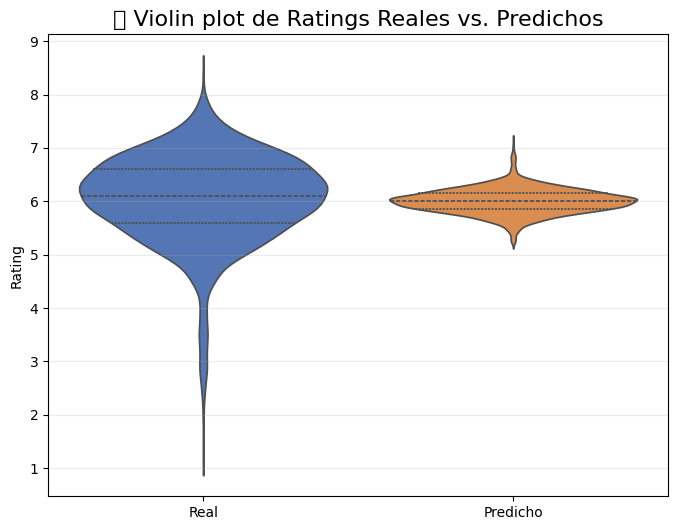

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Preparar datos de test ---
test_user = torch.tensor(df_test_final_filtrado["user_id"].values, dtype=torch.long)
test_item = torch.tensor(df_test_final_filtrado["item_id"].values, dtype=torch.long)
test_time = torch.tensor(df_test_final_filtrado["time_idx"].values, dtype=torch.long)
y_true = df_test_final_filtrado["Rating"].values

# --- Predicciones ---
final_model.eval()
with torch.no_grad():
    y_pred = final_model(test_user, test_item, test_time, use_dot=True).cpu().numpy()

# --- DataFrame para violin plot ---
df_violin = pd.DataFrame({
    "Rating": np.concatenate([y_true, y_pred]),
    "Tipo": (["Real"] * len(y_true)) + (["Predicho"] * len(y_pred))
})

# --- Violin plot ---
plt.figure(figsize=(8, 6))
sns.violinplot(x="Tipo", y="Rating", data=df_violin, palette=["#4472C4", "#F08B39"], inner="quartile")
plt.title("🎻 Violin plot de Ratings Reales vs. Predichos", fontsize=16)
plt.ylabel("Rating")
plt.xlabel("")
plt.grid(axis="y", alpha=0.25)
plt.show()


In [ ]:
recomendados = recomendar_jugadores_equipo_nombre(
    nombre_equipo="Racing",
    año=2025,                               # <--- ¡Pasa el año real!
    jugadores_filtrados=jugadores_filtrados,
    modelo=final_model,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    df_cv=df_cv,
    top_k=10
)
print(recomendados)


           Nombre ID Jugador  predicted_rating
0      Y. MOUKOKO     409654          6.334970
1       J. ELORDI     378866          6.315914
2            HULK      22295          6.293351
3  GERMÁN PARREÑO     112079          6.292977
4       S. NANASI     432796          6.284577
5      C. RONALDO      28185          6.272544
6    M. GREENWOOD     427813          6.261357
7      D. DOUDERA     348618          6.256732
8     LUIS SUÁREZ      29685          6.254517
9    J. MIRITELLO     896280          6.253072


In [ ]:
def resumen_parametros_embedding_completo(model):
    resumen = {}

    # Factores latentes
    for name, embedding in [
        ("user_factors", model.user_factors),
        ("item_factors", model.item_factors),
    ]:
        pesos = embedding.weight.detach().cpu().numpy()
        media = pesos.mean(axis=0)
        std = pesos.std(axis=0)
        resumen[name] = {"media": media, "std": std}

    # Sesgos simples
    for name, embedding in [
        ("user_bias", model.user_bias),
        ("item_bias", model.item_bias),
    ]:
        pesos = embedding.weight.detach().cpu().numpy().flatten()
        resumen[name] = {
            "media": pesos.mean(),
            "std": pesos.std()
        }

    # Sesgos temporales (user-time y item-time)
    for name, embedding in [
        #("user_time_bias", model.user_time_bias),
        ("item_time_bias", model.item_time_bias),
    ]:
        pesos = embedding.weight.detach().cpu().numpy().flatten()
        resumen[name] = {
            "media": pesos.mean(),
            "std": pesos.std()
        }

    return resumen

# Ejecutar
resumen = resumen_parametros_embedding_completo(final_model)

# Mostrar
for name, stats in resumen.items():
    print(f"\n📌 {name.upper()}")
    if isinstance(stats["media"], np.ndarray):
        for i, (m, s) in enumerate(zip(stats["media"], stats["std"])):
            print(f"  Dim {i}: media = {m:.4f}, std = {s:.4f}")
    else:
        print(f"  Media = {stats['media']:.4f}, STD = {stats['std']:.4f}")



📌 USER_FACTORS
  Dim 0: media = -0.0000, std = 0.1342
  Dim 1: media = -0.0007, std = 0.1394
  Dim 2: media = 0.0009, std = 0.1351
  Dim 3: media = 0.0020, std = 0.1271
  Dim 4: media = -0.0007, std = 0.1215
  Dim 5: media = -0.0002, std = 0.1337
  Dim 6: media = -0.0003, std = 0.1295
  Dim 7: media = -0.0005, std = 0.1263
  Dim 8: media = 0.0011, std = 0.1314
  Dim 9: media = 0.0025, std = 0.1307

📌 ITEM_FACTORS
  Dim 0: media = -0.0016, std = 0.1238
  Dim 1: media = 0.0016, std = 0.1303
  Dim 2: media = -0.0031, std = 0.1277
  Dim 3: media = 0.0005, std = 0.1142
  Dim 4: media = -0.0005, std = 0.1152
  Dim 5: media = 0.0017, std = 0.1220
  Dim 6: media = -0.0012, std = 0.1192
  Dim 7: media = -0.0038, std = 0.1190
  Dim 8: media = -0.0031, std = 0.1201
  Dim 9: media = 0.0024, std = 0.1242

📌 USER_BIAS
  Media = -0.0023, STD = 0.0738

📌 ITEM_BIAS
  Media = 0.0202, STD = 0.1096

📌 ITEM_TIME_BIAS
  Media = 0.0076, STD = 0.1479


In [ ]:
def recomendar_jugadores_equipo_nombre_MFconTiempo(
    nombre_equipo,
    año,                               # Año real (ej: 2025)
    jugadores_filtrados,
    modelo,
    user_encoder, item_encoder,
    df_cv,                             # DataFrame de entrenamiento (para mapeo de años)
    top_k=10
):
    # --- Codificar equipo ---
    if nombre_equipo not in item_encoder.classes_:
        print(f"Equipo '{nombre_equipo}' no encontrado en item_encoder.")
        return pd.DataFrame()
    equipo_id_idx = item_encoder.transform([nombre_equipo])[0]

    # --- Codificar año ---
    time_categories = df_cv["Año_Orden"].astype("category").cat.categories
    if año not in time_categories.values:
        print(f"Año {año} no está en las categorías del modelo.")
        return pd.DataFrame()
    time_idx = pd.Categorical([año], categories=time_categories).codes[0]

    # --- Jugadores válidos ---
    jugadores_df = jugadores_filtrados[['Nombre', 'ID Jugador']].drop_duplicates('ID Jugador')
    nombres = jugadores_df['Nombre'].tolist()
    ids_jugadores = jugadores_df['ID Jugador'].tolist()
    ids_jugadores_validos = [jid for jid in ids_jugadores if jid in user_encoder.classes_]
    nombres_validos = [nombres[i] for i, jid in enumerate(ids_jugadores) if jid in user_encoder.classes_]
    if len(ids_jugadores_validos) == 0:
        print("No hay jugadores conocidos por el modelo para recomendar.")
        return pd.DataFrame()
    usuarios_idx = user_encoder.transform(ids_jugadores_validos)

    import torch
    user_tensor = torch.tensor(usuarios_idx, dtype=torch.long)
    item_tensor = torch.tensor([equipo_id_idx] * len(usuarios_idx), dtype=torch.long)
    time_tensor = torch.tensor([time_idx] * len(usuarios_idx), dtype=torch.long)

    modelo.eval()
    with torch.no_grad():
        preds = modelo(user_tensor, item_tensor, time_tensor, use_dot=True).cpu().numpy()

    result = pd.DataFrame({
        'Nombre': nombres_validos,
        'ID Jugador': ids_jugadores_validos,
        'predicted_rating': preds
    }).sort_values('predicted_rating', ascending=False).reset_index(drop=True)

    return result.head(top_k)


In [ ]:
recomendados = recomendar_jugadores_equipo_nombre_MFconTiempo(
    nombre_equipo="Racing",
    año=2025,
    jugadores_filtrados=jugadores_filtrados,
    modelo=final_model,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    df_cv=df_cv,
    top_k=5
)
print(recomendados)


           Nombre ID Jugador  predicted_rating
0      Y. MOUKOKO     409654          6.334970
1       J. ELORDI     378866          6.315914
2            HULK      22295          6.293351
3  GERMÁN PARREÑO     112079          6.292977
4       S. NANASI     432796          6.284577


In [ ]:
def debug_top_recomendado(
    recomendados_df,
    nombre_equipo,
    año,
    jugadores_filtrados,
    df,
    user_encoder,
    item_encoder,
    modelo,
    df_cv,
    use_dot=True
):
    if recomendados_df.empty:
        print("No hay recomendados para debuguear.")
        return

    # Tomamos el top 1 recomendado
    row = recomendados_df.iloc[0]
    nombre_jugador = row['Nombre']
    id_jugador = row['ID Jugador']
    predicted_score = row['predicted_rating']

    print(f"\n🕵️‍♂️ Debug Top Recomendado:")
    print(f"Nombre    : {nombre_jugador}")
    print(f"ID Jugador: {id_jugador}")
    print(f"Score DF  : {predicted_score:.6f}")

    # Obtener user_id interno
    user_id = user_encoder.transform([id_jugador])[0]
    item_id = item_encoder.transform([nombre_equipo])[0]

    # Codificar año como índice temporal
    time_categories = df_cv["Año_Orden"].astype("category").cat.categories
    if año not in time_categories.values:
        print(f"Año {año} no está en las categorías.")
        return
    time_idx = pd.Categorical([año], categories=time_categories).codes[0]

    user_time_index = user_id * modelo.num_times + time_idx
    item_time_index = item_id * modelo.num_times + time_idx

    user_tensor = torch.tensor([user_id], dtype=torch.long)
    item_tensor = torch.tensor([item_id], dtype=torch.long)
    time_tensor = torch.tensor([time_idx], dtype=torch.long)
    user_time_tensor = torch.tensor([user_time_index], dtype=torch.long)
    item_time_tensor = torch.tensor([item_time_index], dtype=torch.long)

    modelo.eval()
    with torch.no_grad():
        try:
            pred_directo = modelo(user_tensor, item_tensor, time_tensor, use_dot=use_dot).item()
        except TypeError:
            pred_directo = modelo(user_tensor, item_tensor, time_tensor).item()

        mu = modelo.mu.item() if hasattr(modelo.mu, 'item') else float(modelo.mu)
        b_u = modelo.user_bias(user_tensor).item()
        b_i = modelo.item_bias(item_tensor).item()
        try:
            b_it = modelo.item_time_bias(item_time_tensor).item()
        except AttributeError:
            b_it = 0.0
        if use_dot:
            dot = (modelo.user_factors(user_tensor) * modelo.item_factors(item_tensor)).sum().item()
        else:
            dot = 0.0
        pred_manual = mu + b_u + b_i + b_it + dot

    print(f"\n--- Cálculo Manual ---")
    print(f"μ (media global)        : {mu:.4f}")
    print(f"b_u (sesgo jugador)     : {b_u:.4f}")
    print(f"b_i (sesgo equipo)      : {b_i:.4f}")
    print(f"b_it (sesgo equipo-año) : {b_it:.4f}")
    print(f"pu · qi (producto dot)  : {dot:.4f}")
    print(f"Predicción MANUAL       : {pred_manual:.6f}")
    print(f"Predicción MODELO       : {pred_directo:.6f}")
    print(f"Predicción DF           : {predicted_score:.6f}")
    print(f"Dif Manual - Modelo     : {abs(pred_manual - pred_directo):.8f}")
    print(f"Dif Modelo - DF         : {abs(pred_directo - predicted_score):.8f}")

    if abs(pred_manual - pred_directo) < 1e-5 and abs(pred_directo - predicted_score) < 1e-5:
        print("\n✅ ¡Todo coincide perfectamente!")
    else:
        print("\n⚠️ ¡Hay alguna diferencia! Revisá mapeos de IDs y encoders.")



In [ ]:
debug_top_recomendado(
    recomendados,
    nombre_equipo="Racing",
    año=2025,
    jugadores_filtrados=jugadores_filtrados,
    df=df,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    modelo=final_model,
    df_cv=df_cv,
    use_dot=True
)



🕵️‍♂️ Debug Top Recomendado:
Nombre    : Y. MOUKOKO
ID Jugador: 409654
Score DF  : 6.334970

--- Cálculo Manual ---
μ (media global)        : 6.0260
b_u (sesgo jugador)     : 0.1665
b_i (sesgo equipo)      : 0.0503
b_it (sesgo equipo-año) : -0.0303
pu · qi (producto dot)  : 0.1224
Predicción MANUAL       : 6.334971
Predicción MODELO       : 6.334970
Predicción DF           : 6.334970
Dif Manual - Modelo     : 0.00000024
Dif Modelo - DF         : 0.00000000

✅ ¡Todo coincide perfectamente!


In [ ]:
user_id_encoder = user_encoder.transform([real_id])[0]
print(f"user_id por encoder: {user_id_encoder}, user_id por df: {user_id}")


user_id por encoder: 2326, user_id por df: 2329


In [ ]:
train_user = torch.tensor(df["user_id"].values, dtype=torch.long)
train_item = torch.tensor(df["item_id"].values, dtype=torch.long)
train_time = torch.tensor(df["time_idx"].values, dtype=torch.long)
train_rating = torch.tensor(df["Rating"].values, dtype=torch.float32)

train_dataset = TensorDataset(train_user, train_item, train_time, train_rating)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# --- Crear modelo ---
final_model = MFModel(
    num_users=df["user_id"].nunique(),
    num_items=df["item_id"].nunique(),
    num_times=df_cv["time_idx"].nunique(),
    embedding_dim=3,
    lambda_reg=best_params[1],
    global_mean=df_cv["Rating"].mean()
)

# --- Etapa 1: entrenar solo los sesgos ---
for param in [final_model.user_factors, final_model.item_factors]:
    param.weight.requires_grad = False

optimizer_bias = torch.optim.Adam(
    filter(lambda p: p.requires_grad, final_model.parameters()), lr=0.01
)

print("🔧 Etapa 1: Entrenando solo sesgos (sin dot)")
for epoch in range(10):
    final_model.train()
    total_loss = 0
    for user, item, time, rating in train_loader:
        preds = final_model(user, item, time, use_dot=False)
        loss = final_model.loss(preds, rating, user, item, time, use_dot=False)
        optimizer_bias.zero_grad()
        loss.backward()
        optimizer_bias.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/10, Loss: {total_loss:.4f}")

# --- Etapa 2: entrenar embeddings (con dot) ---
for param in [final_model.user_factors, final_model.item_factors]:
    param.weight.requires_grad = True

optimizer_all = torch.optim.Adam(final_model.parameters(), lr=best_params[2])

print("\n🧠 Etapa 2: Entrenando todo el modelo (con dot)")
for epoch in range(10):
    final_model.train()
    total_loss = 0
    for user, item, time, rating in train_loader:
        preds = final_model(user, item, time, use_dot=True)
        loss = final_model.loss(preds, rating, user, item, time, use_dot=True)
        optimizer_all.zero_grad()
        loss.backward()
        optimizer_all.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/10, Loss: {total_loss:.4f}")

🔧 Etapa 1: Entrenando solo sesgos (sin dot)


IndexError: index out of range in self

In [ ]:
recomendados = recomendar_jugadores_equipo_nombre(
    nombre_equipo="Sevilla",
    año=2025,                               # <--- ¡Pasa el año real!
    jugadores_filtrados=jugadores_filtrados,
    modelo=final_model,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    df_cv=df_cv,
    top_k=5
)
print(recomendados)


In [ ]:
debug_top_recomendado(
    recomendados,
    nombre_equipo="Chelsea",
    año=2025,
    jugadores_filtrados=jugadores_filtrados,
    df=df,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    modelo=final_model,
    df_cv=df,
    use_dot=True
)


In [ ]:
recomendados = recomendar_jugadores_equipo_nombre_MFconTiempo(
    nombre_equipo="Milan",
    año=2025,
    jugadores_filtrados=jugadores_filtrados,
    modelo=final_model,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    df_cv=df,
    top_k=5
)
print(recomendados)


## Modelo con Yj, vector que tiene en cuenta los jugadores que pasaron por el equipo para los nuevos jugadores

In [88]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd

# --- Preparar tensores ---
train_user = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
train_item = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
train_time = torch.tensor(df_cv["time_idx"].values, dtype=torch.long)
train_rating = torch.tensor(df_cv["Rating"].values, dtype=torch.float32)

train_dataset = TensorDataset(train_user, train_item, train_time, train_rating)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# --- Diccionario de usuarios que evaluaron cada ítem (item_to_users) ---
item_to_users = df_cv.groupby("item_id")["user_id"].apply(list).to_dict()

# --- Modelo con vecindario de jugadores ---
class MFModelSVDpp_UserNeighborhood(nn.Module):
    def __init__(self, num_users, num_items, num_times, embedding_dim, lambda_reg, global_mean):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_times = num_times
        self.lambda_reg = lambda_reg
        self.mu = global_mean

        self.user_factors = nn.Embedding(num_users, embedding_dim)
        self.item_factors = nn.Embedding(num_items, embedding_dim)
        self.y_user = nn.Embedding(num_users, embedding_dim)  # y_j por jugador

        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.user_time_bias = nn.Embedding(num_users * num_times, 1)
        self.item_time_bias = nn.Embedding(num_items * num_times, 1)

        std = 1.0 / embedding_dim**0.5
        for emb in [self.user_factors, self.item_factors, self.y_user, self.user_bias, self.item_bias]:
            nn.init.normal_(emb.weight, mean=0.0, std=std)
        nn.init.normal_(self.user_time_bias.weight, mean=0.0, std=1e-3)
        nn.init.normal_(self.item_time_bias.weight, mean=0.0, std=1e-3)

    def forward(self, user_ids, item_ids, time_ids, neighbor_users_list=None, use_dot=True):
        user_time_index = user_ids * self.num_times + time_ids
        item_time_index = item_ids * self.num_times + time_ids

        b_u = self.user_bias(user_ids).squeeze()
        b_i = self.item_bias(item_ids).squeeze()
        b_ut = self.user_time_bias(user_time_index).squeeze()
        b_it = self.item_time_bias(item_time_index).squeeze()

        if not use_dot:
            dot = 0.0
        else:
            p_u = self.user_factors(user_ids)
            q_i = self.item_factors(item_ids)

            y_sum = []
            for neighbor_users in neighbor_users_list:
                if len(neighbor_users) == 0:
                    y_sum.append(torch.zeros(self.embedding_dim, device=user_ids.device))
                else:
                    u_tensor = torch.tensor(neighbor_users, dtype=torch.long, device=user_ids.device)
                    y_vecs = self.y_user(u_tensor)
                    y_mean = y_vecs.sum(dim=0) / np.sqrt(len(neighbor_users))
                    y_sum.append(y_mean)
            y_sum = torch.stack(y_sum)

            user_vector = p_u + y_sum
            dot = (user_vector * q_i).sum(1)

        return self.mu + b_u + b_i + b_ut + b_it + dot

    def loss(self, preds, ratings, user_ids, item_ids, time_ids, use_dot=True):
        user_time_index = user_ids * self.num_times + time_ids
        item_time_index = item_ids * self.num_times + time_ids

        reg = self.lambda_reg * (
            10*self.user_bias(user_ids).norm(2).pow(2) +
            self.item_bias(item_ids).norm(2).pow(2) +
            5*self.user_time_bias(user_time_index).norm(2).pow(2) +
            self.item_time_bias(item_time_index).norm(2).pow(2)
        )

        if use_dot:
            reg += self.lambda_reg * 0.025 * (
                self.user_factors(user_ids).norm(2).pow(2) +
                self.item_factors(item_ids).norm(2).pow(2)
            )

        mse = nn.functional.mse_loss(preds, ratings)
        return mse + reg.mean()

# --- Crear modelo ---
final_model = MFModelSVDpp_UserNeighborhood(
    num_users=df_cv["user_id"].nunique(),
    num_items=df_cv["item_id"].nunique(),
    num_times=df_cv["time_idx"].nunique(),
    embedding_dim=10,
    lambda_reg=best_params[1],
    global_mean=df_cv["Rating"].mean()
)

# --- Etapa 1: entrenar solo sesgos ---
for param in [final_model.user_factors, final_model.item_factors, final_model.y_user]:
    param.weight.requires_grad = False

optimizer_bias = torch.optim.Adam(filter(lambda p: p.requires_grad, final_model.parameters()), lr=0.01)

print("🔧 Etapa 1: Entrenando solo sesgos (sin dot)")
for epoch in range(10):
    final_model.train()
    total_loss = 0
    for user, item, time, rating in train_loader:
        preds = final_model(user, item, time, use_dot=False)
        loss = final_model.loss(preds, rating, user, item, time, use_dot=False)
        optimizer_bias.zero_grad()
        loss.backward()
        optimizer_bias.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/10, Loss: {total_loss:.4f}")

# --- Etapa 2: entrenar todo ---
for param in [final_model.user_factors, final_model.item_factors, final_model.y_user]:
    param.weight.requires_grad = True

optimizer_all = torch.optim.Adam(final_model.parameters(), lr=best_params[2])

print("\n🧠 Etapa 2: Entrenando todo el modelo (con dot y vecindario por jugador)")
for epoch in range(5):
    final_model.train()
    total_loss = 0
    for user, item, time, rating in train_loader:
        neighbor_users_list = [item_to_users.get(int(i), []) for i in item.tolist()]
        preds = final_model(user, item, time, neighbor_users_list=neighbor_users_list, use_dot=True)
        loss = final_model.loss(preds, rating, user, item, time, use_dot=True)
        optimizer_all.zero_grad()
        loss.backward()
        optimizer_all.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/5, Loss: {total_loss:.4f}")


🔧 Etapa 1: Entrenando solo sesgos (sin dot)
Epoch 1/10, Loss: 2081.1503
Epoch 2/10, Loss: 636.4364
Epoch 3/10, Loss: 329.9530
Epoch 4/10, Loss: 255.6607
Epoch 5/10, Loss: 242.8382
Epoch 6/10, Loss: 244.0228
Epoch 7/10, Loss: 250.7794
Epoch 8/10, Loss: 258.8335
Epoch 9/10, Loss: 264.5735
Epoch 10/10, Loss: 262.8010

🧠 Etapa 2: Entrenando todo el modelo (con dot y vecindario por jugador)
Epoch 1/5, Loss: 391.2879
Epoch 2/5, Loss: 267.4086
Epoch 3/5, Loss: 256.4340
Epoch 4/5, Loss: 262.6688
Epoch 5/5, Loss: 278.0222


In [89]:
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau
import numpy as np

# --- Preparar tensores de test ---
test_user = torch.tensor(df_test_final_filtrado["user_id"].values, dtype=torch.long)
test_item = torch.tensor(df_test_final_filtrado["item_id"].values, dtype=torch.long)
test_time = torch.tensor(df_test_final_filtrado["time_idx"].values, dtype=torch.long)
test_rating = torch.tensor(df_test_final_filtrado["Rating"].values, dtype=torch.float32)

# --- Crear lista de jugadores que evaluaron cada equipo (item_to_users en test) ---
neighbor_users_test = [item_to_users.get(int(i), []) for i in test_item.tolist()]

# --- Evaluación ---
final_model.eval()
with torch.no_grad():
    pred_test = final_model(test_user, test_item, test_time, neighbor_users_list=neighbor_users_test, use_dot=True).cpu().numpy()
    true_test = test_rating.cpu().numpy()

# --- Métricas ---
rmse = np.sqrt(np.mean((pred_test - true_test) ** 2))
mae = mean_absolute_error(true_test, pred_test)
r2 = r2_score(true_test, pred_test)
spearman_corr, _ = spearmanr(true_test, pred_test)
kendall_corr, _ = kendalltau(true_test, pred_test)
pmae_value = pmae(true_test, pred_test)

# --- Resultados ---
print("\n📊 Evaluación en test final (2025, con vecindario de jugadores para cada equipo):")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")
print(f"pMAE        : {pmae_value:.2f}")

resultados_metricas.append({
          "Modelo": "SVD++",      # o hiperparámetros, etc.
          "RMSE": rmse,
          "MAE": mae,
          "R2": r2,
          "Spearman": spearman_corr,
          "Kendall": kendall_corr,
          "PMAE": pmae_value
          })



📊 Evaluación en test final (2025, con vecindario de jugadores para cada equipo):
RMSE        : 0.8461
MAE         : 0.6433
R²          : -0.0161
Spearman ρ  : 0.1421
Kendall τ   : 0.0958
pMAE        : 11.93


In [90]:
# Train
train_user = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
train_item = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
train_time = torch.tensor(df_cv["time_idx"].values, dtype=torch.long)

# Test
test_user = torch.tensor(df_test_final_filtrado["user_id"].values, dtype=torch.long)
test_item = torch.tensor(df_test_final_filtrado["item_id"].values, dtype=torch.long)
test_time = torch.tensor(df_test_final_filtrado["time_idx"].values, dtype=torch.long)

neighbor_users_list_train = [item_to_users.get(int(i), []) for i in train_item.tolist()]
neighbor_users_list_test = [item_to_users.get(int(i), []) for i in test_item.tolist()]



pred_cv = guardar_preds_modelo(
    df=df_cv,
    model=final_model,
    user_tensor=train_user,
    item_tensor=train_item,
    time_tensor=train_time,
    neighbor_users_list=neighbor_users_list_train,
    name_columna="temp_SVDpp"
)["temp_SVDpp"]

pred_test = guardar_preds_modelo(
    df=df_test_final_filtrado,
    model=final_model,
    user_tensor=test_user,
    item_tensor=test_item,
    time_tensor=test_time,
    neighbor_users_list=neighbor_users_list_test,
    name_columna="temp_SVDpp"
)["temp_SVDpp"]


df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds,
    df_test_preds,
    nombre_columna="pred_SVDpp",
    preds_cv=pred_cv,
    preds_test=pred_test
)



✅ Predicciones guardadas como 'temp_SVDpp'
✅ Predicciones guardadas como 'temp_SVDpp'
✅ Columna 'pred_SVDpp' agregada correctamente.


In [ ]:
def recomendar_jugadores_equipo_vecindario(
    nombre_equipo,
    año,
    jugadores_filtrados,
    modelo,
    user_encoder,
    item_encoder,
    df_cv,
    top_k=5
):
    # Codificar equipo
    if nombre_equipo not in item_encoder.classes_:
        print(f"Equipo '{nombre_equipo}' no encontrado en item_encoder.")
        return pd.DataFrame()
    equipo_id = item_encoder.transform([nombre_equipo])[0]

    # Codificar año a time_idx
    time_categories = df_cv["Año_Orden"].astype("category").cat.categories
    if año not in time_categories.values:
        print(f"Año {año} no está en las categorías del modelo.")
        return pd.DataFrame()
    time_idx = pd.Categorical([año], categories=time_categories).codes[0]

    # Jugadores únicos y conocidos por el encoder
    jugadores_df = jugadores_filtrados[['Nombre', 'ID Jugador']].drop_duplicates('ID Jugador')
    nombres = jugadores_df['Nombre'].tolist()
    ids_jugadores = jugadores_df['ID Jugador'].tolist()
    ids_jugadores_validos = [jid for jid in ids_jugadores if jid in user_encoder.classes_]
    nombres_validos = [nombres[i] for i, jid in enumerate(ids_jugadores) if jid in user_encoder.classes_]
    if len(ids_jugadores_validos) == 0:
        print("No hay jugadores conocidos por el modelo para recomendar.")
        return pd.DataFrame()
    usuarios_idx = user_encoder.transform(ids_jugadores_validos)

    # Tensores
    user_tensor = torch.tensor(usuarios_idx, dtype=torch.long)
    item_tensor = torch.tensor([equipo_id] * len(usuarios_idx), dtype=torch.long)
    time_tensor = torch.tensor([time_idx] * len(usuarios_idx), dtype=torch.long)

    # Vecindario: todos los jugadores que ya jugaron en ese equipo
    item_to_users = df_cv.groupby("item_id")["user_id"].apply(list).to_dict()
    neighbor_users_equipo = item_to_users.get(equipo_id, [])

    # Lista de vecindarios para cada jugador (en este caso todos igual: el equipo objetivo)
    neighbor_users_list = [neighbor_users_equipo for _ in usuarios_idx]

    # Predicción
    modelo.eval()
    with torch.no_grad():
        preds = modelo(
            user_tensor, item_tensor, time_tensor,
            neighbor_users_list=neighbor_users_list, use_dot=True
        ).cpu().numpy()

    # DataFrame de resultados
    result = pd.DataFrame({
        'Nombre': nombres_validos,
        'ID Jugador': ids_jugadores_validos,
        'predicted_rating': preds
    }).sort_values('predicted_rating', ascending=False).reset_index(drop=True)

    return result.head(top_k)


# Redes neuronales para predecir y crear embeddings

## Autoencoder para embeddings

In [ ]:
features_jugadores = [
    "Asistencias", "Goles", "Minutos Jugados", "Minutos Por Partido", "Partidos Jugados"
]
from sklearn.preprocessing import StandardScaler

df_feats = jugadores_filtrados[["ID Jugador"] + features_jugadores].dropna()
scaler = StandardScaler()
X = scaler.fit_transform(df_feats[features_jugadores])
import torch
import torch.nn as nn

class JugadorAutoencoder(nn.Module):
    def __init__(self, input_dim=5, embedding_dim=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

X_tensor = torch.tensor(X, dtype=torch.float32)
model = JugadorAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(100):
    model.train()
    output, _ = model(X_tensor)
    loss = loss_fn(output, X_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 10, Loss: 0.8914
Epoch 20, Loss: 0.5943
Epoch 30, Loss: 0.4969
Epoch 40, Loss: 0.4431
Epoch 50, Loss: 0.4125
Epoch 60, Loss: 0.3771
Epoch 70, Loss: 0.3310
Epoch 80, Loss: 0.2507
Epoch 90, Loss: 0.1418
Epoch 100, Loss: 0.1170


In [ ]:
model.eval()
with torch.no_grad():
    _, embeddings = model(X_tensor)
    df_embeddings = pd.DataFrame(embeddings.numpy(), index=df_feats["ID Jugador"], columns=["e1", "e2", "e3"])


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau

# --- 1. Preprocesar features para autoencoder ---
features_jugadores = ["Asistencias", "Goles", "Minutos Jugados", "Minutos Por Partido", "Partidos Jugados"]
df_feats = jugadores_filtrados[["ID Jugador"] + features_jugadores].dropna().drop_duplicates("ID Jugador")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_feats[features_jugadores])

# --- 2. Autoencoder ---
class JugadorAutoencoder(nn.Module):
    def __init__(self, input_dim=5, embedding_dim=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
autoencoder = JugadorAutoencoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(100):
    autoencoder.train()
    output, _ = autoencoder(X_tensor)
    loss = loss_fn(output, X_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# --- 3. Embeddings por jugador ---
autoencoder.eval()
with torch.no_grad():
    _, embeddings = autoencoder(X_tensor)

df_embeddings = pd.DataFrame(embeddings.numpy(), columns=["z1", "z2", "z3"])
df_embeddings["ID Jugador"] = df_feats["ID Jugador"].values

# --- 4. Preparar entrenamiento con df_cv ---
equipos = df_cv["Equipo"].unique()
equipo2idx = {eq: i for i, eq in enumerate(equipos)}

df_cv_embed = df_cv.merge(df_embeddings, on="ID Jugador", how="inner")
df_cv_embed = df_cv_embed[df_cv_embed["Equipo"].isin(equipo2idx)]

X_jugador = df_cv_embed[["z1", "z2", "z3"]].values
X_equipo = df_cv_embed["Equipo"].map(equipo2idx).values
y = df_cv_embed["Rating"].values

# --- 5. Modelo rating jugador + equipo ---
class RatingPredictor(nn.Module):
    def __init__(self, embedding_dim_jugador=3, num_equipos=None, embedding_dim_equipo=5):
        super().__init__()
        self.equipo_embedding = nn.Embedding(num_equipos, embedding_dim_equipo)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim_jugador + embedding_dim_equipo, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, z_jugador, idx_equipo):
        z_equipo = self.equipo_embedding(idx_equipo)
        x = torch.cat([z_jugador, z_equipo], dim=1)
        return self.mlp(x).squeeze()

# --- 6. Entrenamiento ---
X_j = torch.tensor(X_jugador, dtype=torch.float32)
X_e = torch.tensor(X_equipo, dtype=torch.long)
y_tensor = torch.tensor(y, dtype=torch.float32)

model = RatingPredictor(num_equipos=len(equipo2idx))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(100):
    model.train()
    pred = model(X_j, X_e)
    loss = loss_fn(pred, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"[Entrenamiento] Epoch {epoch+1}, Loss: {loss.item():.4f}")

# --- 7. Test ---
df_test_embed = df_test_final_filtrado.merge(df_embeddings, on="ID Jugador", how="inner")
df_test_embed = df_test_embed[df_test_embed["Equipo"].isin(equipo2idx)]

X_j_test = torch.tensor(df_test_embed[["z1", "z2", "z3"]].values, dtype=torch.float32)
X_e_test = torch.tensor(df_test_embed["Equipo"].map(equipo2idx).values, dtype=torch.long)

model.eval()
with torch.no_grad():
    pred_test = model(X_j_test, X_e_test).numpy()

df_test_embed["Rating_Predicho"] = pred_test

# --- 8. Métricas de evaluación ---
true_ratings = df_test_embed["Rating"].values
predicted_ratings = df_test_embed["Rating_Predicho"].values

import numpy as np
rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
mae = mean_absolute_error(true_ratings, predicted_ratings)
r2 = r2_score(true_ratings, predicted_ratings)
spearman_corr, _ = spearmanr(true_ratings, predicted_ratings)
kendall_corr, _ = kendalltau(true_ratings, predicted_ratings)

print("\n📊 Evaluación en test:")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")


[Entrenamiento] Epoch 10, Loss: 31.5464
[Entrenamiento] Epoch 20, Loss: 21.2081
[Entrenamiento] Epoch 30, Loss: 9.4072
[Entrenamiento] Epoch 40, Loss: 4.4536
[Entrenamiento] Epoch 50, Loss: 3.0287
[Entrenamiento] Epoch 60, Loss: 2.1978
[Entrenamiento] Epoch 70, Loss: 1.8339
[Entrenamiento] Epoch 80, Loss: 1.5442
[Entrenamiento] Epoch 90, Loss: 1.3266
[Entrenamiento] Epoch 100, Loss: 1.1730

📊 Evaluación en test:
RMSE        : 1.1319
MAE         : 0.8388
R²          : -0.8187
Spearman ρ  : 0.0481
Kendall τ   : 0.0316


## Red neuronal que predice ratings (también me pueden servir sus embeddings para similaridad)

In [ ]:
# Invertir codificación
df_cv = df_cv.merge(jugadores_filtrados[["ID Jugador", "user_id"]].drop_duplicates(), on="user_id", how="left")
df_test_final_filtrado = df_test_final_filtrado.merge(jugadores_filtrados[["ID Jugador", "user_id"]].drop_duplicates(), on="user_id", how="left")


features = [
    "Asistencias", "Goles", "Minutos Jugados", "Minutos Por Partido", "Partidos Jugados"
]

# Agrupar estadísticas por jugador
df_stats_global = jugadores_filtrados.groupby("ID Jugador", as_index=False).agg({
    "Asistencias": "mean",
    "Goles": "mean",
    "Minutos Jugados": "mean",
    "Minutos Por Partido": "mean",
    "Partidos Jugados": "mean",
    "Rating": "mean"
}).dropna()

# Separar IDs
jugadores_train = df_cv["ID Jugador"].unique()
jugadores_test = df_test_final_filtrado["ID Jugador"].unique()

# Separar stats
df_train_stats = df_stats_global[df_stats_global["ID Jugador"].isin(jugadores_train)]
df_test_stats = df_stats_global[df_stats_global["ID Jugador"].isin(jugadores_test)]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(df_train_stats[features])
y_train = df_train_stats["Rating"].values

X_test = scaler.transform(df_test_stats[features])
y_test = df_test_stats["Rating"].values

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



KeyError: "['user_id'] not in index"

In [ ]:
class JugadorPredictor(nn.Module):
    def __init__(self, input_dim=5, embedding_dim=3):
        super().__init__()
        self.embedder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, embedding_dim),
            nn.ReLU()
        )
        self.predictor = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        z = self.embedder(x)
        y_hat = self.predictor(z)
        return y_hat.squeeze(), z

# Instanciar y entrenar
model = JugadorPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(200):
    model.train()
    y_pred, _ = model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 20, Loss: 29.9959
Epoch 40, Loss: 7.2555
Epoch 60, Loss: 3.6482
Epoch 80, Loss: 1.6407
Epoch 100, Loss: 0.5455
Epoch 120, Loss: 0.3146
Epoch 140, Loss: 0.2706
Epoch 160, Loss: 0.2368
Epoch 180, Loss: 0.2155
Epoch 200, Loss: 0.2019


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau

model.eval()
with torch.no_grad():
    y_pred_test, embeddings_test = model(X_test_tensor)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
spearman_corr, _ = spearmanr(y_test, y_pred_test)
kendall_corr, _ = kendalltau(y_test, y_pred_test)

print("\n📊 Evaluación en jugadores de test:")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")



📊 Evaluación en jugadores de test:
RMSE        : 0.4352
MAE         : 0.3294
R²          : 0.1483
Spearman ρ  : 0.4794
Kendall τ   : 0.3311


In [ ]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

model.eval()
with torch.no_grad():
    y_pred_test, embeddings_test = model(X_test_tensor)

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
spearman_corr, _ = spearmanr(y_test, y_pred_test)
kendall_corr, _ = kendalltau(y_test, y_pred_test)

print("\n📊 Evaluación en jugadores de test:")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")


In [ ]:
df_embeddings = pd.DataFrame(
    embeddings.numpy(),
    index=df_stats["ID Jugador"],
    columns=["e1", "e2", "e3"]
)


## Modelo de similaridad usando los embeddings

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau
from sklearn.metrics.pairwise import cosine_similarity

# --- 1. Matriz equipo × jugador (item_id = equipo, user_id = jugador) ---
matriz_equipos_jugadores = df_cv.pivot_table(index="item_id", columns="user_id", values="Rating", aggfunc="mean")

# --- 2. Similaridad entre jugadores a partir de embeddings del autoencoder ---
# (asegurate de tener entrenado df_embeddings con columnas ["ID Jugador", "z1", "z2", "z3"])

# Asegurarse de usar los mismos jugadores que están en la matriz
jugadores_ids = matriz_equipos_jugadores.columns
embedding_lookup = df_embeddings.set_index("ID Jugador")[["z1", "z2", "z3"]]
embedding_matrix = embedding_lookup.reindex(jugadores_ids).fillna(0).values

# Similaridad por coseno
similitud_base = cosine_similarity(embedding_matrix)
similitud_jugadores = pd.DataFrame(similitud_base, index=jugadores_ids, columns=jugadores_ids)

# --- 3. Aplicar ajuste de confianza ---
lambda_2 = 5
mask = matriz_equipos_jugadores.notna().astype(int)
nij_matrix = mask.T @ mask
similitud_jugadores = (nij_matrix / (nij_matrix + lambda_2)) * similitud_jugadores

# --- 4. Calcular sesgos ---
mu = df_cv["Rating"].mean()
bu = df_cv.groupby("item_id")["Rating"].mean() - mu  # item_id = equipo
bi = df_cv.groupby("user_id")["Rating"].mean() - mu  # user_id = jugador

# --- 5. Función de predicción ---
def predecir_rating_22_equipos(equipo_id, jugador_id):
    if jugador_id not in similitud_jugadores.columns or equipo_id not in matriz_equipos_jugadores.index:
        return mu

    jugadores_equipo = matriz_equipos_jugadores.loc[equipo_id]
    jugadores_rated = jugadores_equipo[jugadores_equipo.notna()]
    vecinos = similitud_jugadores[jugador_id][jugadores_rated.index]
    ratings = jugadores_rated[vecinos.index]

    b_u = bu.get(equipo_id, 0)
    b_j = bi.reindex(ratings.index).fillna(0)
    b_uj = mu + b_u + b_j

    diffs = ratings - b_uj
    numerador = (vecinos * diffs).sum()
    denominador = vecinos.abs().sum()

    if denominador == 0:
        return mu + b_u + bi.get(jugador_id, 0)

    return mu + b_u + bi.get(jugador_id, 0) + numerador / denominador

# --- 6. Evaluar en df_test_final_filtrado ---
y_true = []
y_pred = []

for _, row in df_test_final_filtrado.iterrows():
    equipo_id = row["item_id"]
    jugador_id = row["user_id"]
    true_rating = row["Rating"]
    pred_rating = predecir_rating_22_equipos(equipo_id, jugador_id)
    y_true.append(true_rating)
    y_pred.append(pred_rating)

# --- 7. Métricas ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
spearman_corr, _ = spearmanr(y_true, y_pred)
kendall_corr, _ = kendalltau(y_true, y_pred)

print("\n📊 Evaluación del modelo con embeddings del autoencoder:")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")



📊 Evaluación del modelo con embeddings del autoencoder:
RMSE        : 0.9229
MAE         : 0.6927
R²          : -0.2090
Spearman ρ  : 0.2122
Kendall τ   : 0.1449


# Modelos de vecindad

## Básico con correlación de Pearson

In [91]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau

# --- Hiperparámetro ---
lambda_2 = 3

# --- Matriz usuario × ítem (jugador × equipo) ---
matriz_usuarios_items = df_cv.pivot_table(index="user_id", columns="item_id", values="Rating", aggfunc="mean")

# --- Correlación de Pearson ---
rho = matriz_usuarios_items.corr(method="pearson")

# --- n_ij con producto matricial ---
mask = matriz_usuarios_items.notna().astype(int)
nij_matrix = mask.T @ mask

# --- Similitud ajustada ---
similitud_items = (nij_matrix / (nij_matrix + lambda_2)) * rho

# --- Media global ---
mu = df_cv["Rating"].mean()

# --- Sesgos por usuario e ítem ---
bu = df_cv.groupby("user_id")["Rating"].mean() - mu
bi = df_cv.groupby("item_id")["Rating"].mean() - mu

# --- Predicción centrada ---
def predecir_rating_22_corregido(user_id, item_id):
    if item_id not in similitud_items.columns or user_id not in matriz_usuarios_items.index:
        return mu

    items_usuario = matriz_usuarios_items.loc[user_id]
    items_rated = items_usuario[items_usuario.notna()]
    vecinos = similitud_items[item_id][items_rated.index]
    ratings = items_rated[vecinos.index]

    b_u = bu.get(user_id, 0)
    b_j = bi.reindex(ratings.index).fillna(0)
    b_uj = mu + b_u + b_j

    diffs = ratings - b_uj
    numerador = (vecinos * diffs).sum()
    denominador = vecinos.abs().sum()

    if denominador == 0:
        return mu + b_u + bi.get(item_id, 0)

    return mu + b_u + bi.get(item_id, 0) + numerador / denominador

# --- Evaluación ---
y_true = []
y_pred = []

for _, row in df_test_final_filtrado.iterrows():
    u = row["user_id"]
    i = row["item_id"]
    y_true.append(row["Rating"])
    y_pred.append(predecir_rating_22_corregido(u, i))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- Métricas ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
spearman_corr, _ = spearmanr(y_true, y_pred)
kendall_corr, _ = kendalltau(y_true, y_pred)
pmae_value = pmae(y_true, y_pred)

print("📊 Evaluación modelo de vecindad (punto 2.2) — corregido")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")
print(f"pMAE        : {pmae_value:.4f}")

resultados_metricas.append({
          "Modelo": "similaridad",      # o hiperparámetros, etc.
          "RMSE": rmse,
          "MAE": mae,
          "R2": r2,
          "Spearman": spearman_corr,
          "Kendall": kendall_corr,
          "PMAE": pmae_value
          })


📊 Evaluación modelo de vecindad (punto 2.2) — corregido
RMSE        : 1.0318
MAE         : 0.7723
R²          : -0.5110
Spearman ρ  : 0.1806
Kendall τ   : 0.1227
pMAE        : 14.0593


In [92]:
# Train


pred_cv = [
    predecir_rating_22_corregido(row["user_id"], row["item_id"])
    for _, row in df_cv.iterrows()
]

# Test
pred_test = [
    predecir_rating_22_corregido(row["user_id"], row["item_id"])
    for _, row in df_test_final_filtrado.iterrows()
]
df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds,
    df_test_preds,
    nombre_columna="pred_similaridad",
    preds_cv=pred_cv,
    preds_test=pred_test
)


✅ Columna 'pred_similaridad' agregada correctamente.


In [ ]:
def recomendar_jugadores_equipo_vecindad(
    nombre_equipo,
    jugadores_filtrados,
    user_encoder,
    item_encoder,
    top_k=5
):
    # Codificar equipo
    if nombre_equipo not in item_encoder.classes_:
        print(f"Equipo '{nombre_equipo}' no encontrado en item_encoder.")
        return pd.DataFrame()
    equipo_id = item_encoder.transform([nombre_equipo])[0]

    # Listado de jugadores válidos conocidos por el encoder
    jugadores_df = jugadores_filtrados[['Nombre', 'ID Jugador']].drop_duplicates('ID Jugador')
    nombres = jugadores_df['Nombre'].tolist()
    ids_jugadores = jugadores_df['ID Jugador'].tolist()
    ids_jugadores_validos = [jid for jid in ids_jugadores if jid in user_encoder.classes_]
    nombres_validos = [nombres[i] for i, jid in enumerate(ids_jugadores) if jid in user_encoder.classes_]
    if len(ids_jugadores_validos) == 0:
        print("No hay jugadores conocidos por el modelo para recomendar.")
        return pd.DataFrame()
    usuarios_idx = user_encoder.transform(ids_jugadores_validos)

    # Predecir rating para cada jugador en ese equipo
    predicciones = [
        predecir_rating_22_corregido(uid, equipo_id)
        for uid in usuarios_idx
    ]

    result = pd.DataFrame({
        'Nombre': nombres_validos,
        'ID Jugador': ids_jugadores_validos,
        'predicted_rating': predicciones
    }).sort_values('predicted_rating', ascending=False).reset_index(drop=True)

    return result.head(top_k)


In [ ]:
recomendados = recomendar_jugadores_equipo_vecindad(
    nombre_equipo="Sevilla",
    jugadores_filtrados=jugadores_filtrados,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    top_k=5
)
print(recomendados)


          Nombre ID Jugador  predicted_rating
0   L. HENDERSON  henderson          8.988768
1       S. MOORE     247622          8.468422
2     W. FALCONE     162352          8.457869
3      M. DITURO      90143          8.276333
4  SERGIO TEJERA      28187          8.213966


In [ ]:
##CON TODO EL DATASET

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau

# --- Hiperparámetro ---
lambda_2 = 3

# --- Matriz usuario × ítem (jugador × equipo) ---
matriz_usuarios_items = df.pivot_table(index="user_id", columns="item_id", values="Rating", aggfunc="mean")

# --- Correlación de Pearson ---
rho = matriz_usuarios_items.corr(method="pearson")

# --- n_ij con producto matricial ---
mask = matriz_usuarios_items.notna().astype(int)
nij_matrix = mask.T @ mask

# --- Similitud ajustada ---
similitud_items = (nij_matrix / (nij_matrix + lambda_2)) * rho

# --- Media global ---
mu = df["Rating"].mean()

# --- Sesgos por usuario e ítem ---
bu = df.groupby("user_id")["Rating"].mean() - mu
bi = df.groupby("item_id")["Rating"].mean() - mu

# --- Predicción centrada ---
def predecir_rating_22_corregido(user_id, item_id):
    if item_id not in similitud_items.columns or user_id not in matriz_usuarios_items.index:
        return mu

    items_usuario = matriz_usuarios_items.loc[user_id]
    items_rated = items_usuario[items_usuario.notna()]
    vecinos = similitud_items[item_id][items_rated.index]
    ratings = items_rated[vecinos.index]

    b_u = bu.get(user_id, 0)
    b_j = bi.reindex(ratings.index).fillna(0)
    b_uj = mu + b_u + b_j

    diffs = ratings - b_uj
    numerador = (vecinos * diffs).sum()
    denominador = vecinos.abs().sum()

    if denominador == 0:
        return mu + b_u + bi.get(item_id, 0)

    return mu + b_u + bi.get(item_id, 0) + numerador / denominador

In [ ]:
recomendados = recomendar_jugadores_equipo_vecindad(
    nombre_equipo="Milan",
    jugadores_filtrados=jugadores_filtrados,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    top_k=5
)
print(recomendados)


         Nombre ID Jugador  predicted_rating
0       F. ARCE     247627          9.768359
1   S. ESCUDERO      51968          9.428220
2   IAN MAATSEN     754269          9.362804
3  DIEGO CARLOS     232128          9.250428
4     C. ZAVALA     696772          9.195073


## Lo mismo pero invirtiendo roles jugador-equipo

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau

# --- Hiperparámetro ---
lambda_2 = 5

# --- Matriz equipo × jugador ---
matriz_equipos_jugadores = df_cv.pivot_table(index="item_id", columns="user_id", values="Rating", aggfunc="mean")

# --- Correlación de Pearson entre jugadores ---
rho = matriz_equipos_jugadores.corr(method="pearson")

# --- n_ij con producto matricial (cantidad de equipos que usaron ambos jugadores) ---
mask = matriz_equipos_jugadores.notna().astype(int)
nij_matrix = mask.T @ mask

# --- Similitud ajustada entre jugadores ---
similitud_jugadores = (nij_matrix / (nij_matrix + lambda_2)) * rho

# --- Media global ---
mu = df_cv["Rating"].mean()

# --- Sesgos por equipo y jugador ---
bu = df_cv.groupby("item_id")["Rating"].mean() - mu  # ahora user = equipo
bi = df_cv.groupby("user_id")["Rating"].mean() - mu  # ahora item = jugador

# --- Predicción centrada con usuarios = equipos ---
def predecir_rating_22_equipos(equipo_id, jugador_id):
    if jugador_id not in similitud_jugadores.columns or equipo_id not in matriz_equipos_jugadores.index:
        return mu

    jugadores_equipo = matriz_equipos_jugadores.loc[equipo_id]
    jugadores_rated = jugadores_equipo[jugadores_equipo.notna()]
    vecinos = similitud_jugadores[jugador_id][jugadores_rated.index]
    ratings = jugadores_rated[vecinos.index]

    b_u = bu.get(equipo_id, 0)
    b_j = bi.reindex(ratings.index).fillna(0)
    b_uj = mu + b_u + b_j

    diffs = ratings - b_uj
    numerador = (vecinos * diffs).sum()
    denominador = vecinos.abs().sum()

    if denominador == 0:
        return mu + b_u + bi.get(jugador_id, 0)

    return mu + b_u + bi.get(jugador_id, 0) + numerador / denominador


In [ ]:
# --- Evaluación ---
y_true = []
y_pred = []

for _, row in df_test_final_filtrado.iterrows():
    u = row["user_id"]
    i = row["item_id"]
    y_true.append(row["Rating"])
    y_pred.append(predecir_rating_22_equipos(u, i))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- Métricas ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
spearman_corr, _ = spearmanr(y_true, y_pred)
kendall_corr, _ = kendalltau(y_true, y_pred)

print("📊 Evaluación modelo de vecindad (punto 2.2) — corregido")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")

📊 Evaluación modelo de vecindad (punto 2.2) — corregido
RMSE        : 0.8841
MAE         : 0.6699
R²          : -0.1095
Spearman ρ  : 0.0397
Kendall τ   : 0.0303


## Con Wij y Cij

In [93]:
from collections import defaultdict
import numpy as np

# --- Inicialización ---
mu = df_cv["Rating"].mean()
user_bias = defaultdict(float)
item_bias = defaultdict(float)
pesos_w = defaultdict(lambda: np.random.normal(0, 0.01))
sesgo_c = defaultdict(lambda: np.random.normal(0, 0.01))

learning_rate = 0.01
reg = 0.02
epochs = 8

# --- R(u): ítems evaluados por cada usuario ---
ru_dict = df_cv.groupby("user_id").apply(lambda x: list(zip(x["item_id"], x["Rating"])))

# --- Entrenamiento ---
for epoch in range(epochs):
    total_loss = 0
    for _, row in df_cv.iterrows():
        u = row["user_id"]
        i = row["item_id"]
        r_ui = row["Rating"]

        # R(u) sin el ítem i
        ru = ru_dict[u]
        ru = [(j, r_uj) for j, r_uj in ru if j != i]

        bu = user_bias[u]
        bi = item_bias[i]
        base_pred = mu + bu + bi

        suma_vecindad = 0
        suma_sesgos_c = 0
        for j, r_uj in ru:
            b_uj = mu + bu + item_bias[j]
            key = (i, j)
            suma_vecindad += (r_uj - b_uj) * pesos_w[key]
            suma_sesgos_c += sesgo_c[key]

        pred = base_pred + suma_vecindad + suma_sesgos_c
        err = r_ui - pred
        total_loss += err**2

        # --- Actualizar parámetros ---
        user_bias[u] += learning_rate * (err - reg * bu)
        item_bias[i] += learning_rate * (err - reg * bi)

        for j, r_uj in ru:
            b_uj = mu + bu + item_bias[j]
            key = (i, j)
            pesos_w[key] += learning_rate * (err * (r_uj - b_uj) - reg * pesos_w[key])
            sesgo_c[key] += learning_rate * (err - reg * sesgo_c[key])

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")


<ipython-input-93-7929ac0fb8b4>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ru_dict = df_cv.groupby("user_id").apply(lambda x: list(zip(x["item_id"], x["Rating"])))


Epoch 1/8 - Loss: 22361.9444
Epoch 2/8 - Loss: 17770.8330
Epoch 3/8 - Loss: 14666.4625
Epoch 4/8 - Loss: 12373.4567
Epoch 5/8 - Loss: 10599.4341
Epoch 6/8 - Loss: 9185.7268
Epoch 7/8 - Loss: 8035.0208
Epoch 8/8 - Loss: 7082.9958


In [94]:
def predecir_vecindad_con_c(u, i):
    bu = user_bias[u]
    bi = item_bias[i]
    base = mu + bu + bi

    if u not in ru_dict:
        return base

    ajuste = 0
    suma_c = 0
    for j, r_uj in ru_dict[u]:
        if j == i: continue
        b_uj = mu + bu + item_bias[j]
        key = (i, j)
        ajuste += (r_uj - b_uj) * pesos_w[key]
        suma_c += sesgo_c[key]

    return base + ajuste + suma_c


In [95]:
y_true = []
y_pred = []

for _, row in df_test_final_filtrado.iterrows():
    u = row["user_id"]
    i = row["item_id"]
    y_true.append(row["Rating"])
    y_pred.append(predecir_vecindad_con_c(u, i))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
spearman_corr, _ = spearmanr(y_true, y_pred)
kendall_corr, _ = kendalltau(y_true, y_pred)
pmae_value = pmae(y_true, y_pred)

print("\n📊 Evaluación modelo de vecindad sección 3 — con sesgos Cij:")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")
print(f"PMAE        : {pmae_value:.2f}")

resultados_metricas.append({
          "Modelo": "Item_Vector_Model",      # o hiperparámetros, etc.
          "RMSE": rmse,
          "MAE": mae,
          "R2": r2,
          "Spearman": spearman_corr,
          "Kendall": kendall_corr,
          "pMAE": pmae_value
          })



📊 Evaluación modelo de vecindad sección 3 — con sesgos Cij:
RMSE        : 0.8196
MAE         : 0.6241
R²          : 0.0465
Spearman ρ  : 0.2143
Kendall τ   : 0.1458
PMAE        : 11.51


In [96]:
# Train

pred_cv = [
    predecir_vecindad_con_c(row["user_id"], row["item_id"])
    for _, row in df_cv.iterrows()
]

# Test
pred_test = [
    predecir_vecindad_con_c(row["user_id"], row["item_id"])
    for _, row in df_test_final_filtrado.iterrows()
]
df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds,
    df_test_preds,
    nombre_columna="pred_item_vector_model",
    preds_cv=pred_cv,
    preds_test=pred_test
)


✅ Columna 'pred_item_vector_model' agregada correctamente.


In [ ]:
def recomendar_jugadores_equipo_vecindad_c(
    nombre_equipo,
    jugadores_filtrados,
    user_encoder,
    item_encoder,
    top_k=5
):
    # Codificar equipo
    if nombre_equipo not in item_encoder.classes_:
        print(f"Equipo '{nombre_equipo}' no encontrado en item_encoder.")
        return pd.DataFrame()
    equipo_id = item_encoder.transform([nombre_equipo])[0]

    # --- Jugadores que ya estuvieron en el equipo ---
    ids_ya_jugaron = set(jugadores_filtrados[jugadores_filtrados["Equipo"] == nombre_equipo]["ID Jugador"].unique())

    # Listado de jugadores válidos conocidos por el encoder
    jugadores_df = jugadores_filtrados[['Nombre', 'ID Jugador']].drop_duplicates('ID Jugador')
    nombres = jugadores_df['Nombre'].tolist()
    ids_jugadores = jugadores_df['ID Jugador'].tolist()
    ids_jugadores_validos = [jid for jid in ids_jugadores if jid in user_encoder.classes_]
    nombres_validos = [nombres[i] for i, jid in enumerate(ids_jugadores) if jid in user_encoder.classes_]
    if len(ids_jugadores_validos) == 0:
        print("No hay jugadores conocidos por el modelo para recomendar.")
        return pd.DataFrame()
    usuarios_idx = user_encoder.transform(ids_jugadores_validos)

    # Predecir rating para cada jugador en ese equipo
    predicciones = [
        predecir_vecindad_con_c(uid, equipo_id)
        for uid in usuarios_idx
    ]

    result = pd.DataFrame({
        'Nombre': nombres_validos,
        'ID Jugador': ids_jugadores_validos,
        'predicted_rating': predicciones
    })

    # --- Filtrar jugadores que ya jugaron en ese equipo ---
    result = result[~result["ID Jugador"].isin(ids_ya_jugaron)]

    # Ordenar y devolver top_k
    result = result.sort_values('predicted_rating', ascending=False).reset_index(drop=True)
    return result.head(top_k)


In [ ]:
recomendados = recomendar_jugadores_equipo_vecindad_c(
    nombre_equipo="Sevilla",
    jugadores_filtrados=jugadores_filtrados,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    top_k=5
)
print(recomendados)


         Nombre ID Jugador  predicted_rating
0    C. RONALDO      28185          6.671913
1     A. ARÉOLA      72161          6.585540
2  T. GUTIÉRREZ      76883          6.557482
3        DANILO      82937          6.528437
4      L. LOLLO     109624          6.502525


In [ ]:
##PARA RECOMENDACIONES CON TODO EL DATASET
from collections import defaultdict
import numpy as np

# --- Inicialización ---
mu = df["Rating"].mean()
user_bias = defaultdict(float)
item_bias = defaultdict(float)
pesos_w = defaultdict(lambda: np.random.normal(0, 0.01))
sesgo_c = defaultdict(lambda: np.random.normal(0, 0.01))

learning_rate = 0.01
reg = 0.02
epochs = 10

# --- R(u): ítems evaluados por cada usuario ---
ru_dict = df.groupby("user_id").apply(lambda x: list(zip(x["item_id"], x["Rating"])))

# --- Entrenamiento ---
for epoch in range(epochs):
    total_loss = 0
    for _, row in df.iterrows():
        u = row["user_id"]
        i = row["item_id"]
        r_ui = row["Rating"]

        # R(u) sin el ítem i
        ru = ru_dict[u]
        ru = [(j, r_uj) for j, r_uj in ru if j != i]

        bu = user_bias[u]
        bi = item_bias[i]
        base_pred = mu + bu + bi

        suma_vecindad = 0
        suma_sesgos_c = 0
        for j, r_uj in ru:
            b_uj = mu + bu + item_bias[j]
            key = (i, j)
            suma_vecindad += (r_uj - b_uj) * pesos_w[key]
            suma_sesgos_c += sesgo_c[key]

        pred = base_pred + suma_vecindad + suma_sesgos_c
        err = r_ui - pred
        total_loss += err**2

        # --- Actualizar parámetros ---
        user_bias[u] += learning_rate * (err - reg * bu)
        item_bias[i] += learning_rate * (err - reg * bi)

        for j, r_uj in ru:
            b_uj = mu + bu + item_bias[j]
            key = (i, j)
            pesos_w[key] += learning_rate * (err * (r_uj - b_uj) - reg * pesos_w[key])
            sesgo_c[key] += learning_rate * (err - reg * sesgo_c[key])

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")


<ipython-input-242-7bdae5060341>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ru_dict = df.groupby("user_id").apply(lambda x: list(zip(x["item_id"], x["Rating"])))


Epoch 1/10 - Loss: 24522.8671
Epoch 2/10 - Loss: 19166.2202
Epoch 3/10 - Loss: 15604.8585
Epoch 4/10 - Loss: 13004.0511
Epoch 5/10 - Loss: 11012.9825
Epoch 6/10 - Loss: 9442.3049
Epoch 7/10 - Loss: 8176.2142
Epoch 8/10 - Loss: 7138.4751
Epoch 9/10 - Loss: 6276.3724
Epoch 10/10 - Loss: 5552.1227


In [ ]:
recomendados = recomendar_jugadores_equipo_vecindad_c(
    nombre_equipo="Sevilla",
    jugadores_filtrados=jugadores_filtrados,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    top_k=5
)
print(recomendados)


          Nombre ID Jugador  predicted_rating
0  SERGIO MOLINA     136596          6.728750
1     JOEL LÓPEZ     775948          6.620966
2    D. PETKOVIC     123852          6.561193
3    DAVID ALABA      58931          6.551190
4    D. GONZÁLEZ      72753          6.547576


## Mezclo vecindad con factores latentes y en vez de Wij y Cij uso un solo valor que corresponde al j

In [97]:
class HibridoVecindadMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, global_mean, lambda_reg):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.lambda_reg = lambda_reg
        self.mu = global_mean

        # Sesgos
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        # Vectores latentes
        self.q_i = nn.Embedding(num_items, embedding_dim)  # para item destino
        self.x_j = nn.Embedding(num_items, embedding_dim)  # para (r_uj - b_uj)
        self.y_j = nn.Embedding(num_items, embedding_dim)  # tipo sesgo implícito

        # Inicialización estándar
        for emb in [self.user_bias, self.item_bias, self.q_i, self.x_j, self.y_j]:
            nn.init.normal_(emb.weight, mean=0.0, std=0.1)

    def forward(self, user_ids, item_ids, ru_dict, ratings_dict):
        preds = []
        for idx in range(len(user_ids)):
            u = user_ids[idx].item()
            i = item_ids[idx].item()

            bu = self.user_bias(user_ids[idx]).squeeze()
            bi = self.item_bias(item_ids[idx]).squeeze()
            qi = self.q_i(item_ids[idx])

            if u not in ru_dict or len(ru_dict[u]) == 0:
                preds.append(self.mu + bu + bi)
                continue

            suma = torch.zeros(self.embedding_dim)
            ru = ru_dict[u]
            n_ru = len(ru)
            norm = 1 / np.sqrt(n_ru)

            for j in ru:
                if j == i:
                    continue
                r_uj = ratings_dict.get((u, j), self.mu)
                b_uj = self.mu + bu + self.item_bias(torch.tensor(j)).squeeze()
                xj = self.x_j(torch.tensor(j))
                yj = self.y_j(torch.tensor(j))
                suma += (r_uj - b_uj) * xj + yj

            pred = self.mu + bu + bi + torch.dot(qi, norm * suma)
            preds.append(pred)

        return torch.stack(preds)

    def regularization(self):
        return self.lambda_reg * (
            self.user_bias.weight.norm(2)**2 +
            self.item_bias.weight.norm(2)**2 +
            self.q_i.weight.norm(2)**2 +
            self.x_j.weight.norm(2)**2 +
            self.y_j.weight.norm(2)**2
        )


In [98]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


# Tensores de entrenamiento
train_user = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
train_item = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
train_rating = torch.tensor(df_cv["Rating"].values, dtype=torch.float32)

train_dataset = TensorDataset(train_user, train_item, train_rating)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Diccionarios R(u) y ratings
ru_dict = df_cv.groupby("user_id")["item_id"].apply(set).to_dict()
ratings_dict = {(row["user_id"], row["item_id"]): row["Rating"] for _, row in df_cv.iterrows()}


In [99]:
model = HibridoVecindadMF(
    num_users=df_cv["user_id"].nunique(),
    num_items=df_cv["item_id"].nunique(),
    embedding_dim=3,
    global_mean=df_cv["Rating"].mean(),
    lambda_reg=0.01
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [100]:
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch_user, batch_item, batch_rating in train_loader:
        preds = model(batch_user, batch_item, ru_dict, ratings_dict)
        loss = F.mse_loss(preds, batch_rating) + model.regularization()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 392.8617
Epoch 2, Loss: 379.6510
Epoch 3, Loss: 380.5555
Epoch 4, Loss: 380.3062
Epoch 5, Loss: 380.4017


In [101]:
def predict_single(model, u, i):
    model.eval()
    with torch.no_grad():
        user_tensor = torch.tensor([u], dtype=torch.long)
        item_tensor = torch.tensor([i], dtype=torch.long)
        return model(user_tensor, item_tensor, ru_dict, ratings_dict).item()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau
import numpy as np

y_true = []
y_pred = []

for _, row in df_test_final_filtrado.iterrows():
    u = row["user_id"]
    i = row["item_id"]
    y_true.append(row["Rating"])
    y_pred.append(predict_single(model, u, i))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
spearman_corr, _ = spearmanr(y_true, y_pred)
kendall_corr, _ = kendalltau(y_true, y_pred)
pmae_value = pmae(y_true, y_pred)

print("\n📊 Evaluación modelo híbrido (sección 4 simplificada)")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")
print(f"pMAE        : {pmae_value:.2f}")

resultados_metricas.append({
          "Modelo": "Item_Vector_simplified",      # o hiperparámetros, etc.
          "RMSE": rmse,
          "MAE": mae,
          "R2": r2,
          "Spearman": spearman_corr,
          "Kendall": kendall_corr,
          "pMAE": pmae_value
          })



📊 Evaluación modelo híbrido (sección 4 simplificada)
RMSE        : 0.8379
MAE         : 0.6337
R²          : 0.0034
Spearman ρ  : 0.0645
Kendall τ   : 0.0439
pMAE        : 11.81


In [102]:
# Train


pred_cv = [
    predict_single(model, row["user_id"], row["item_id"])
    for _, row in df_cv.iterrows()
]

# Test
pred_test = [
    predict_single(model, row["user_id"], row["item_id"])
    for _, row in df_test_final_filtrado.iterrows()
]
df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds,
    df_test_preds,
    nombre_columna="pred_item_vector_simplificado",
    preds_cv=pred_cv,
    preds_test=pred_test
)


✅ Columna 'pred_item_vector_simplificado' agregada correctamente.


In [ ]:
def recomendar_jugadores_equipo_hibrido(
    nombre_equipo,
    jugadores_filtrados,
    user_encoder,
    item_encoder,
    model,
    ru_dict,
    ratings_dict,
    top_k=5
):
    # Codificar equipo
    if nombre_equipo not in item_encoder.classes_:
        print(f"Equipo '{nombre_equipo}' no encontrado en item_encoder.")
        return pd.DataFrame()
    equipo_id = item_encoder.transform([nombre_equipo])[0]

    # Jugadores válidos
    jugadores_df = jugadores_filtrados[['Nombre', 'ID Jugador']].drop_duplicates('ID Jugador')
    nombres = jugadores_df['Nombre'].tolist()
    ids_jugadores = jugadores_df['ID Jugador'].tolist()
    ids_jugadores_validos = [jid for jid in ids_jugadores if jid in user_encoder.classes_]
    nombres_validos = [nombres[i] for i, jid in enumerate(ids_jugadores) if jid in user_encoder.classes_]
    if len(ids_jugadores_validos) == 0:
        print("No hay jugadores conocidos por el modelo para recomendar.")
        return pd.DataFrame()
    usuarios_idx = user_encoder.transform(ids_jugadores_validos)

    # Predicción para cada jugador
    predicciones = [
        predict_single(model, uid, equipo_id)
        for uid in usuarios_idx
    ]

    result = pd.DataFrame({
        'Nombre': nombres_validos,
        'ID Jugador': ids_jugadores_validos,
        'predicted_rating': predicciones
    }).sort_values('predicted_rating', ascending=False).reset_index(drop=True)

    return result.head(top_k)


In [ ]:
recomendados = recomendar_jugadores_equipo_hibrido(
    nombre_equipo="Barcelona",
    jugadores_filtrados=jugadores_filtrados,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    model=model,
    ru_dict=ru_dict,
    ratings_dict=ratings_dict,
    top_k=5
)
print(recomendados)


          Nombre ID Jugador  predicted_rating
0     W. RIVEROS      72853          6.184320
1      A. OVIEDO     245716          6.170758
2  IN-BEOM HWANG     294234          6.162660
3    J. TEIXEIRA     111054          6.156830
4   ÁNGEL ROBLES     829237          6.154448


## SVD++ simplificado. Pu + Yj

In [103]:
class SVDPlusPlusSimplificado(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, global_mean, lambda_reg):
        super().__init__()
        self.mu = global_mean
        self.embedding_dim = embedding_dim
        self.lambda_reg = lambda_reg

        # Sesgos
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        # Factores
        self.p_u = nn.Embedding(num_users, embedding_dim)  # user factors
        self.q_i = nn.Embedding(num_items, embedding_dim)  # item factors
        self.y_j = nn.Embedding(num_items, embedding_dim)  # vecindad implícita

        for emb in [self.user_bias, self.item_bias, self.p_u, self.q_i, self.y_j]:
            nn.init.normal_(emb.weight, mean=0.0, std=0.1)

    def forward(self, user_ids, item_ids, ru_dict):
        preds = []
        for idx in range(len(user_ids)):
            u = user_ids[idx].item()
            i = item_ids[idx].item()

            bu = self.user_bias(user_ids[idx]).squeeze()
            bi = self.item_bias(item_ids[idx]).squeeze()
            pu = self.p_u(user_ids[idx])
            qi = self.q_i(item_ids[idx])

            if u not in ru_dict or len(ru_dict[u]) == 0:
                pred = self.mu + bu + bi + torch.dot(qi, pu)
                preds.append(pred)
                continue

            # Promedio de y_j para ítems j ∈ R(u)
            vecinos = ru_dict[u]
            y_sum = torch.sum(self.y_j(torch.tensor(list(vecinos))), dim=0)
            norm = 1 / np.sqrt(len(vecinos))
            implicit = norm * y_sum

            pred = self.mu + bu + bi + torch.dot(qi, pu + implicit)
            preds.append(pred)

        return torch.stack(preds)

    def regularization(self):
        return self.lambda_reg * (
            self.user_bias.weight.norm(2)**2 +
            self.item_bias.weight.norm(2)**2 +
            self.p_u.weight.norm(2)**2 +
            self.q_i.weight.norm(2)**2 +
            self.y_j.weight.norm(2)**2
        )


In [104]:
# Diccionario R(u)
ru_dict = df_cv.groupby("user_id")["item_id"].apply(set).to_dict()

# Tensores
train_user = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
train_item = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
train_rating = torch.tensor(df_cv["Rating"].values, dtype=torch.float32)

train_dataset = TensorDataset(train_user, train_item, train_rating)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [105]:
# Hiperparámetros
gamma_1 = 0.007
gamma_2 = 0.007
lambda_6 = 0.005
lambda_7 = 0.015
epochs = 5

# Modelo
model = SVDPlusPlusSimplificado(
    num_users=df_cv["user_id"].nunique(),
    num_items=df_cv["item_id"].nunique(),
    embedding_dim=3,
    global_mean=df_cv["Rating"].mean(),
    lambda_reg=0.01  # solo se usa si se llama regularization()
)

# Entrenamiento manual
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for _, row in df_cv.iterrows():
        u = row["user_id"]
        i = row["item_id"]
        r_ui = row["Rating"]

        bu = model.user_bias(torch.tensor(u))
        bi = model.item_bias(torch.tensor(i))
        pu = model.p_u(torch.tensor(u))
        qi = model.q_i(torch.tensor(i))

        vecinos = ru_dict[u]
        norm = 1 / np.sqrt(len(vecinos)) if len(vecinos) > 0 else 1.0
        y_sum = torch.sum(model.y_j(torch.tensor(list(vecinos))), dim=0)

        pred = model.mu + bu + bi + torch.dot(qi.squeeze(), pu.squeeze() + norm * y_sum)
        e_ui = r_ui - pred.item()
        total_loss += e_ui**2

        # --- Actualizaciones según el paper ---
        with torch.no_grad():
            model.user_bias.weight[u] += gamma_1 * (e_ui - lambda_6 * bu)
            model.item_bias.weight[i] += gamma_1 * (e_ui - lambda_6 * bi)

            model.q_i.weight[i] += gamma_2 * (e_ui * (pu.squeeze() + norm * y_sum) - lambda_7 * qi.squeeze())
            model.p_u.weight[u] += gamma_2 * (e_ui * qi.squeeze() - lambda_7 * pu.squeeze())

            for j in vecinos:
                yj = model.y_j(torch.tensor(j))
                grad_yj = e_ui * norm * qi.squeeze() - lambda_7 * yj.squeeze()
                model.y_j.weight[j] += gamma_2 * grad_yj


    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 23273.4426
Epoch 2, Loss: 22272.1904
Epoch 3, Loss: 21495.9249
Epoch 4, Loss: 20863.4553
Epoch 5, Loss: 20329.1191


In [106]:
def predict_single(model, u, i):
    model.eval()
    with torch.no_grad():
        user_tensor = torch.tensor([u], dtype=torch.long)
        item_tensor = torch.tensor([i], dtype=torch.long)
        return model(user_tensor, item_tensor, ru_dict).item()

# Métricas
y_true = []
y_pred = []

for _, row in df_test_final_filtrado.iterrows():
    u = row["user_id"]
    i = row["item_id"]
    y_true.append(row["Rating"])
    y_pred.append(predict_single(model, u, i))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
spearman_corr, _ = spearmanr(y_true, y_pred)
kendall_corr, _ = kendalltau(y_true, y_pred)
pmae_value = pmae(y_true, y_pred)

print("\n📊 Evaluación modelo SVD++ simplificado")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")
print(f"pMAE        : {pmae_value:.2f}")

resultados_metricas.append({
          "Modelo": "SVD++ simplificado",      # o hiperparámetros, etc.
          "RMSE": rmse,
          "MAE": mae,
          "R2": r2,
          "Spearman": spearman_corr,
          "Kendall": kendall_corr,
          "PMAE": pmae_value
          })



📊 Evaluación modelo SVD++ simplificado
RMSE        : 0.8378
MAE         : 0.6371
R²          : 0.0038
Spearman ρ  : 0.1249
Kendall τ   : 0.0845
pMAE        : 11.79


In [107]:
# Train


pred_cv = [
    predict_single(model, row["user_id"], row["item_id"])
    for _, row in df_cv.iterrows()
]

# Test
pred_test = [
    predict_single(model, row["user_id"], row["item_id"])
    for _, row in df_test_final_filtrado.iterrows()
]
df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds,
    df_test_preds,
    nombre_columna="pred_SVDpp_simple",
    preds_cv=pred_cv,
    preds_test=pred_test
)


✅ Columna 'pred_SVDpp_simple' agregada correctamente.


In [ ]:
def recomendar_jugadores_equipo_svdpp(
    nombre_equipo,
    año,
    jugadores_filtrados,
    user_encoder,
    item_encoder,
    df_cv,
    model,
    ru_dict,
    top_k=5
):
    # --- Codificar equipo ---
    tipo_equipo = type(df_cv["Equipo"].iloc[0])
    equipo_codificado = tipo_equipo(nombre_equipo)
    if equipo_codificado not in item_encoder.classes_:
        print(f"Equipo '{nombre_equipo}' no encontrado en item_encoder.")
        return pd.DataFrame()
    equipo_id = item_encoder.transform([equipo_codificado])[0]

    # --- Jugadores conocidos por el modelo ---
    jugadores_df = jugadores_filtrados[['Nombre', 'ID Jugador']].drop_duplicates('ID Jugador')
    nombres = jugadores_df['Nombre'].tolist()
    ids_jugadores = jugadores_df['ID Jugador'].tolist()
    tipo_id = type(df_cv["ID Jugador"].iloc[0])
    ids_jugadores_validos = [jid for jid in ids_jugadores if tipo_id(jid) in user_encoder.classes_]
    nombres_validos = [nombres[i] for i, jid in enumerate(ids_jugadores) if tipo_id(jid) in user_encoder.classes_]
    if len(ids_jugadores_validos) == 0:
        print("No hay jugadores conocidos por el modelo para recomendar.")
        return pd.DataFrame()
    usuarios_idx = user_encoder.transform([tipo_id(jid) for jid in ids_jugadores_validos])

    # --- Predecir para cada jugador ---
    preds = []
    for idx, u in enumerate(usuarios_idx):
        pred = model(
            torch.tensor([u]),
            torch.tensor([equipo_id]),
            ru_dict
        ).item()
        preds.append(pred)

    result = pd.DataFrame({
        'Nombre': nombres_validos,
        'ID Jugador': ids_jugadores_validos,
        'predicted_rating': preds
    }).sort_values('predicted_rating', ascending=False).reset_index(drop=True)

    return result.head(top_k)


In [ ]:
top_recs = recomendar_jugadores_equipo_svdpp(
    nombre_equipo="Liverpool",
    año=2025,
    jugadores_filtrados=jugadores_filtrados,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    df_cv=df_cv,
    model=model,
    ru_dict=ru_dict,
    top_k=5
)

print(top_recs)


## KNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# ----------- 1. Pivot table usuario × item -----------
pivot_ui = df_cv.pivot(index="user_id", columns="item_id", values="Rating")
user_idx_dict = {uid: i for i, uid in enumerate(pivot_ui.index)}
item_idx_dict = {iid: i for i, iid in enumerate(pivot_ui.columns)}

# ----------- 2. Precalcular vecinos con NearestNeighbors -----------
n_neighbors = 3  # 20 + el propio
# Item-based
knn_items = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine", n_jobs=-1)
item_vectors = np.nan_to_num(pivot_ui.T.values)
knn_items.fit(item_vectors)
dists_items, idxs_items = knn_items.kneighbors(item_vectors, return_distance=True)
# User-based
knn_users = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine", n_jobs=-1)
user_vectors = np.nan_to_num(pivot_ui.values)
knn_users.fit(user_vectors)
dists_users, idxs_users = knn_users.kneighbors(user_vectors, return_distance=True)

# ----------- 3. Funciones rápidas de predicción -----------
def pred_knn_item_fast(user_id, item_id):
    if (user_id not in user_idx_dict) or (item_id not in item_idx_dict):
        return df_cv["Rating"].mean()
    idx_user = user_idx_dict[user_id]
    idx_item = item_idx_dict[item_id]
    neighbors = [pivot_ui.columns[i] for i in idxs_items[idx_item] if pivot_ui.columns[i] != item_id]
    ratings = [pivot_ui.iloc[idx_user, item_idx_dict[neigh]] for neigh in neighbors
               if not np.isnan(pivot_ui.iloc[idx_user, item_idx_dict[neigh]])]
    return np.mean(ratings) if ratings else df_cv["Rating"].mean()

def pred_knn_user_fast(user_id, item_id):
    if (user_id not in user_idx_dict) or (item_id not in item_idx_dict):
        return df_cv["Rating"].mean()
    idx_user = user_idx_dict[user_id]
    idx_item = item_idx_dict[item_id]
    neighbors = [pivot_ui.index[i] for i in idxs_users[idx_user] if pivot_ui.index[i] != user_id]
    ratings = [pivot_ui.iloc[user_idx_dict[neigh], idx_item] for neigh in neighbors
               if not np.isnan(pivot_ui.iloc[user_idx_dict[neigh], idx_item])]
    return np.mean(ratings) if ratings else df_cv["Rating"].mean()

def pred_knn_hybrid(user_id, item_id, w_item=0.5, w_user=0.5):
    return w_item * pred_knn_item_fast(user_id, item_id) + w_user * pred_knn_user_fast(user_id, item_id)

def predict_knn_all(df, pred_func):
    return [pred_func(row["user_id"], row["item_id"]) for _, row in df.iterrows()]

# ----------- 4. Cálculo y métricas -----------
print("Calculando predicciones para train...")
start = time.time()
pred_cv_item = predict_knn_all(df_cv, pred_knn_item_fast)
pred_cv_user = predict_knn_all(df_cv, pred_knn_user_fast)
pred_cv_hybrid = [0.5 * a + 0.5 * b for a, b in zip(pred_cv_item, pred_cv_user)]
print("Tiempo para train: %.2f segundos" % (time.time() - start))

print("Calculando predicciones para test...")
start = time.time()
pred_test_item = predict_knn_all(df_test_final_filtrado, pred_knn_item_fast)
pred_test_user = predict_knn_all(df_test_final_filtrado, pred_knn_user_fast)
pred_test_hybrid = [0.5 * a + 0.5 * b for a, b in zip(pred_test_item, pred_test_user)]
print("Tiempo para test: %.2f segundos" % (time.time() - start))

# Guardar en DataFrames para blending (si usás función propia, adaptá esto)
df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds, df_test_preds, "pred_knn_item", pred_cv_item, pred_test_item
)
df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds, df_test_preds, "pred_knn_user", pred_cv_user, pred_test_user
)
df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds, df_test_preds, "pred_knn_hybrid", pred_cv_hybrid, pred_test_hybrid
)

# ----------- 5. Métricas finales -----------
def print_metrics(y_true, y_pred, nombre=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{nombre} RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

print("\n--- TRAIN ---")
print_metrics(df_cv["Rating"], pred_cv_item, "KNN ITEM-BASED    ")
print_metrics(df_cv["Rating"], pred_cv_user, "KNN USER-BASED    ")
print_metrics(df_cv["Rating"], pred_cv_hybrid, "KNN HYBRID        ")

print("\n--- TEST ---")
print_metrics(df_test_final_filtrado["Rating"], pred_test_item, "KNN ITEM-BASED    ")
print_metrics(df_test_final_filtrado["Rating"], pred_test_user, "KNN USER-BASED    ")
print_metrics(df_test_final_filtrado["Rating"], pred_test_hybrid, "KNN HYBRID        ")


Calculando predicciones para train...
Tiempo para train: 21.18 segundos
Calculando predicciones para test...
Tiempo para test: 1.52 segundos
✅ Columna 'pred_knn_item' agregada correctamente.
✅ Columna 'pred_knn_user' agregada correctamente.
✅ Columna 'pred_knn_hybrid' agregada correctamente.

--- TRAIN ---
KNN ITEM-BASED     RMSE: 0.9731 | MAE: 0.7316 | R2: -0.2502
KNN USER-BASED     RMSE: 0.9722 | MAE: 0.7356 | R2: -0.2481
KNN HYBRID         RMSE: 0.8923 | MAE: 0.6783 | R2: -0.0512

--- TEST ---
KNN ITEM-BASED     RMSE: 0.8723 | MAE: 0.6598 | R2: -0.0801
KNN USER-BASED     RMSE: 0.8594 | MAE: 0.6516 | R2: -0.0483
KNN HYBRID         RMSE: 0.8410 | MAE: 0.6382 | R2: -0.0039


# Últimos modelos que incluyen vecindad, funciones temporales y vectores de factores latentes

## timeSVD++ con vecindad

In [108]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau

# --- Modelo ---
class TimeSVDppSimpleBins(nn.Module):
    def __init__(self, num_users, num_items, num_times, num_bins, embedding_dim, global_mean, lambda_b=0.002, lambda_pq=0.002):
        super().__init__()
        self.mu = global_mean
        self.num_times = num_times
        self.num_bins = num_bins
        self.embedding_dim = embedding_dim
        self.lambda_b = lambda_b
        self.lambda_pq = lambda_pq

        self.user_bias = nn.Embedding(num_users, 1)
        self.alpha_u = nn.Embedding(num_users, 1)
        self.user_bin_bias = nn.Embedding(num_users * num_bins, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.item_bin_bias = nn.Embedding(num_items * num_bins, 1)

        self.p_u = nn.Embedding(num_users, embedding_dim)
        self.alpha_pu = nn.Embedding(num_users, embedding_dim)
        self.q_i = nn.Embedding(num_items, embedding_dim)
        self.y_j = nn.Embedding(num_items, embedding_dim)

        for emb in [self.user_bias, self.alpha_u, self.user_bin_bias,
                    self.item_bias, self.item_bin_bias,
                    self.p_u, self.alpha_pu, self.q_i, self.y_j]:
            nn.init.normal_(emb.weight, std=0.01)

    def forward(self, user_ids, item_ids, time_ids, dev_ut, item_bin_idx, hist_vectors):
        bu = self.user_bias(user_ids).squeeze()
        au = self.alpha_u(user_ids).squeeze()
        user_bin_idx = user_ids * self.num_bins + time_ids // (self.num_times // self.num_bins)
        bu_bin = self.user_bin_bias(user_bin_idx).squeeze()
        bi = self.item_bias(item_ids).squeeze()
        bi_bin = self.item_bin_bias(item_bin_idx).squeeze()

        pu = self.p_u(user_ids)
        alpha_pu = self.alpha_pu(user_ids)
        pu_time = pu + alpha_pu * dev_ut.unsqueeze(1)
        qi = self.q_i(item_ids)
        z_u = pu_time + hist_vectors
        interaction = (qi * z_u).sum(dim=1)

        return self.mu + bu + au * dev_ut + bu_bin + bi + bi_bin + interaction

    def loss(self, preds, ratings, user_ids, item_ids, time_ids, item_bin_idx):
        mse = nn.functional.mse_loss(preds, ratings)

        bu = self.user_bias(user_ids).squeeze()
        au = self.alpha_u(user_ids).squeeze()
        user_bin_idx = user_ids * self.num_bins + time_ids // (self.num_times // self.num_bins)
        bu_bin = self.user_bin_bias(user_bin_idx).squeeze()
        bi = self.item_bias(item_ids).squeeze()
        bi_bin = self.item_bin_bias(item_bin_idx).squeeze()

        reg_b = self.lambda_b * ((bu ** 2).sum() + (au ** 2).sum() +
                                 (bu_bin ** 2).sum() + (bi ** 2).sum() + (bi_bin ** 2).sum())

        pu = self.p_u(user_ids)
        alpha_pu = self.alpha_pu(user_ids)
        qi = self.q_i(item_ids)
        reg_pq = self.lambda_pq * ((pu ** 2).sum() + (alpha_pu ** 2).sum() + (qi ** 2).sum())

        return mse + reg_b + reg_pq


# --- Configuración ---
mu = df_cv["Rating"].mean()
num_users = df_cv["user_id"].nunique()
num_items = df_cv["item_id"].nunique()
num_times = df_cv["time_idx"].nunique()
num_bins = 3
embedding_dim = 3

model = TimeSVDppSimpleBins(num_users, num_items, num_times, num_bins, embedding_dim, mu)

user_ids = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
item_ids = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
time_ids = torch.tensor(df_cv["time_idx"].values, dtype=torch.long)
ratings = torch.tensor(df_cv["Rating"].values, dtype=torch.float32)

user_date_mean = df_cv.groupby("user_id")["time_idx"].mean()
dev_ut = torch.tensor([
    np.sign(delta := row["time_idx"] - user_date_mean[row["user_id"]]) * abs(delta) ** 0.4
    for _, row in df_cv.iterrows()
], dtype=torch.float32)

bin_size = int(np.ceil(num_times / num_bins))
item_bin_idx = item_ids * num_bins + time_ids // bin_size
user_item_matrix = df_cv.groupby("user_id")["item_id"].agg(list)

# --- Entrenamiento Etapa 1 (solo sesgos) ---
for param in [model.p_u, model.alpha_pu, model.q_i, model.y_j]:
    param.weight.requires_grad = False

opt_stage1 = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)

for epoch in range(10):
    model.train()
    with torch.no_grad():
        hist_vectors = torch.zeros(len(user_ids), embedding_dim)
        for idx, u in enumerate(user_ids):
            items = user_item_matrix.get(u.item(), [])
            if items:
                ids_tensor = torch.tensor(items, dtype=torch.long)
                hist_vectors[idx] = model.y_j(ids_tensor).sum(dim=0)

    preds = model(user_ids, item_ids, time_ids, dev_ut, item_bin_idx, hist_vectors)
    total_loss = model.loss(preds, ratings, user_ids, item_ids, time_ids, item_bin_idx)


    opt_stage1.zero_grad()
    total_loss.backward()
    opt_stage1.step()
    print(f"Epoch {epoch+1}/10 [sesgos] Loss: {total_loss.item():.4f}")

# --- Entrenamiento Etapa 2 (embeddings) ---
for param in [model.p_u, model.alpha_pu, model.q_i, model.y_j]:
    param.weight.requires_grad = True

opt_stage2 = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(10):
    model.train()
    with torch.no_grad():
        hist_vectors = torch.zeros(len(user_ids), embedding_dim)
        for idx, u in enumerate(user_ids):
            items = user_item_matrix.get(u.item(), [])
            if items:
                ids_tensor = torch.tensor(items, dtype=torch.long)
                hist_vectors[idx] = model.y_j(ids_tensor).sum(dim=0)

    preds = model(user_ids, item_ids, time_ids, dev_ut, item_bin_idx, hist_vectors)
    total_loss = model.loss(preds, ratings, user_ids, item_ids, time_ids, item_bin_idx)


    opt_stage2.zero_grad()
    total_loss.backward()
    opt_stage2.step()
    print(f"Epoch {epoch+1}/10 [embeddings] Loss: {total_loss.item():.4f}")

# --- Evaluación ---
test_user = torch.tensor(df_test_final_filtrado["user_id"].values, dtype=torch.long)
test_item = torch.tensor(df_test_final_filtrado["item_id"].values, dtype=torch.long)
test_time = torch.tensor(df_test_final_filtrado["time_idx"].values, dtype=torch.long)
true_ratings = df_test_final_filtrado["Rating"].values

user_date_mean_test = df_cv.groupby("user_id")["time_idx"].mean()
dev_ut_test = torch.tensor([
    np.sign(delta := row["time_idx"] - user_date_mean_test.get(row["user_id"], df_cv["time_idx"].mean())) * abs(delta) ** 0.4
    for _, row in df_test_final_filtrado.iterrows()
], dtype=torch.float32)

item_bin_idx_test = test_item * num_bins + test_time // bin_size

hist_vectors_test = torch.zeros((len(test_user), embedding_dim))
for idx, u in enumerate(test_user):
    hist_items = df_cv[df_cv["user_id"] == u.item()]["item_id"].tolist()
    if hist_items:
        hist_vectors_test[idx] = model.y_j(torch.tensor(hist_items)).sum(dim=0)

model.eval()
with torch.no_grad():
    pred = model(test_user, test_item, test_time, dev_ut_test, item_bin_idx_test, hist_vectors_test)
    pred_np = pred.cpu().numpy()

rmse = np.sqrt(mean_squared_error(true_ratings, pred_np))
mae = mean_absolute_error(true_ratings, pred_np)
r2 = r2_score(true_ratings, pred_np)
spearman_corr, _ = spearmanr(true_ratings, pred_np)
kendall_corr, _ = kendalltau(true_ratings, pred_np)
pmae_value = pmae(true_ratings, pred_np)

print("\n📊 Evaluación TimeSVD++ con sesgos y p_u(t):")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")
print(f"pMAE        : {pmae_value:.2f}")

resultados_metricas.append({
          "Modelo": "TimeSVD++",      # o hiperparámetros, etc.
          "RMSE": rmse,
          "MAE": mae,
          "R2": r2,
          "Spearman": spearman_corr,
          "Kendall": kendall_corr,
          "PMAE": pmae_value
          })


Epoch 1/10 [sesgos] Loss: 0.8417
Epoch 2/10 [sesgos] Loss: 0.8144
Epoch 3/10 [sesgos] Loss: 0.8061
Epoch 4/10 [sesgos] Loss: 0.8086
Epoch 5/10 [sesgos] Loss: 0.8115
Epoch 6/10 [sesgos] Loss: 0.8099
Epoch 7/10 [sesgos] Loss: 0.8067
Epoch 8/10 [sesgos] Loss: 0.8048
Epoch 9/10 [sesgos] Loss: 0.8045
Epoch 10/10 [sesgos] Loss: 0.8043
Epoch 1/10 [embeddings] Loss: 0.8033
Epoch 2/10 [embeddings] Loss: 0.7711
Epoch 3/10 [embeddings] Loss: 0.7571
Epoch 4/10 [embeddings] Loss: 0.7536
Epoch 5/10 [embeddings] Loss: 0.7543
Epoch 6/10 [embeddings] Loss: 0.7547
Epoch 7/10 [embeddings] Loss: 0.7544
Epoch 8/10 [embeddings] Loss: 0.7543
Epoch 9/10 [embeddings] Loss: 0.7542
Epoch 10/10 [embeddings] Loss: 0.7534

📊 Evaluación TimeSVD++ con sesgos y p_u(t):
RMSE        : 0.8361
MAE         : 0.6320
R²          : 0.0077
Spearman ρ  : 0.2008
Kendall τ   : 0.1368
pMAE        : 11.80


In [109]:
# --- dev_ut y bin idx (train) ---
user_date_mean_train = df_cv.groupby("user_id")["time_idx"].mean()
dev_ut_train = torch.tensor([
    np.sign(delta := row["time_idx"] - user_date_mean_train[row["user_id"]]) * abs(delta) ** 0.4
    for _, row in df_cv.iterrows()
], dtype=torch.float32)

item_bin_idx_train = train_item * num_bins + train_time // bin_size

# --- historial (train) ---
hist_vectors_train = torch.zeros((len(train_user), embedding_dim))
for idx, u in enumerate(train_user):
    hist_items = df_cv[df_cv["user_id"] == u.item()]["item_id"].tolist()
    if hist_items:
        hist_vectors_train[idx] = model.y_j(torch.tensor(hist_items)).sum(dim=0)

# --- predicciones (train) ---
model.eval()
with torch.no_grad():
    pred_cv = model(train_user, train_item, train_time, dev_ut_train, item_bin_idx_train, hist_vectors_train)


In [110]:
item_bin_idx_test = test_item * num_bins + test_time // bin_size

hist_vectors_test = torch.zeros((len(test_user), embedding_dim))
for idx, u in enumerate(test_user):
    hist_items = df_cv[df_cv["user_id"] == u.item()]["item_id"].tolist()
    if hist_items:
        hist_vectors_test[idx] = model.y_j(torch.tensor(hist_items)).sum(dim=0)

with torch.no_grad():
    pred_test = model(test_user, test_item, test_time, dev_ut_test, item_bin_idx_test, hist_vectors_test)


df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds,
    df_test_preds,
    nombre_columna="pred_timeSVDpp",
    preds_cv=pred_cv,
    preds_test=pred_test
)


✅ Columna 'pred_timeSVDpp' agregada correctamente.


In [ ]:
def recomendar_jugadores_equipo_timesvdpp(
    nombre_equipo,
    año,
    jugadores_filtrados,
    user_encoder,
    item_encoder,
    df_cv,
    model,
    num_bins,
    embedding_dim,
    top_k=5
):
    # --- Codificar equipo ---
    tipo_equipo = type(df_cv["Equipo"].iloc[0])
    equipo_codificado = tipo_equipo(nombre_equipo)
    if equipo_codificado not in item_encoder.classes_:
        print(f"Equipo '{nombre_equipo}' no encontrado en item_encoder.")
        return pd.DataFrame()
    equipo_id = item_encoder.transform([equipo_codificado])[0]

    # --- Codificar año a time_idx ---
    time_categories = df_cv["Año_Orden"].astype("category").cat.categories
    if año not in time_categories.values:
        print(f"Año {año} no está en las categorías del modelo.")
        return pd.DataFrame()
    time_idx = pd.Categorical([año], categories=time_categories).codes[0]

    # --- Jugadores conocidos por el modelo ---
    jugadores_df = jugadores_filtrados[['Nombre', 'ID Jugador']].drop_duplicates('ID Jugador')
    nombres = jugadores_df['Nombre'].tolist()
    ids_jugadores = jugadores_df['ID Jugador'].tolist()
    tipo_id = type(df_cv["ID Jugador"].iloc[0])
    ids_jugadores_validos = [jid for jid in ids_jugadores if tipo_id(jid) in user_encoder.classes_]
    nombres_validos = [nombres[i] for i, jid in enumerate(ids_jugadores) if tipo_id(jid) in user_encoder.classes_]
    if len(ids_jugadores_validos) == 0:
        print("No hay jugadores conocidos por el modelo para recomendar.")
        return pd.DataFrame()
    usuarios_idx = user_encoder.transform([tipo_id(jid) for jid in ids_jugadores_validos])

    # --- Preparar tensores para predicción ---
    n_jugadores = len(usuarios_idx)
    user_tensor = torch.tensor(usuarios_idx, dtype=torch.long)
    item_tensor = torch.tensor([equipo_id] * n_jugadores, dtype=torch.long)
    time_tensor = torch.tensor([time_idx] * n_jugadores, dtype=torch.long)

    # --- Calcular dev_ut (deviation temporal por jugador) ---
    user_date_mean = df_cv.groupby("user_id")["time_idx"].mean()
    dev_ut = torch.tensor([
        np.sign(time_idx - user_date_mean.get(u, df_cv["time_idx"].mean())) * abs(time_idx - user_date_mean.get(u, df_cv["time_idx"].mean())) ** 0.4
        for u in usuarios_idx
    ], dtype=torch.float32)

    # --- Binning temporal ---
    num_times = df_cv["time_idx"].nunique()
    bin_size = int(np.ceil(num_times / num_bins))
    item_bin_idx = item_tensor * num_bins + time_tensor // bin_size

    # --- Historial de cada jugador ---
    hist_vectors = torch.zeros((n_jugadores, embedding_dim))
    for idx, u in enumerate(usuarios_idx):
        hist_items = df_cv[df_cv["user_id"] == u]["item_id"].tolist()
        if hist_items:
            hist_vectors[idx] = model.y_j(torch.tensor(hist_items)).sum(dim=0)

    # --- Predicción ---
    model.eval()
    with torch.no_grad():
        preds = model(user_tensor, item_tensor, time_tensor, dev_ut, item_bin_idx, hist_vectors).cpu().numpy()

    # --- DataFrame de resultados ---
    result = pd.DataFrame({
        'Nombre': nombres_validos,
        'ID Jugador': ids_jugadores_validos,
        'predicted_rating': preds
    }).sort_values('predicted_rating', ascending=False).reset_index(drop=True)

    return result.head(top_k)


In [ ]:
top_recs_timesvd = recomendar_jugadores_equipo_timesvdpp(
    nombre_equipo="Racing",
    año=2025,
    jugadores_filtrados=jugadores_filtrados,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    df_cv=df_cv,
    model=model,
    num_bins=num_bins,
    embedding_dim=embedding_dim,
    top_k=5
)

print(top_recs_timesvd)


IndexError: index out of range in self

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

# --- Función de Recomendación (Adaptada para TimeSVDppSimpleBins y top 1) ---
def obtener_top_1_recomendado_TimeSVDpp(
    nombre_equipo,
    año,
    modelo,
    df_historico,          # e.g., df_cv
    df_jugador_info,       # e.g., jugadores_filtrados
    user_encoder,
    item_encoder,
    num_times_total,       # modelo.num_times
    num_bins_modelo,       # modelo.num_bins
    embedding_dim_modelo   # modelo.embedding_dim
):
    # 1. Codificar equipo
    if nombre_equipo not in item_encoder.classes_:
        print(f"Equipo '{nombre_equipo}' no encontrado en item_encoder.")
        return None
    equipo_id = item_encoder.transform([nombre_equipo])[0]

    # 2. Codificar año a time_idx
    year_to_time_idx_map = df_historico.drop_duplicates(subset=['Año_Orden'])[['Año_Orden', 'time_idx']].set_index('Año_Orden')['time_idx'].to_dict()
    if año not in year_to_time_idx_map:
        print(f"Año {año} no tiene un time_idx mapeado en df_historico.")
        return None
    time_idx = year_to_time_idx_map[año]

    # 3. Jugadores "nuevos" (todos los conocidos menos los que ya jugaron en el equipo)
    #    Para simplificar, aquí vamos a predecir para todos los jugadores conocidos.
    #    En un sistema real, filtrarías los que ya jugaron en 'nombre_equipo'.

    # Considerar todos los jugadores que el modelo conoce
    # user_ids_unicos = df_historico['user_id'].unique() # Codificados
    # O mejor, todos los IDs de jugador real de df_jugador_info que están en el user_encoder
    ids_jugadores_reales_conocidos = [uid for uid in df_jugador_info['ID Jugador'].unique() if uid in user_encoder.classes_]
    if not ids_jugadores_reales_conocidos:
        print("No hay jugadores conocidos en df_jugador_info que estén en el user_encoder.")
        return None

    user_ids_codificados_a_predecir = user_encoder.transform(ids_jugadores_reales_conocidos)

    num_jugadores_a_predecir = len(user_ids_codificados_a_predecir)
    if num_jugadores_a_predecir == 0:
        print("No hay jugadores válidos para recomendar después del encoding.")
        return None

    # 4. Preparar tensores para todos los jugadores
    user_tensor_all = torch.tensor(user_ids_codificados_a_predecir, dtype=torch.long)
    item_tensor_all = torch.tensor([equipo_id] * num_jugadores_a_predecir, dtype=torch.long)
    time_tensor_all = torch.tensor([time_idx] * num_jugadores_a_predecir, dtype=torch.long)

    # Calcular dev_ut para todos
    user_date_mean_map = df_historico.groupby("user_id")["time_idx"].mean()
    default_mean_time = df_historico["time_idx"].mean()
    dev_ut_list = []
    for uid_cod in user_ids_codificados_a_predecir:
        mean_time_for_user = user_date_mean_map.get(uid_cod, default_mean_time)
        delta_ut = time_idx - mean_time_for_user
        dev_ut_list.append(np.sign(delta_ut) * abs(delta_ut) ** 0.4)
    dev_ut_tensor_all = torch.tensor(dev_ut_list, dtype=torch.float32)

    # Calcular item_bin_idx para todos (es el mismo para este item y time)
    bin_size = int(np.ceil(num_times_total / num_bins_modelo))
    item_bin_idx_scalar = equipo_id * num_bins_modelo + time_idx // bin_size
    item_bin_idx_tensor_all = torch.tensor([item_bin_idx_scalar] * num_jugadores_a_predecir, dtype=torch.long)

    # Calcular hist_vectors para todos
    hist_vectors_all = torch.zeros(num_jugadores_a_predecir, embedding_dim_modelo)
    for i, uid_cod in enumerate(user_ids_codificados_a_predecir):
        hist_items_for_user = df_historico[df_historico["user_id"] == uid_cod]["item_id"].unique().tolist()
        if hist_items_for_user:
            valid_hist_items = [hid for hid in hist_items_for_user if hid < modelo.y_j.num_embeddings]
            if valid_hist_items:
                hist_items_tensor = torch.tensor(valid_hist_items, dtype=torch.long)
                hist_vectors_all[i] = modelo.y_j(hist_items_tensor).sum(dim=0)

    # 5. Predicción
    modelo.eval()
    with torch.no_grad():
        ratings_estimados = modelo(
            user_tensor_all,
            item_tensor_all,
            time_tensor_all,
            dev_ut_tensor_all,
            item_bin_idx_tensor_all,
            hist_vectors_all
        )

    # 6. Top 1
    if len(ratings_estimados) == 0:
        print("No se generaron ratings estimados.")
        return None

    top_idx = torch.argmax(ratings_estimados).item()
    top_user_id_codificado = user_ids_codificados_a_predecir[top_idx]
    top_score = ratings_estimados[top_idx].item()

    # 7. Mapear a nombre real
    top_id_jugador_real = user_encoder.inverse_transform([top_user_id_codificado])[0]
    jugador_info = df_jugador_info[df_jugador_info['ID Jugador'] == top_id_jugador_real]

    if jugador_info.empty:
         top_nombre_jugador = f"ID Real: {top_id_jugador_real} (Nombre no en df_jugador_info)"
    else:
        top_nombre_jugador = jugador_info['Nombre'].iloc[0]

    return {
        'Nombre': top_nombre_jugador,
        'ID Jugador Real': top_id_jugador_real, # ID original antes de user_encoder
        'user_id_codificado': top_user_id_codificado, # ID usado por el modelo
        'predicted_rating': top_score
    }


In [ ]:
def analizar_modelo_y_debug_recomendacion(
    modelo,                # La instancia entrenada de TimeSVDppSimpleBins
    nombre_equipo,         # Nombre del equipo para el que se hará la recomendación
    año,                   # Año de la recomendación
    df_historico,          # DataFrame con el historial de ratings (e.g., df_cv)
                           # Necesario para user_date_mean, hist_items, y mapeo año->time_idx
    df_jugador_info,       # DataFrame con 'ID Jugador' y 'Nombre' (e.g., jugadores_filtrados)
                           # Necesario para mapear IDs a nombres
    user_encoder,          # LabelEncoder para user_id
    item_encoder           # LabelEncoder para item_id
    # Los siguientes parámetros se pueden obtener del modelo o de la config de entrenamiento
    # num_times_total, num_bins_modelo, embedding_dim_modelo
):
    print("="*70)
    print("📊 1. RESUMEN DE PARÁMETROS DEL MODELO")
    print("="*70)
    resumen_params = resumen_parametros_embedding_completo_TimeSVDpp(modelo) # Usamos la función ya definida
    for name, stats in resumen_params.items():
        print(f"\n📌 {name.upper()}")
        if isinstance(stats, str):
            print(f"  {stats}")
            continue
        if "valor" in stats: # Para mu
            print(f"  Valor = {stats['valor']:.4f}")
        elif "media_por_dim" in stats: # Para factores (p_u, q_i, etc.)
            print(f"  Shape = {stats['shape']}")
            print(f"  Media Global = {stats['media_global']:.4f}, STD Global = {stats['std_global']:.4f}")
            print(f"  Min Global = {stats['min_global']:.4f}, Max Global = {stats['max_global']:.4f}")
            for i, (m, s) in enumerate(zip(stats["media_por_dim"], stats["std_por_dim"])):
                print(f"    Dim {i}: media = {m:.4f}, std = {s:.4f}")
        else: # Para sesgos (user_bias, item_bias, etc.)
            print(f"  Shape = {stats['shape']}")
            print(f"  Media = {stats['media']:.4f}, STD = {stats['std']:.4f}")
            print(f"  Min   = {stats['min']:.4f}, Max   = {stats['max']:.4f}")
    print("\n" + "="*70)

    # Obtener parámetros necesarios del modelo si no se pasan explícitamente
    # Esto asume que están guardados como atributos en tu instancia de modelo
    num_times_total = modelo.num_times
    num_bins_modelo = modelo.num_bins
    embedding_dim_modelo = modelo.embedding_dim

    print(f"🕵️‍♂️ 2. DEBUG DEL TOP 1 RECOMENDADO PARA '{nombre_equipo}' EN {año}")
    print("="*70)

    # --- A. Obtener la recomendación ---
    top_recomendado_info = obtener_top_1_recomendado_TimeSVDpp(
        nombre_equipo, año, modelo, df_historico, df_jugador_info,
        user_encoder, item_encoder,
        num_times_total, num_bins_modelo, embedding_dim_modelo
    )

    if top_recomendado_info is None:
        print(f"❌ No se pudo obtener una recomendación para '{nombre_equipo}' en {año}.")
        print("="*70)
        return

    nombre_jugador = top_recomendado_info['Nombre']
    id_jugador_real = top_recomendado_info['ID Jugador Real']
    user_id_codificado = top_recomendado_info['user_id_codificado'] # ID codificado para el modelo
    predicted_score_original = top_recomendado_info['predicted_rating']

    print(f"⭐ Top Recomendado:")
    print(f"Jugador          : {nombre_jugador} (ID Real: {id_jugador_real}, ID Modelo: {user_id_codificado})")
    print(f"Equipo           : {nombre_equipo}")
    print(f"Año              : {año}")
    print(f"Score Calculado  : {predicted_score_original:.6f}")

    # --- B. Re-calcular componentes para este jugador/equipo/año ---
    # Obtener item_id codificado
    if nombre_equipo not in item_encoder.classes_: # Doble chequeo, aunque ya se hizo en obtener_top_1
        print(f"Error interno: Equipo '{nombre_equipo}' no en item_encoder.")
        return
    item_id_codificado = item_encoder.transform([nombre_equipo])[0]

    # Obtener time_idx
    year_to_time_idx_map = df_historico.drop_duplicates(subset=['Año_Orden'])[['Año_Orden', 'time_idx']].set_index('Año_Orden')['time_idx'].to_dict()
    if año not in year_to_time_idx_map: # Doble chequeo
        print(f"Error interno: Año {año} no mapea a time_idx.")
        return
    time_idx = year_to_time_idx_map[año]

    print(f"IDs para desglose: user_id={user_id_codificado}, item_id={item_id_codificado}, time_idx={time_idx}")

    # Preparar tensores para el jugador/item específico
    user_tensor = torch.tensor([user_id_codificado], dtype=torch.long)
    item_tensor = torch.tensor([item_id_codificado], dtype=torch.long)
    time_tensor = torch.tensor([time_idx], dtype=torch.long)

    # dev_ut
    user_date_mean_map = df_historico.groupby("user_id")["time_idx"].mean()
    mean_time_for_user = user_date_mean_map.get(user_id_codificado, df_historico["time_idx"].mean())
    delta_ut = time_idx - mean_time_for_user
    dev_ut_scalar = np.sign(delta_ut) * abs(delta_ut) ** 0.4
    dev_ut_tensor = torch.tensor([dev_ut_scalar], dtype=torch.float32)

    # item_bin_idx (para el item y time_idx actuales)
    bin_size = int(np.ceil(num_times_total / num_bins_modelo))
    item_bin_idx_scalar = item_id_codificado * num_bins_modelo + time_idx // bin_size
    item_bin_idx_tensor = torch.tensor([item_bin_idx_scalar], dtype=torch.long)

    # hist_vectors
    hist_items_for_user = df_historico[df_historico["user_id"] == user_id_codificado]["item_id"].unique().tolist()
    hist_vectors_val = torch.zeros(1, embedding_dim_modelo)
    if hist_items_for_user:
        valid_hist_items = [hid for hid in hist_items_for_user if hid < modelo.y_j.num_embeddings]
        if valid_hist_items:
            hist_items_tensor = torch.tensor(valid_hist_items, dtype=torch.long)
            hist_vectors_val[0] = modelo.y_j(hist_items_tensor).sum(dim=0)

    # Predicción directa del modelo (para verificar)
    modelo.eval()
    with torch.no_grad():
        pred_directa_modelo = modelo(
            user_tensor, item_tensor, time_tensor,
            dev_ut_tensor, item_bin_idx_tensor, hist_vectors_val
        ).item()

    # Cálculo Manual de Componentes
    with torch.no_grad():
        mu_val = modelo.mu.item() if isinstance(modelo.mu, torch.Tensor) else float(modelo.mu)
        bu_val = modelo.user_bias(user_tensor).item()
        au_val = modelo.alpha_u(user_tensor).item()
        _user_bin_idx_scalar = user_id_codificado * num_bins_modelo + time_idx // (num_times_total // num_bins_modelo)
        _user_bin_tensor = torch.tensor([_user_bin_idx_scalar], dtype=torch.long)
        bu_bin_val = modelo.user_bin_bias(_user_bin_tensor).item()
        bi_val = modelo.item_bias(item_tensor).item()
        bi_bin_val = modelo.item_bin_bias(item_bin_idx_tensor).item()
        pu_vec = modelo.p_u(user_tensor)
        alpha_pu_vec = modelo.alpha_pu(user_tensor)
        pu_time_vec = pu_vec + alpha_pu_vec * dev_ut_scalar
        qi_vec = modelo.q_i(item_tensor)
        z_u_vec = pu_time_vec + hist_vectors_val
        interaction_val = (qi_vec * z_u_vec).sum().item()
        pred_manual = mu_val + bu_val + (au_val * dev_ut_scalar) + bu_bin_val + bi_val + bi_bin_val + interaction_val

    print(f"\n--- Desglose del Rating para {nombre_jugador} ---")
    print(f"μ (media global)             : {mu_val:10.6f} | {mu_val/pred_manual*100:6.2f}%")
    print(f"b_u (sesgo jugador)          : {bu_val:10.6f} | {bu_val/pred_manual*100:6.2f}%")
    term_au_devut = au_val * dev_ut_scalar
    print(f"α_u*dev_ut (efecto t-dev jug): {term_au_devut:10.6f} | {term_au_devut/pred_manual*100:6.2f}%")
    print(f"  (α_u={au_val:.4f}, dev_ut={dev_ut_scalar:.4f})")
    print(f"b_u_bin (sesgo jug-bin)      : {bu_bin_val:10.6f} | {bu_bin_val/pred_manual*100:6.2f}% (idx: {_user_bin_idx_scalar})")
    print(f"b_i (sesgo equipo)           : {bi_val:10.6f} | {bi_val/pred_manual*100:6.2f}%")
    print(f"b_i_bin (sesgo equipo-bin)   : {bi_bin_val:10.6f} | {bi_bin_val/pred_manual*100:6.2f}% (idx: {item_bin_idx_scalar})")
    print(f"Interacción (q_i · z_u)      : {interaction_val:10.6f} | {interaction_val/pred_manual*100:6.2f}%")
    print(f"-----------------------------------------------------------")
    print(f"SUMA (Predicción Manual)     : {pred_manual:10.6f}")
    print(f"Predicción Modelo (directa)  : {pred_directa_modelo:10.6f}")
    print(f"Score Original (de rec.)   : {predicted_score_original:10.6f}")
    print(f"-----------------------------------------------------------")

    diff_manual_direct = abs(pred_manual - pred_directa_modelo)
    diff_direct_original = abs(pred_directa_modelo - predicted_score_original)

    if diff_manual_direct < 1e-5:
        print("✅ Cálculo manual coincide con predicción directa del modelo.")
    else:
        print(f"⚠️ Diferencia Manual-Modelo: {diff_manual_direct:.8f}. ¡Revisar desglose!")

    if diff_direct_original < 1e-5:
        print("✅ Predicción directa coincide con score original de recomendación.")
    else:
        print(f"⚠️ Diferencia Modelo-Original: {diff_direct_original:.8f}. ¡Revisar func. de recomendación!")
    print("="*70)

In [ ]:
# Ejemplo de llamada:
analizar_modelo_y_debug_recomendacion(
    modelo=model,
    nombre_equipo="Racing",  # Un equipo que esté en tus datos y item_encoder
    año=2025,                # Un año que tenga mapeo a time_idx en df_cv['Año_Orden']
    df_historico=df_cv,      # Tu DataFrame principal con ratings históricos
    df_jugador_info=jugadores_filtrados, # Para info de nombres
    user_encoder=user_encoder,
    item_encoder=item_encoder
)

📊 1. RESUMEN DE PARÁMETROS DEL MODELO


NameError: name 'resumen_parametros_embedding_completo_TimeSVDpp' is not defined

Número de ratings reales: 3079
Número de ratings predichos: 3079


<ipython-input-82-ececda46af69>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-82-ececda46af69>:82: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
<ipython-input-82-ececda46af69>:96: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


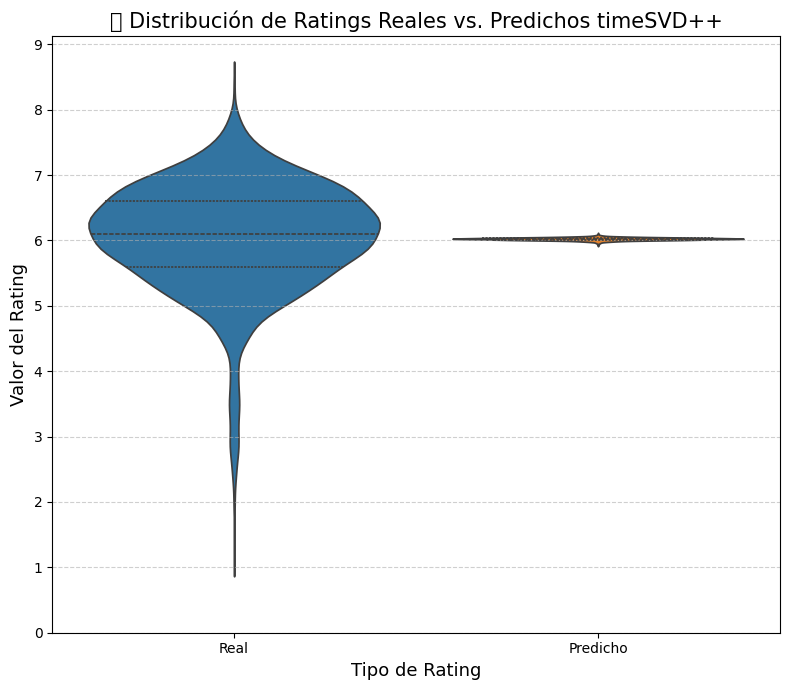

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # Asegúrate de tener numpy importado
import torch # Necesario si trabajas con tensores

# --- Asumimos que ya tienes estos datos después de la evaluación de tu modelo ---
# true_ratings: numpy array o pandas Series con los ratings reales del CONJUNTO DE TEST.
#               (Ej: df_test_final_filtrado["Rating"].values)
# pred_np: numpy array o pandas Series con los ratings predichos por el modelo para el CONJUNTO DE TEST.
#          (Ej: el resultado de model(...).cpu().numpy() sobre los datos de test)

# --- Ejemplo de cómo podrías tener true_ratings y pred_np (DEBES REEMPLAZAR ESTO) ---
# true_ratings = df_test_final_filtrado["Rating"].values # Datos reales del conjunto de test

# # Generar predicciones para el conjunto de test (df_test_final_filtrado)
# # Necesitarás los tensores de input para el test: test_user, test_item, test_time,
# # dev_ut_test, item_bin_idx_test, hist_vectors_test
# # Estos se deben haber generado en tu script de evaluación.

# # Si 'model' es tu instancia de TimeSVDppSimpleBins entrenada:
# model.eval()
# with torch.no_grad():
#     # ASUME QUE ESTAS VARIABLES DE TEST ESTÁN DEFINIDAS CORRECTAMENTE:
#     # test_user, test_item, test_time, dev_ut_test, item_bin_idx_test, hist_vectors_test
#     pred_test_tensor = model(
#         test_user,
#         test_item,
#         test_time,
#         dev_ut_test,
#         item_bin_idx_test,
#         hist_vectors_test
#     )
#     pred_np = pred_test_tensor.cpu().numpy() # Predicciones del modelo para el conjunto de test
# ---------------------------------------------------------------------------------

# --- Asegúrate de que true_ratings y pred_np están definidos con tus datos reales ---
# Por ejemplo, si ya ejecutaste tu script de evaluación:
# true_ratings = df_test_final_filtrado["Rating"].values
# pred_np = ... (el array numpy de predicciones que obtuviste para el test set)
# Si no los tienes, debes calcular pred_np como se muestra en el bloque comentado arriba.

# Verificar que las variables existen y tienen datos (¡IMPORTANTE!)
if 'true_ratings' not in locals() or 'pred_np' not in locals():
    print("🚨 ¡Error! Las variables 'true_ratings' y/o 'pred_np' no están definidas.")
    print("Asegúrate de haber ejecutado la evaluación de tu modelo en el conjunto de test")
    print("y de que estas variables contengan los ratings reales y predichos del test.")
    # Puedes detener la ejecución o asignar datos de ejemplo para probar el plot:
    # true_ratings = np.random.rand(100) * 9 + 1 # Ejemplo
    # pred_np = np.random.rand(100) * 9 + 1      # Ejemplo
    # raise ValueError("true_ratings y pred_np deben estar definidos.")
else:
    print(f"Número de ratings reales: {len(true_ratings)}")
    print(f"Número de ratings predichos: {len(pred_np)}")
    if len(true_ratings) != len(pred_np):
        print("🚨 ¡Advertencia! El número de ratings reales y predichos no coincide.")
        print("Esto podría indicar un problema en la preparación de los datos.")

    # 1. Armar el DataFrame apilado para Seaborn
    # Asegúrate de que true_ratings y pred_np sean arrays 1D de numpy
    if isinstance(true_ratings, pd.Series):
        true_ratings_np = true_ratings.values
    else:
        true_ratings_np = np.array(true_ratings).flatten()

    if isinstance(pred_np, pd.Series):
        pred_np_flat = pred_np.values
    else:
        pred_np_flat = np.array(pred_np).flatten()


    df_violin = pd.DataFrame({
        "Rating": np.concatenate([true_ratings_np, pred_np_flat]),
        "Tipo": ["Real"] * len(true_ratings_np) + ["Predicho"] * len(pred_np_flat)
    })

    # 2. Definir colores para consistencia (opcional pero bueno)
    colores = {"Real": "#1f77b4", "Predicho": "#ff7f0e"}  # Azul y naranja estándar de Matplotlib

    # 3. Crear el Violin Plot
    plt.figure(figsize=(8, 7)) # Ajusta el tamaño según necesites
    sns.violinplot(
        x="Tipo",          # Coloca 'Real' y 'Predicho' en el eje x
        y="Rating",        # Muestra la distribución de los ratings en el eje y
        data=df_violin,
        inner="quartile",  # Muestra los cuartiles dentro de los violines
        palette=colores,   # Aplica los colores definidos
        scale="width"      # Escala los violines para que tengan el mismo ancho
    )

    plt.title(f"🎻 Distribución de Ratings Reales vs. Predichos timeSVD++", fontsize=15)
    plt.xlabel("Tipo de Rating", fontsize=13)
    plt.ylabel("Valor del Rating", fontsize=13)
    plt.yticks(np.arange(int(min(df_violin['Rating']))-1, int(max(df_violin['Rating']))+2, 1)) # Ajustar ticks del eje Y
    plt.grid(True, linestyle='--', alpha=0.6, axis='y')
    plt.tight_layout()
    plt.show()

## SVD++ con temporalidad en los puk pero sin funciones temporales

In [111]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau

# --- Modelo con regularización diferenciada como en los papers ---
class TimeSVDppOnlyPUTime(nn.Module):
    def __init__(self, num_users, num_items, num_times, embedding_dim, global_mean, lambda_b=0.002, lambda_pq=0.002):
        super().__init__()
        self.mu = global_mean
        self.num_times = num_times
        self.embedding_dim = embedding_dim
        self.lambda_b = lambda_b
        self.lambda_pq = lambda_pq

        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        self.p_u = nn.Embedding(num_users, embedding_dim)
        self.alpha_pu = nn.Embedding(num_users, embedding_dim)
        self.q_i = nn.Embedding(num_items, embedding_dim)
        self.y_j = nn.Embedding(num_items, embedding_dim)

        for emb in [self.user_bias, self.item_bias, self.p_u, self.alpha_pu, self.q_i, self.y_j]:
            nn.init.normal_(emb.weight, std=0.01)

    def forward(self, user_ids, item_ids, time_ids, dev_ut, hist_vectors):
        bu = self.user_bias(user_ids).squeeze()
        bi = self.item_bias(item_ids).squeeze()

        pu = self.p_u(user_ids)
        alpha_pu = self.alpha_pu(user_ids)
        pu_time = pu + alpha_pu * dev_ut.unsqueeze(1)

        qi = self.q_i(item_ids)
        z_u = pu_time + hist_vectors
        interaction = (qi * z_u).sum(dim=1)

        return self.mu + bu + bi + interaction

    def loss(self, preds, ratings, user_ids, item_ids):
        mse = nn.functional.mse_loss(preds, ratings)

        # Regularización diferenciada
        bu = self.user_bias(user_ids).squeeze()
        bi = self.item_bias(item_ids).squeeze()
        pu = self.p_u(user_ids)
        alpha_pu = self.alpha_pu(user_ids)
        qi = self.q_i(item_ids)

        reg_b = self.lambda_b * (bu ** 2).sum() + self.lambda_b * (bi ** 2).sum()
        reg_pq = self.lambda_pq * ((pu ** 2).sum() + (alpha_pu ** 2).sum() + (qi ** 2).sum())

        return mse + reg_b + reg_pq

# --- Preparación de datos ---
mu = df_cv["Rating"].mean()
num_users = df_cv["user_id"].nunique()
num_items = df_cv["item_id"].nunique()
num_times = df_cv["time_idx"].nunique()
embedding_dim = 3

model = TimeSVDppOnlyPUTime(num_users, num_items, num_times, embedding_dim, mu)

user_ids = torch.tensor(df_cv["user_id"].values, dtype=torch.long)
item_ids = torch.tensor(df_cv["item_id"].values, dtype=torch.long)
time_ids = torch.tensor(df_cv["time_idx"].values, dtype=torch.long)
ratings = torch.tensor(df_cv["Rating"].values, dtype=torch.float32)

user_date_mean = df_cv.groupby("user_id")["time_idx"].mean()
dev_ut = torch.tensor([
    np.sign(delta := row["time_idx"] - user_date_mean[row["user_id"]]) * abs(delta) ** 0.4
    for _, row in df_cv.iterrows()
], dtype=torch.float32)

user_item_matrix = df_cv.groupby("user_id")["item_id"].agg(list)

# --- Entrenamiento ---
opt = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(10):
    model.train()
    with torch.no_grad():
        hist_vectors = torch.zeros(len(user_ids), embedding_dim)
        for idx, u in enumerate(user_ids):
            items = user_item_matrix.get(u.item(), [])
            if items:
                ids_tensor = torch.tensor(items, dtype=torch.long)
                hist_vectors[idx] = model.y_j(ids_tensor).sum(dim=0)

    preds = model(user_ids, item_ids, time_ids, dev_ut, hist_vectors)
    total_loss = model.loss(preds, ratings, user_ids, item_ids)

    opt.zero_grad()
    total_loss.backward()
    opt.step()
    print(f"Epoch {epoch+1}/10 Loss: {total_loss.item():.4f}")

# --- Evaluación ---
test_user = torch.tensor(df_test_final_filtrado["user_id"].values, dtype=torch.long)
test_item = torch.tensor(df_test_final_filtrado["item_id"].values, dtype=torch.long)
test_time = torch.tensor(df_test_final_filtrado["time_idx"].values, dtype=torch.long)
true_ratings = df_test_final_filtrado["Rating"].values

user_date_mean_test = df_cv.groupby("user_id")["time_idx"].mean()
dev_ut_test = torch.tensor([
    np.sign(delta := row["time_idx"] - user_date_mean_test.get(row["user_id"], df_cv["time_idx"].mean())) * abs(delta) ** 0.4
    for _, row in df_test_final_filtrado.iterrows()
], dtype=torch.float32)

hist_vectors_test = torch.zeros((len(test_user), embedding_dim))
for idx, u in enumerate(test_user):
    hist_items = df_cv[df_cv["user_id"] == u.item()]["item_id"].tolist()
    if hist_items:
        hist_vectors_test[idx] = model.y_j(torch.tensor(hist_items)).sum(dim=0)

model.eval()
with torch.no_grad():
    pred = model(test_user, test_item, test_time, dev_ut_test, hist_vectors_test)
    pred_np = pred.cpu().numpy()

rmse = np.sqrt(mean_squared_error(true_ratings, pred_np))
mae = mean_absolute_error(true_ratings, pred_np)
r2 = r2_score(true_ratings, pred_np)
spearman_corr, _ = spearmanr(true_ratings, pred_np)
kendall_corr, _ = kendalltau(true_ratings, pred_np)
pmae_value = pmae(true_ratings, pred_np)

print("\n📊 Evaluación TimeSVD++ solo con p_u(t) y regularización diferenciada:")
print(f"RMSE        : {rmse:.4f}")
print(f"MAE         : {mae:.4f}")
print(f"R²          : {r2:.4f}")
print(f"Spearman ρ  : {spearman_corr:.4f}")
print(f"Kendall τ   : {kendall_corr:.4f}")
print(f"PMAE        : {pmae_value:.2f}")

resultados_metricas.append({
          "Modelo": "TimeSVD++ simplified",      # o hiperparámetros, etc.
          "RMSE": rmse,
          "MAE": mae,
          "R2": r2,
          "Spearman": spearman_corr,
          "Kendall": kendall_corr,
          "PMAE": pmae_value
          })


Epoch 1/10 Loss: 0.8234
Epoch 2/10 Loss: 0.7857
Epoch 3/10 Loss: 0.7673
Epoch 4/10 Loss: 0.7622
Epoch 5/10 Loss: 0.7625
Epoch 6/10 Loss: 0.7633
Epoch 7/10 Loss: 0.7636
Epoch 8/10 Loss: 0.7635
Epoch 9/10 Loss: 0.7632
Epoch 10/10 Loss: 0.7623

📊 Evaluación TimeSVD++ solo con p_u(t) y regularización diferenciada:
RMSE        : 0.8377
MAE         : 0.6334
R²          : 0.0040
Spearman ρ  : 0.1762
Kendall τ   : 0.1195
PMAE        : 11.82


In [112]:
# --- dev_ut (train) ---
user_date_mean_train = df_cv.groupby("user_id")["time_idx"].mean()
dev_ut_train = torch.tensor([
    np.sign(delta := row["time_idx"] - user_date_mean_train[row["user_id"]]) * abs(delta) ** 0.4
    for _, row in df_cv.iterrows()
], dtype=torch.float32)

# --- historial (train) ---
hist_vectors_train = torch.zeros((len(train_user), embedding_dim))
for idx, u in enumerate(train_user):
    hist_items = df_cv[df_cv["user_id"] == u.item()]["item_id"].tolist()
    if hist_items:
        hist_vectors_train[idx] = model.y_j(torch.tensor(hist_items)).sum(dim=0)

# --- predicciones (train) ---
model.eval()
with torch.no_grad():
    pred_cv = model(train_user, train_item, train_time, dev_ut_train, hist_vectors_train)


In [113]:
# Ya tenías dev_ut_test y hist_vectors_test creados antes, si no:

user_date_mean_test = df_cv.groupby("user_id")["time_idx"].mean()
dev_ut_test = torch.tensor([
    np.sign(delta := row["time_idx"] - user_date_mean_test.get(row["user_id"], df_cv["time_idx"].mean())) * abs(delta) ** 0.4
    for _, row in df_test_final_filtrado.iterrows()
], dtype=torch.float32)

hist_vectors_test = torch.zeros((len(test_user), embedding_dim))
for idx, u in enumerate(test_user):
    hist_items = df_cv[df_cv["user_id"] == u.item()]["item_id"].tolist()
    if hist_items:
        hist_vectors_test[idx] = model.y_j(torch.tensor(hist_items)).sum(dim=0)

# --- predicciones (test) ---
with torch.no_grad():
    pred_test = model(test_user, test_item, test_time, dev_ut_test, hist_vectors_test)

df_cv_preds, df_test_preds = agregar_predicciones(
    df_cv_preds,
    df_test_preds,
    nombre_columna="pred_timeSVDpp_simplified",
    preds_cv=pred_cv,
    preds_test=pred_test
)


✅ Columna 'pred_timeSVDpp_simplified' agregada correctamente.


In [ ]:
def recomendar_jugadores_equipo_timesvdpp_pu_time(
    nombre_equipo,
    año,
    jugadores_filtrados,
    user_encoder,
    item_encoder,
    df_cv,
    model,
    embedding_dim,
    top_k=5
):
    # --- Codificar equipo ---
    tipo_equipo = type(df_cv["Equipo"].iloc[0])
    equipo_codificado = tipo_equipo(nombre_equipo)
    if equipo_codificado not in item_encoder.classes_:
        print(f"Equipo '{nombre_equipo}' no encontrado en item_encoder.")
        return pd.DataFrame()
    equipo_id = item_encoder.transform([equipo_codificado])[0]

    # --- Codificar año a time_idx ---
    time_categories = df_cv["Año_Orden"].astype("category").cat.categories
    if año not in time_categories.values:
        print(f"Año {año} no está en las categorías del modelo.")
        return pd.DataFrame()
    time_idx = pd.Categorical([año], categories=time_categories).codes[0]

    # --- Jugadores conocidos por el modelo ---
    jugadores_df = jugadores_filtrados[['Nombre', 'ID Jugador']].drop_duplicates('ID Jugador')
    nombres = jugadores_df['Nombre'].tolist()
    ids_jugadores = jugadores_df['ID Jugador'].tolist()
    tipo_id = type(df_cv["ID Jugador"].iloc[0])
    ids_jugadores_validos = [jid for jid in ids_jugadores if tipo_id(jid) in user_encoder.classes_]
    nombres_validos = [nombres[i] for i, jid in enumerate(ids_jugadores) if tipo_id(jid) in user_encoder.classes_]
    if len(ids_jugadores_validos) == 0:
        print("No hay jugadores conocidos por el modelo para recomendar.")
        return pd.DataFrame()
    usuarios_idx = user_encoder.transform([tipo_id(jid) for jid in ids_jugadores_validos])

    # --- Preparar tensores para predicción ---
    n_jugadores = len(usuarios_idx)
    user_tensor = torch.tensor(usuarios_idx, dtype=torch.long)
    item_tensor = torch.tensor([equipo_id] * n_jugadores, dtype=torch.long)
    time_tensor = torch.tensor([time_idx] * n_jugadores, dtype=torch.long)

    # --- Calcular dev_ut (deviation temporal por jugador) ---
    user_date_mean = df_cv.groupby("user_id")["time_idx"].mean()
    dev_ut = torch.tensor([
        np.sign(time_idx - user_date_mean.get(u, df_cv["time_idx"].mean())) * abs(time_idx - user_date_mean.get(u, df_cv["time_idx"].mean())) ** 0.4
        for u in usuarios_idx
    ], dtype=torch.float32)

    # --- Historial de cada jugador ---
    hist_vectors = torch.zeros((n_jugadores, embedding_dim))
    for idx, u in enumerate(usuarios_idx):
        hist_items = df_cv[df_cv["user_id"] == u]["item_id"].tolist()
        if hist_items:
            hist_vectors[idx] = model.y_j(torch.tensor(hist_items)).sum(dim=0)

    # --- Predicción ---
    model.eval()
    with torch.no_grad():
        preds = model(user_tensor, item_tensor, time_tensor, dev_ut, hist_vectors).cpu().numpy()

    # --- DataFrame de resultados ---
    result = pd.DataFrame({
        'Nombre': nombres_validos,
        'ID Jugador': ids_jugadores_validos,
        'predicted_rating': preds
    }).sort_values('predicted_rating', ascending=False).reset_index(drop=True)

    return result.head(top_k)


In [ ]:
top_recs_pu_time = recomendar_jugadores_equipo_timesvdpp_pu_time(
    nombre_equipo="Sevilla",
    año=2025,
    jugadores_filtrados=jugadores_filtrados,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    df_cv=df_cv,
    model=model,
    embedding_dim=embedding_dim,
    top_k=5
)

print(top_recs_pu_time)


            Nombre ID Jugador  predicted_rating
0  LABINOT BAJRAMI    3182472          6.065717
1   R. LEWANDOWSKI      53536          6.056862
2    THIERNO BARRY    1009365          6.053753
3       Y. MOUKOKO     409654          6.053660
4             HULK      22295          6.053585


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, kendalltau

# --- Modelo con regularización diferenciada como en los papers ---
class TimeSVDppOnlyPUTime(nn.Module):
    def __init__(self, num_users, num_items, num_times, embedding_dim, global_mean, lambda_b=0.002, lambda_pq=0.002):
        super().__init__()
        self.mu = global_mean
        self.num_times = num_times
        self.embedding_dim = embedding_dim
        self.lambda_b = lambda_b
        self.lambda_pq = lambda_pq

        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        self.p_u = nn.Embedding(num_users, embedding_dim)
        self.alpha_pu = nn.Embedding(num_users, embedding_dim)
        self.q_i = nn.Embedding(num_items, embedding_dim)
        self.y_j = nn.Embedding(num_items, embedding_dim)

        for emb in [self.user_bias, self.item_bias, self.p_u, self.alpha_pu, self.q_i, self.y_j]:
            nn.init.normal_(emb.weight, std=0.01)

    def forward(self, user_ids, item_ids, time_ids, dev_ut, hist_vectors):
        bu = self.user_bias(user_ids).squeeze()
        bi = self.item_bias(item_ids).squeeze()

        pu = self.p_u(user_ids)
        alpha_pu = self.alpha_pu(user_ids)
        pu_time = pu + alpha_pu * dev_ut.unsqueeze(1)

        qi = self.q_i(item_ids)
        z_u = pu_time + hist_vectors
        interaction = (qi * z_u).sum(dim=1)

        return self.mu + bu + bi + interaction

    def loss(self, preds, ratings, user_ids, item_ids):
        mse = nn.functional.mse_loss(preds, ratings)

        # Regularización diferenciada
        bu = self.user_bias(user_ids).squeeze()
        bi = self.item_bias(item_ids).squeeze()
        pu = self.p_u(user_ids)
        alpha_pu = self.alpha_pu(user_ids)
        qi = self.q_i(item_ids)

        reg_b = self.lambda_b * (bu ** 2).sum() + self.lambda_b * (bi ** 2).sum()
        reg_pq = self.lambda_pq * ((pu ** 2).sum() + (alpha_pu ** 2).sum() + (qi ** 2).sum())

        return mse + reg_b + reg_pq

# --- Preparación de datos ---
mu = df["Rating"].mean()
num_users = df["user_id"].nunique()
num_items = df["item_id"].nunique()
num_times = df["time_idx"].nunique()
embedding_dim = 3

model = TimeSVDppOnlyPUTime(num_users, num_items, num_times, embedding_dim, mu)

user_ids = torch.tensor(df["user_id"].values, dtype=torch.long)
item_ids = torch.tensor(df["item_id"].values, dtype=torch.long)
time_ids = torch.tensor(df["time_idx"].values, dtype=torch.long)
ratings = torch.tensor(df["Rating"].values, dtype=torch.float32)

user_date_mean = df.groupby("user_id")["time_idx"].mean()
dev_ut = torch.tensor([
    np.sign(delta := row["time_idx"] - user_date_mean[row["user_id"]]) * abs(delta) ** 0.4
    for _, row in df.iterrows()
], dtype=torch.float32)

user_item_matrix = df.groupby("user_id")["item_id"].agg(list)

# --- Entrenamiento ---
opt = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(10):
    model.train()
    with torch.no_grad():
        hist_vectors = torch.zeros(len(user_ids), embedding_dim)
        for idx, u in enumerate(user_ids):
            items = user_item_matrix.get(u.item(), [])
            if items:
                ids_tensor = torch.tensor(items, dtype=torch.long)
                hist_vectors[idx] = model.y_j(ids_tensor).sum(dim=0)

    preds = model(user_ids, item_ids, time_ids, dev_ut, hist_vectors)
    total_loss = model.loss(preds, ratings, user_ids, item_ids)

    opt.zero_grad()
    total_loss.backward()
    opt.step()
    print(f"Epoch {epoch+1}/10 Loss: {total_loss.item():.4f}")


"""user_date_mean_test = df.groupby("user_id")["time_idx"].mean()
dev_ut_test = torch.tensor([
    np.sign(delta := row["time_idx"] - user_date_mean_test.get(row["user_id"], df["time_idx"].mean())) * abs(delta) ** 0.4
    for _, row in df.iterrows()
], dtype=torch.float32)

hist_vectors_test = torch.zeros((len(test_user), embedding_dim))
for idx, u in enumerate(test_user):
    hist_items = df[df["user_id"] == u.item()]["item_id"].tolist()
    if hist_items:
        hist_vectors_test[idx] = model.y_j(torch.tensor(hist_items)).sum(dim=0)

model.eval()
with torch.no_grad():
    pred = model(test_user, test_item, test_time, dev_ut_test, hist_vectors_test)
    pred_np = pred.cpu().numpy()"""


Epoch 1/10 Loss: 0.8257
Epoch 2/10 Loss: 0.7844
Epoch 3/10 Loss: 0.7644
Epoch 4/10 Loss: 0.7589
Epoch 5/10 Loss: 0.7595
Epoch 6/10 Loss: 0.7606
Epoch 7/10 Loss: 0.7610
Epoch 8/10 Loss: 0.7609
Epoch 9/10 Loss: 0.7605
Epoch 10/10 Loss: 0.7594


'user_date_mean_test = df.groupby("user_id")["time_idx"].mean()\ndev_ut_test = torch.tensor([\n    np.sign(delta := row["time_idx"] - user_date_mean_test.get(row["user_id"], df["time_idx"].mean())) * abs(delta) ** 0.4\n    for _, row in df.iterrows()\n], dtype=torch.float32)\n\nhist_vectors_test = torch.zeros((len(test_user), embedding_dim))\nfor idx, u in enumerate(test_user):\n    hist_items = df[df["user_id"] == u.item()]["item_id"].tolist()\n    if hist_items:\n        hist_vectors_test[idx] = model.y_j(torch.tensor(hist_items)).sum(dim=0)\n\nmodel.eval()\nwith torch.no_grad():\n    pred = model(test_user, test_item, test_time, dev_ut_test, hist_vectors_test)\n    pred_np = pred.cpu().numpy()'

In [ ]:
top_recs_pu_time = recomendar_jugadores_equipo_timesvdpp_pu_time(
    nombre_equipo="Racing",
    año=2025,
    jugadores_filtrados=jugadores_filtrados,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    df_cv=df,
    model=model,
    embedding_dim=embedding_dim,
    top_k=5
)

print(top_recs_pu_time)


           Nombre ID Jugador  predicted_rating
0     JUAN ARTOLA     561042          6.067024
1      V. BERISHA     223115          6.061881
2  L. DE LA TORRE     285554          6.060373
3      MIRO TENHO     214250          6.058452
4          F. GIL     327665          6.058191


## Cross validation de hiperparams timeSVD++

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product

# ----------- PARÁMETROS A PROBAR -------------
param_grid = {
    'embedding_dim': [3, 5, 10, 20],
    'num_bins': [2, 5, 10],
    'lambda_b': [0.002, 0.005, 0.01],
    'lambda_pq': [0.002, 0.005, 0.01],
    'beta_time': [0.3, 0.4, 0.5]
}

class TimeSVDppSimpleBins(nn.Module):
    def __init__(self, num_users, num_items, num_times, num_bins, embedding_dim, global_mean, lambda_b=0.002, lambda_pq=0.002):
        super().__init__()
        self.mu = global_mean
        self.num_times = num_times
        self.num_bins = num_bins
        self.embedding_dim = embedding_dim
        self.lambda_b = lambda_b
        self.lambda_pq = lambda_pq
        self.user_bias = nn.Embedding(num_users, 1)
        self.alpha_u = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.item_bin_bias = nn.Embedding(num_items * num_bins, 1)
        self.p_u = nn.Embedding(num_users, embedding_dim)
        self.alpha_pu = nn.Embedding(num_users, embedding_dim)
        self.q_i = nn.Embedding(num_items, embedding_dim)
        self.y_j = nn.Embedding(num_items, embedding_dim)
        for emb in [self.user_bias, self.alpha_u,
                    self.item_bias, self.item_bin_bias,
                    self.p_u, self.alpha_pu, self.q_i, self.y_j]:
            nn.init.normal_(emb.weight, std=0.01)

    def forward(self, user_ids, item_ids, time_ids, dev_ut, item_bin_idx, hist_vectors):
        bu = self.user_bias(user_ids).squeeze()
        au = self.alpha_u(user_ids).squeeze()
        bi = self.item_bias(item_ids).squeeze()
        bi_bin = self.item_bin_bias(item_bin_idx).squeeze()
        pu = self.p_u(user_ids)
        alpha_pu = self.alpha_pu(user_ids)
        pu_time = pu + alpha_pu * dev_ut.unsqueeze(1)
        qi = self.q_i(item_ids)
        z_u = pu_time + hist_vectors
        interaction = (qi * z_u).sum(dim=1)
        return self.mu + bu + au * dev_ut + bi + bi_bin + interaction

    def loss(self, preds, ratings, user_ids, item_ids, time_ids, item_bin_idx):
        mse = nn.functional.mse_loss(preds, ratings)
        bu = self.user_bias(user_ids).squeeze()
        au = self.alpha_u(user_ids).squeeze()
        bi = self.item_bias(item_ids).squeeze()
        bi_bin = self.item_bin_bias(item_bin_idx).squeeze()
        reg_b = self.lambda_b * ((bu ** 2).sum() + (au ** 2).sum() + (bi ** 2).sum() + (bi_bin ** 2).sum())
        pu = self.p_u(user_ids)
        alpha_pu = self.alpha_pu(user_ids)
        qi = self.q_i(item_ids)
        reg_pq = self.lambda_pq * ((pu ** 2).sum() + (alpha_pu ** 2).sum() + (qi ** 2).sum())
        return mse + reg_b + reg_pq

# ---- Función para calcular índices de bin seguros ----
def get_bin_idx(ids_tensor, times_tensor, num_bins, num_entities, num_times):
    bin_size = int(np.ceil(num_times / num_bins))
    time_bins = torch.clamp(times_tensor // bin_size, min=0, max=num_bins - 1)
    idx = ids_tensor * num_bins + time_bins
    return idx

# ---- Separar validation temporal ----
split_time = np.percentile(df_cv["time_idx"], 90)
df_train = df_cv[df_cv["time_idx"] < split_time].copy()
df_val = df_cv[df_cv["time_idx"] >= split_time].copy()

# Filtrado: solo usuarios e ítems que existen en train
train_user_ids = set(df_train['user_id'])
train_item_ids = set(df_train['item_id'])
df_val = df_val[
    df_val['user_id'].isin(train_user_ids) &
    df_val['item_id'].isin(train_item_ids)
].copy()

num_users = df_cv["user_id"].nunique()
num_items = df_cv["item_id"].nunique()
num_times = df_cv["time_idx"].nunique()
mu = df_cv["Rating"].mean()

def train_and_eval(params):
    embedding_dim, num_bins, lambda_b, lambda_pq, beta_time = params
    # --- Train ---
    user_ids = torch.tensor(df_train["user_id"].values, dtype=torch.long)
    item_ids = torch.tensor(df_train["item_id"].values, dtype=torch.long)
    time_ids = torch.tensor(df_train["time_idx"].values, dtype=torch.long)
    ratings = torch.tensor(df_train["Rating"].values, dtype=torch.float32)
    user_date_mean = df_train.groupby("user_id")["time_idx"].mean()
    dev_ut = torch.tensor([
        np.sign(delta := row["time_idx"] - user_date_mean[row["user_id"]]) * abs(delta) ** beta_time
        for _, row in df_train.iterrows()
    ], dtype=torch.float32)
    item_bin_idx = get_bin_idx(item_ids, time_ids, num_bins, num_items, num_times)
    user_item_matrix = df_train.groupby("user_id")["item_id"].agg(list)
    model = TimeSVDppSimpleBins(num_users, num_items, num_times, num_bins, embedding_dim, mu,
                                lambda_b=lambda_b, lambda_pq=lambda_pq)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    for epoch in range(5):
        with torch.no_grad():
            hist_vectors = torch.zeros(len(user_ids), embedding_dim)
            for idx, u in enumerate(user_ids):
                items = user_item_matrix.get(u.item(), [])
                if items:
                    ids_tensor = torch.tensor(items, dtype=torch.long)
                    hist_vectors[idx] = model.y_j(ids_tensor).sum(dim=0)
        preds = model(user_ids, item_ids, time_ids, dev_ut, item_bin_idx, hist_vectors)
        total_loss = model.loss(preds, ratings, user_ids, item_ids, time_ids, item_bin_idx)
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    # --- VALIDACIÓN ---
    user_ids_val = torch.tensor(df_val["user_id"].values, dtype=torch.long)
    item_ids_val = torch.tensor(df_val["item_id"].values, dtype=torch.long)
    time_ids_val = torch.tensor(df_val["time_idx"].values, dtype=torch.long)
    ratings_val = df_val["Rating"].values
    user_date_mean_val = df_train.groupby("user_id")["time_idx"].mean()
    dev_ut_val = torch.tensor([
        np.sign(delta := row["time_idx"] - user_date_mean_val.get(row["user_id"], df_train["time_idx"].mean())) * abs(delta) ** beta_time
        for _, row in df_val.iterrows()
    ], dtype=torch.float32)
    item_bin_idx_val = get_bin_idx(item_ids_val, time_ids_val, num_bins, num_items, num_times)
    hist_vectors_val = torch.zeros((len(user_ids_val), embedding_dim))
    for idx, u in enumerate(user_ids_val):
        hist_items = df_train[df_train["user_id"] == u.item()]["item_id"].tolist()
        if hist_items:
            hist_vectors_val[idx] = model.y_j(torch.tensor(hist_items)).sum(dim=0)
    model.eval()
    with torch.no_grad():
        pred = model(user_ids_val, item_ids_val, time_ids_val, dev_ut_val, item_bin_idx_val, hist_vectors_val)
        pred_np = pred.cpu().numpy()
    rmse = np.sqrt(mean_squared_error(ratings_val, pred_np))
    mae = mean_absolute_error(ratings_val, pred_np)
    r2 = r2_score(ratings_val, pred_np)
    return rmse, mae, r2

all_params = list(product(
    param_grid['embedding_dim'],
    param_grid['num_bins'],
    param_grid['lambda_b'],
    param_grid['lambda_pq'],
    param_grid['beta_time'],
))

results = []
for i, params in enumerate(all_params):
    print(f"\nProbandoparamset {i+1}/{len(all_params)}: {params}")
    rmse, mae, r2 = train_and_eval(params)
    results.append((params, rmse, mae, r2))
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

# ---- Resultados ordenados ----
results = sorted(results, key=lambda x: x[1])  # ordena por RMSE
print("\nTop 10 combinaciones por RMSE (mejor primero):")
for params, rmse, mae, r2 in results[:10]:
    print(f"Params: {params} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")



Probandoparamset 1/324: (3, 2, 0.002, 0.002, 0.3)
RMSE: 0.8410 | MAE: 0.6483 | R2: 0.0073

Probandoparamset 2/324: (3, 2, 0.002, 0.002, 0.4)
RMSE: 0.8407 | MAE: 0.6483 | R2: 0.0080

Probandoparamset 3/324: (3, 2, 0.002, 0.002, 0.5)
RMSE: 0.8407 | MAE: 0.6480 | R2: 0.0081

Probandoparamset 4/324: (3, 2, 0.002, 0.005, 0.3)
RMSE: 0.8411 | MAE: 0.6489 | R2: 0.0070

Probandoparamset 5/324: (3, 2, 0.002, 0.005, 0.4)
RMSE: 0.8401 | MAE: 0.6481 | R2: 0.0094

Probandoparamset 6/324: (3, 2, 0.002, 0.005, 0.5)
RMSE: 0.8408 | MAE: 0.6486 | R2: 0.0078

Probandoparamset 7/324: (3, 2, 0.002, 0.01, 0.3)
RMSE: 0.8407 | MAE: 0.6484 | R2: 0.0079

Probandoparamset 8/324: (3, 2, 0.002, 0.01, 0.4)
RMSE: 0.8403 | MAE: 0.6480 | R2: 0.0090

Probandoparamset 9/324: (3, 2, 0.002, 0.01, 0.5)
RMSE: 0.8409 | MAE: 0.6488 | R2: 0.0076

Probandoparamset 10/324: (3, 2, 0.005, 0.002, 0.3)
RMSE: 0.8431 | MAE: 0.6501 | R2: 0.0023

Probandoparamset 11/324: (3, 2, 0.005, 0.002, 0.4)
RMSE: 0.8429 | MAE: 0.6504 | R2: 0.0028


## Con early stopping, layer norm y alternando etapas

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product

# ----------- PARÁMETROS A PROBAR -------------
param_grid = {
    'embedding_dim': [3, 5],
    'num_bins': [3, 5],
    'lambda_b': [0.002, 0.01],
    'lambda_pq': [0.002, 0.01],
    'beta_time': [0.3, 0.5]
}

class TimeSVDppSimpleBinsBN(nn.Module):
    def __init__(self, num_users, num_items, num_times, num_bins, embedding_dim, global_mean, lambda_b=0.002, lambda_pq=0.002):
        super().__init__()
        self.mu = global_mean
        self.num_times = num_times
        self.num_bins = num_bins
        self.embedding_dim = embedding_dim
        self.lambda_b = lambda_b
        self.lambda_pq = lambda_pq
        self.user_bias = nn.Embedding(num_users, 1)
        self.alpha_u = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.item_bin_bias = nn.Embedding(num_items * num_bins, 1)
        self.p_u = nn.Embedding(num_users, embedding_dim)
        self.alpha_pu = nn.Embedding(num_users, embedding_dim)
        self.q_i = nn.Embedding(num_items, embedding_dim)
        self.y_j = nn.Embedding(num_items, embedding_dim)
        # BatchNorm para embeddings
        self.bn_user = nn.BatchNorm1d(embedding_dim)
        self.bn_item = nn.BatchNorm1d(embedding_dim)
        for emb in [self.user_bias, self.alpha_u,
                    self.item_bias, self.item_bin_bias,
                    self.p_u, self.alpha_pu, self.q_i, self.y_j]:
            nn.init.normal_(emb.weight, std=0.01)

    def forward(self, user_ids, item_ids, time_ids, dev_ut, item_bin_idx, hist_vectors):
        bu = self.user_bias(user_ids).squeeze()
        au = self.alpha_u(user_ids).squeeze()
        bi = self.item_bias(item_ids).squeeze()
        bi_bin = self.item_bin_bias(item_bin_idx).squeeze()
        pu = self.p_u(user_ids)
        alpha_pu = self.alpha_pu(user_ids)
        pu_time = pu + alpha_pu * dev_ut.unsqueeze(1)
        qi = self.q_i(item_ids)
        # BatchNorm sobre embeddings (batch_size, embedding_dim)
        pu_time = self.bn_user(pu_time)
        qi = self.bn_item(qi)
        z_u = pu_time + hist_vectors
        interaction = (qi * z_u).sum(dim=1)
        return self.mu + bu + au * dev_ut + bi + bi_bin + interaction

    def loss(self, preds, ratings, user_ids, item_ids, time_ids, item_bin_idx):
        mse = nn.functional.mse_loss(preds, ratings)
        bu = self.user_bias(user_ids).squeeze()
        au = self.alpha_u(user_ids).squeeze()
        bi = self.item_bias(item_ids).squeeze()
        bi_bin = self.item_bin_bias(item_bin_idx).squeeze()
        reg_b = self.lambda_b * ((bu ** 2).sum() + (au ** 2).sum() + (bi ** 2).sum() + (bi_bin ** 2).sum())
        pu = self.p_u(user_ids)
        alpha_pu = self.alpha_pu(user_ids)
        qi = self.q_i(item_ids)
        reg_pq = self.lambda_pq * ((pu ** 2).sum() + (alpha_pu ** 2).sum() + (qi ** 2).sum())
        return mse + reg_b + reg_pq

# ---- Función para calcular índices de bin seguros ----
def get_bin_idx(ids_tensor, times_tensor, num_bins, num_entities, num_times):
    bin_size = int(np.ceil(num_times / num_bins))
    time_bins = torch.clamp(times_tensor // bin_size, min=0, max=num_bins - 1)
    idx = ids_tensor * num_bins + time_bins
    return idx

# ---- Separar validation temporal ----
split_time = np.percentile(df_cv["time_idx"], 90)
df_train = df_cv[df_cv["time_idx"] < split_time].copy()
df_val = df_cv[df_cv["time_idx"] >= split_time].copy()

# Filtrado: solo usuarios e ítems que existen en train
train_user_ids = set(df_train['user_id'])
train_item_ids = set(df_train['item_id'])
df_val = df_val[
    df_val['user_id'].isin(train_user_ids) &
    df_val['item_id'].isin(train_item_ids)
].copy()

num_users = df_cv["user_id"].nunique()
num_items = df_cv["item_id"].nunique()
num_times = df_cv["time_idx"].nunique()
mu = df_cv["Rating"].mean()

def train_and_eval(params, max_epochs=30, alt_epochs=2, patience=3):
    embedding_dim, num_bins, lambda_b, lambda_pq, beta_time = params
    # --- Train ---
    user_ids = torch.tensor(df_train["user_id"].values, dtype=torch.long)
    item_ids = torch.tensor(df_train["item_id"].values, dtype=torch.long)
    time_ids = torch.tensor(df_train["time_idx"].values, dtype=torch.long)
    ratings = torch.tensor(df_train["Rating"].values, dtype=torch.float32)
    user_date_mean = df_train.groupby("user_id")["time_idx"].mean()
    dev_ut = torch.tensor([
        np.sign(delta := row["time_idx"] - user_date_mean[row["user_id"]]) * abs(delta) ** beta_time
        for _, row in df_train.iterrows()
    ], dtype=torch.float32)
    item_bin_idx = get_bin_idx(item_ids, time_ids, num_bins, num_items, num_times)
    user_item_matrix = df_train.groupby("user_id")["item_id"].agg(list)
    model = TimeSVDppSimpleBinsBN(num_users, num_items, num_times, num_bins, embedding_dim, mu,
                                  lambda_b=lambda_b, lambda_pq=lambda_pq)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_rmse = np.inf
    best_state = None
    patience_counter = 0

    # Alternancia: 2 epochs biases, 2 epochs embeddings, repite
    for epoch in range(max_epochs):
        # 1. Alternar entrenabilidad
        if (epoch // alt_epochs) % 2 == 0:  # Solo bias
            for name, param in model.named_parameters():
                if any(x in name for x in ["user_bias", "alpha_u", "item_bias", "item_bin_bias"]):
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        else:  # Todos
            for param in model.parameters():
                param.requires_grad = True

        model.train()
        with torch.no_grad():
            hist_vectors = torch.zeros(len(user_ids), embedding_dim)
            for idx, u in enumerate(user_ids):
                items = user_item_matrix.get(u.item(), [])
                if items:
                    ids_tensor = torch.tensor(items, dtype=torch.long)
                    hist_vectors[idx] = model.y_j(ids_tensor).sum(dim=0)
        preds = model(user_ids, item_ids, time_ids, dev_ut, item_bin_idx, hist_vectors)
        total_loss = model.loss(preds, ratings, user_ids, item_ids, time_ids, item_bin_idx)
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # --- Early stopping: evaluar en validation ---
        user_ids_val = torch.tensor(df_val["user_id"].values, dtype=torch.long)
        item_ids_val = torch.tensor(df_val["item_id"].values, dtype=torch.long)
        time_ids_val = torch.tensor(df_val["time_idx"].values, dtype=torch.long)
        ratings_val = df_val["Rating"].values
        user_date_mean_val = df_train.groupby("user_id")["time_idx"].mean()
        dev_ut_val = torch.tensor([
            np.sign(delta := row["time_idx"] - user_date_mean_val.get(row["user_id"], df_train["time_idx"].mean())) * abs(delta) ** beta_time
            for _, row in df_val.iterrows()
        ], dtype=torch.float32)
        item_bin_idx_val = get_bin_idx(item_ids_val, time_ids_val, num_bins, num_items, num_times)
        hist_vectors_val = torch.zeros((len(user_ids_val), embedding_dim))
        for idx, u in enumerate(user_ids_val):
            hist_items = df_train[df_train["user_id"] == u.item()]["item_id"].tolist()
            if hist_items:
                hist_vectors_val[idx] = model.y_j(torch.tensor(hist_items)).sum(dim=0)
        model.eval()
        with torch.no_grad():
            pred = model(user_ids_val, item_ids_val, time_ids_val, dev_ut_val, item_bin_idx_val, hist_vectors_val)
            pred_np = pred.cpu().numpy()
        rmse = np.sqrt(mean_squared_error(ratings_val, pred_np))

        # Early stopping logic
        if rmse < best_rmse - 1e-4:
            best_rmse = rmse
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"[Early stopping en epoch {epoch+1}] Mejor RMSE: {best_rmse:.4f}")
                break

    # Restaura el mejor modelo y evalúa métricas finales
    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        pred = model(user_ids_val, item_ids_val, time_ids_val, dev_ut_val, item_bin_idx_val, hist_vectors_val)
        pred_np = pred.cpu().numpy()
    rmse = np.sqrt(mean_squared_error(ratings_val, pred_np))
    mae = mean_absolute_error(ratings_val, pred_np)
    r2 = r2_score(ratings_val, pred_np)
    return rmse, mae, r2

all_params = list(product(
    param_grid['embedding_dim'],
    param_grid['num_bins'],
    param_grid['lambda_b'],
    param_grid['lambda_pq'],
    param_grid['beta_time'],
))

results = []
for i, params in enumerate(all_params):
    print(f"\nProbandoparamset {i+1}/{len(all_params)}: {params}")
    rmse, mae, r2 = train_and_eval(params)
    results.append((params, rmse, mae, r2))
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

# ---- Resultados ordenados ----
results = sorted(results, key=lambda x: x[1])  # ordena por RMSE
print("\nTop 10 combinaciones por RMSE (mejor primero):")
for params, rmse, mae, r2 in results[:10]:
    print(f"Params: {params} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")



Probandoparamset 1/32: (3, 3, 0.002, 0.002, 0.3)
[Early stopping en epoch 6] Mejor RMSE: 0.8411
RMSE: 0.8423 | MAE: 0.6499 | R2: 0.0042

Probandoparamset 2/32: (3, 3, 0.002, 0.002, 0.5)
[Early stopping en epoch 10] Mejor RMSE: 0.8425
RMSE: 0.8433 | MAE: 0.6507 | R2: 0.0020

Probandoparamset 3/32: (3, 3, 0.002, 0.01, 0.3)
[Early stopping en epoch 6] Mejor RMSE: 0.8421
RMSE: 0.8426 | MAE: 0.6500 | R2: 0.0034

Probandoparamset 4/32: (3, 3, 0.002, 0.01, 0.5)
[Early stopping en epoch 4] Mejor RMSE: 0.8434
RMSE: 0.8438 | MAE: 0.6504 | R2: 0.0006

Probandoparamset 5/32: (3, 3, 0.01, 0.002, 0.3)
[Early stopping en epoch 6] Mejor RMSE: 0.8433
RMSE: 0.8436 | MAE: 0.6510 | R2: 0.0012

Probandoparamset 6/32: (3, 3, 0.01, 0.002, 0.5)
[Early stopping en epoch 6] Mejor RMSE: 0.8433
RMSE: 0.8445 | MAE: 0.6517 | R2: -0.0011

Probandoparamset 7/32: (3, 3, 0.01, 0.01, 0.3)
[Early stopping en epoch 5] Mejor RMSE: 0.8434
RMSE: 0.8440 | MAE: 0.6509 | R2: 0.0003

Probandoparamset 8/32: (3, 3, 0.01, 0.01, 0.

# Blending

In [114]:
print("🔎 Columnas actuales en df_cv_preds:")
print(df_cv_preds.columns.tolist())

print("\n🔎 Columnas actuales en df_test_preds:")
print(df_test_preds.columns.tolist())


🔎 Columnas actuales en df_cv_preds:
['ID Jugador', 'Equipo', 'Rating', 'Año', 'user_id', 'item_id', 'time_idx', 'Año_Orden', 'pred_basicSVD_0', 'pred_basicSVD_v1', 'pred_baseline_sin_temp', 'pred_baseline_con_temp', 'pred_basic_SVD_2', 'pred_SVDpp', 'pred_similaridad', 'pred_item_vector_model', 'pred_item_vector_simplificado', 'pred_SVDpp_simple', 'pred_timeSVDpp', 'pred_timeSVDpp_simplified']

🔎 Columnas actuales en df_test_preds:
['ID Jugador', 'Equipo', 'Rating', 'Año', 'user_id', 'item_id', 'time_idx', 'Año_Orden', 'pred_basicSVD_0', 'pred_basicSVD_v1', 'pred_baseline_sin_temp', 'pred_baseline_con_temp', 'pred_basic_SVD_2', 'pred_SVDpp', 'pred_similaridad', 'pred_item_vector_model', 'pred_item_vector_simplificado', 'pred_SVDpp_simple', 'pred_timeSVDpp', 'pred_timeSVDpp_simplified']


In [115]:
columnas_extra = [
    "ID Jugador",
    "Asistencias",
    "Goles",
    "Minutos Jugados",
    "Minutos Por Partido",
    "Partidos Jugados"
]

# Asegurar que no haya duplicados por jugador
jugadores_extra = jugadores_filtrados[columnas_extra].drop_duplicates("ID Jugador")

# Merge a los conjuntos con predicciones
df_cv_ml = df_cv_preds.merge(jugadores_extra, on="ID Jugador", how="left")
df_test_ml = df_test_preds.merge(jugadores_extra, on="ID Jugador", how="left")


In [116]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
from scipy.stats import spearmanr, kendalltau

# Columnas que no queremos como features
cols_drop = ["Rating", "ID Jugador", "Equipo", "user_id", "item_id", "Año", "time_idx"]

X_train = df_cv_ml.drop(columns=cols_drop, errors="ignore")
y_train = df_cv_ml["Rating"]

X_test = df_test_ml.drop(columns=cols_drop, errors="ignore")
y_test = df_test_ml["Rating"]


In [117]:
# SI QUEREMOS TESTEAR CON EL TEST
# --- División 80/20 del test ---
n_total = len(X_test)
n_split = int(0.8 * n_total)

# Nuevos splits
X_new_train = X_test.iloc[:n_split].reset_index(drop=True)
y_new_train = y_test.iloc[:n_split].reset_index(drop=True)

X_new_test = X_test.iloc[n_split:].reset_index(drop=True)
y_new_test = y_test.iloc[n_split:].reset_index(drop=True)

print(f"✔️ new_train: {len(X_new_train)} filas")
print(f"✔️ new_test : {len(X_new_test)} filas")


✔️ new_train: 2463 filas
✔️ new_test : 616 filas


In [118]:
print(X_train.columns)

Index(['Año_Orden', 'pred_basicSVD_0', 'pred_basicSVD_v1',
       'pred_baseline_sin_temp', 'pred_baseline_con_temp', 'pred_basic_SVD_2',
       'pred_SVDpp', 'pred_similaridad', 'pred_item_vector_model',
       'pred_item_vector_simplificado', 'pred_SVDpp_simple', 'pred_timeSVDpp',
       'pred_timeSVDpp_simplified', 'Asistencias', 'Goles', 'Minutos Jugados',
       'Minutos Por Partido', 'Partidos Jugados'],
      dtype='object')


## Benchmark ML en este nuevo conjunto

In [119]:
# --- Lista de columnas básicas ---
stat_features = [
    "Asistencias",
    "Goles",
    "Minutos Jugados",
    "Minutos Por Partido",
    "Partidos Jugados",
    "Año_Orden"
]

# --- Filtrar solo esas columnas desde los splits ya hechos ---
X_new_train_bm = X_new_train[stat_features].copy()
X_new_test_bm = X_new_test[stat_features].copy()

# Target sigue siendo el mismo
y_new_train_bm = y_new_train.copy()
y_new_test_bm = y_new_test.copy()

print(f"✔️ X_new_train_bm: {X_new_train_bm.shape}")
print(f"✔️ X_new_test_bm : {X_new_test_bm.shape}")


# Definición del grid de hiperparámetros
param_grid = {
    'n_estimators': [10, 20, 30, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.005, 0.05],
    'max_depth': [2, 3, 4, 5],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Ejecutar grid search manual
resultados_grid = []

for params in ParameterGrid(param_grid):
    model = XGBRegressor(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        colsample_bytree=params['colsample_bytree'],
        max_depth=params['max_depth'],
        random_state=42,
        verbosity=0
    )
    model.fit(X_new_train_bm, y_new_train_bm)
    y_pred = model.predict(X_new_test_bm)

    rmse = np.sqrt(mean_squared_error(y_new_test_bm, y_pred))
    mae = mean_absolute_error(y_new_test_bm, y_pred)
    r2 = r2_score(y_new_test_bm, y_pred)
    spearman_corr, _ = spearmanr(y_new_test_bm, y_pred)
    kendall_corr, _ = kendalltau(y_new_test_bm, y_pred)

    resultados_grid.append({
        "n_estimators": params['n_estimators'],
        "learning_rate": params['learning_rate'],
        "max_depth": params['max_depth'],
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Spearman ρ": spearman_corr,
        "Kendall τ": kendall_corr
    })

# Mostrar resultados ordenados por RMSE
df_resultados_grid = pd.DataFrame(resultados_grid).sort_values("MAE").reset_index(drop=True)
df_resultados_grid


✔️ X_new_train_bm: (2463, 6)
✔️ X_new_test_bm : (616, 6)


n_estimators  learning_rate  max_depth      RMSE       MAE        R2  \
0              20           0.10          3  0.779121  0.573812  0.065082   
1              50           0.05          3  0.779964  0.574378  0.063059   
2             200           0.01          3  0.779810  0.575127  0.063429   
3             100           0.05          2  0.780050  0.575360  0.062853   
4              50           0.05          3  0.780712  0.575438  0.061260   
..            ...            ...        ...       ...       ...       ...   
283           200           0.10          4  0.825974  0.611374 -0.050743   
284           200           0.10          4  0.837016  0.616416 -0.079022   
285           200           0.10          5  0.846659  0.626519 -0.104027   
286           200           0.10          5  0.845764  0.627389 -0.101695   
287           200           0.10          5  0.858151  0.633271 -0.134202   

     Spearman ρ  Kendall τ  
0      0.322525   0.224973  
1      0.317308   0.220551  
2      0.326446   0.225936  
3      0.318053   0.221145  
4      0.317739   0.219857  
..          ...        ...  
283    0.217818   0.149585  
284    0.226863   0.153524  
285    0.179736   0.122344  
286    0.209952   0.143742  
287    0.173928   0.118699  

[288 rows x 8 columns]

               Feature  Importancia
3  Minutos Por Partido     0.360894
2      Minutos Jugados     0.218982
0          Asistencias     0.183165
1                Goles     0.155288
4     Partidos Jugados     0.081671
5            Año_Orden     0.000000


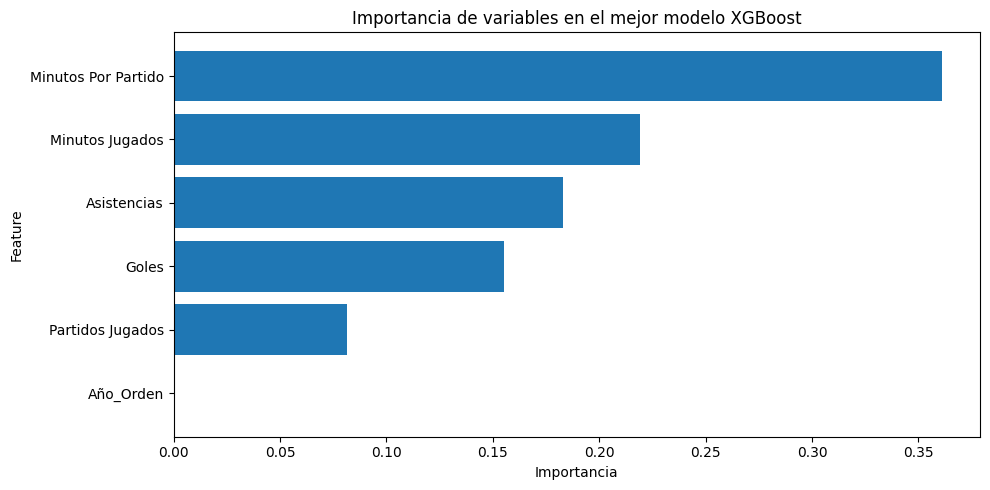

In [120]:
# Obtener los mejores hiperparámetros (primer fila del DataFrame ordenado)
mejores_params = df_resultados_grid.iloc[0][["n_estimators", "learning_rate", "max_depth"]].to_dict()

# Entrenar el modelo con los mejores hiperparámetros
mejor_modelo = XGBRegressor(
    n_estimators=int(mejores_params["n_estimators"]),
    learning_rate=mejores_params["learning_rate"],
    max_depth=int(mejores_params["max_depth"]),
    random_state=42
)
mejor_modelo.fit(X_new_train_bm, y_new_train_bm)

import matplotlib.pyplot as plt

# Obtener importancia de features
importancias = mejor_modelo.feature_importances_
nombres_features = X_new_train_bm.columns

# Crear DataFrame para visualizar
df_importancias = pd.DataFrame({
    "Feature": nombres_features,
    "Importancia": importancias
}).sort_values("Importancia", ascending=False)

# Mostrar tabla
print(df_importancias)

# Gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(df_importancias["Feature"], df_importancias["Importancia"])
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de variables en el mejor modelo XGBoost")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Blending

In [121]:
# Definición del grid de hiperparámetros
param_grid = {
    'n_estimators': [10, 20, 30, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.005, 0.05],
    'max_depth': [2, 3, 4, 5],
    'colsample_bytree': [0.5, 0.7, 1.0]
}


resultados_grid = []

for params in ParameterGrid(param_grid):
    model = XGBRegressor(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        colsample_bytree=params['colsample_bytree'],
        random_state=42,
        verbosity=0
    )
    model.fit(X_new_train, y_new_train)
    y_pred = model.predict(X_new_test)

    rmse = np.sqrt(mean_squared_error(y_new_test, y_pred))
    mae = mean_absolute_error(y_new_test, y_pred)
    r2 = r2_score(y_new_test, y_pred)
    spearman_corr, _ = spearmanr(y_new_test, y_pred)
    kendall_corr, _ = kendalltau(y_new_test, y_pred)

    resultados_grid.append({
        **params,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Spearman ρ": spearman_corr,
        "Kendall τ": kendall_corr
    })


df_resultados_grid = pd.DataFrame(resultados_grid).sort_values("MAE").reset_index(drop=True)
df_resultados_grid


colsample_bytree  learning_rate  max_depth  n_estimators      RMSE  \
0                 0.7           0.05          2           100  0.768101   
1                 1.0           0.05          2            50  0.766050   
2                 0.7           0.05          2            50  0.767000   
3                 1.0           0.10          2            50  0.768405   
4                 1.0           0.05          2           100  0.768305   
..                ...            ...        ...           ...       ...   
283               1.0           0.10          4           200  0.823834   
284               0.5           0.10          5           200  0.826106   
285               0.5           0.10          4           200  0.822451   
286               1.0           0.10          5           200  0.832454   
287               0.7           0.10          5           200  0.831402   

          MAE        R2  Spearman ρ  Kendall τ  
0    0.567778  0.091345    0.350351   0.241180  
1    0.568260  0.096190    0.348951   0.240667  
2    0.568514  0.093947    0.353871   0.242275  
3    0.568769  0.090625    0.347126   0.238610  
4    0.569274  0.090861    0.346263   0.238806  
..        ...       ...         ...        ...  
283  0.619790 -0.045303    0.212799   0.145034  
284  0.622429 -0.051078    0.200511   0.136503  
285  0.622873 -0.041796    0.212928   0.143855  
286  0.625566 -0.067292    0.185888   0.127217  
287  0.629619 -0.064596    0.188852   0.127854  

[288 rows x 9 columns]

In [122]:
# Obtener mejores hiperparámetros
mejores_params = df_resultados_grid.iloc[0][["n_estimators", "learning_rate", "max_depth"]]

# Entrenar modelo final
modelo_final = XGBRegressor(
    n_estimators=int(mejores_params["n_estimators"]),
    learning_rate=float(mejores_params["learning_rate"]),
    max_depth=int(mejores_params["max_depth"]),
    random_state=42,
    verbosity=0
)
modelo_final.fit(X_new_train, y_new_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

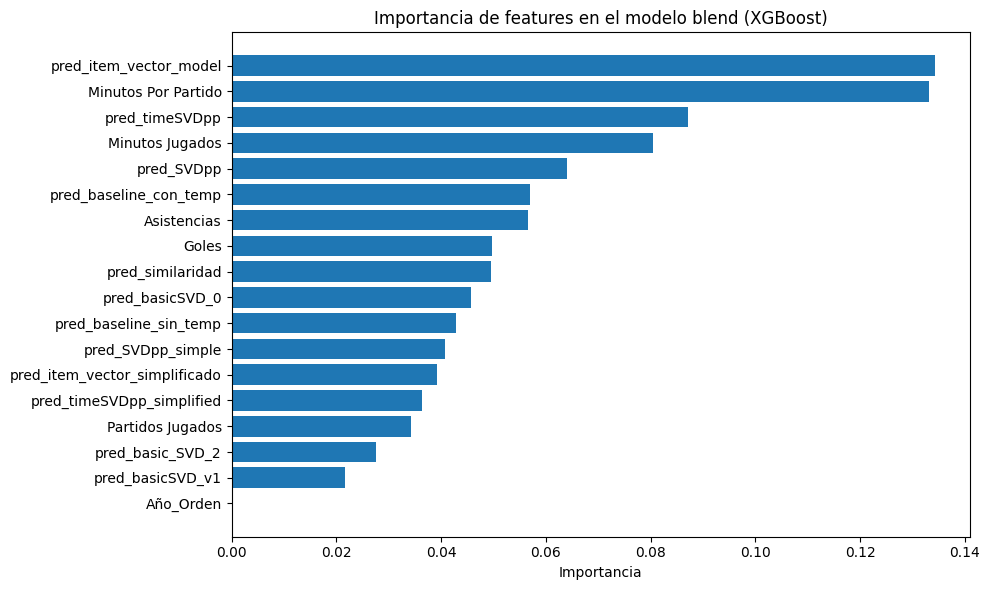

In [123]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear DataFrame de importancia
importancias = pd.DataFrame({
    "Feature": X_train.columns,
    "Importancia": modelo_final.feature_importances_
}).sort_values("Importancia", ascending=False)

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(importancias["Feature"], importancias["Importancia"])
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.title("Importancia de features en el modelo blend (XGBoost)")
plt.tight_layout()
plt.show()


# Otros métodos de blending

In [124]:
cols_solo_en_X_new_train = [col for col in X_new_train.columns if col not in X_new_train_bm.columns]
X_new_train_cf = X_new_train[cols_solo_en_X_new_train].copy()
y_new_train_cf = y_new_train.copy()

X_new_test_cf = X_new_test[cols_solo_en_X_new_train].copy()
y_new_test_cf = y_new_test.copy()

print(f"✔️ X_new_train_cf: {X_new_train_cf.shape}")

resultados_blending = []




✔️ X_new_train_cf: (2463, 12)


## Regresion

In [125]:
## BENCHMARK
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ridge Blending
ridge = Ridge(alpha=1.0)
ridge.fit(X_new_train_bm, y_new_train_bm)
y_pred_test = ridge.predict(X_new_test_bm)

print("\n[Regresión lineal (Ridge) benchmark]")
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_new_test_bm, y_pred_test)
rmse = np.sqrt(mse)
spearman_corr, _ = spearmanr(y_new_test_bm, y_pred_test)
kendall_corr, _ = kendalltau(y_new_test_bm, y_pred_test)
pmae_value = pmae(y_new_test_bm, y_pred_test)

print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_new_test_bm, y_pred_test))
print("R2:", r2_score(y_new_test_bm, y_pred_test))
print("Spearman ρ:", spearman_corr)
print("Kendall τ:", kendall_corr)
print("PMAE:", pmae_value)

resultados_blending.append({
        "Modelo": "regresión estadísticas" ,      # o hiperparámetros, etc.
        "RMSE": rmse,
        "MAE": mean_absolute_error(y_new_test_bm, y_pred_test),
        "R2": r2_score(y_new_test_bm, y_pred_test),
        "Spearman ρ": spearman_corr,
        "Kendall τ": kendall_corr,
        "PMAE": pmae_value
    })



[Regresión lineal (Ridge) benchmark]
RMSE: 0.7800064842868185
MAE: 0.5764019260562447
R2: 0.06295712426811828
Spearman ρ: 0.3167609804369624
Kendall τ: 0.22243308003492776
PMAE: 10.621482850680684


In [126]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ridge Blending
ridge = Ridge(alpha=1.0)
ridge.fit(X_new_train_cf, y_new_train_cf)
y_pred_test = ridge.predict(X_new_test_cf)

print("\n[Regresión lineal (Ridge)]")
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_new_test_cf, y_pred_test)
rmse = np.sqrt(mse)
spearman_corr, _ = spearmanr(y_new_test_cf, y_pred_test)
kendall_corr, _ = kendalltau(y_new_test_cf, y_pred_test)
pmae_value = pmae(y_new_test_cf, y_pred_test)

print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_new_test_cf, y_pred_test))
print("R2:", r2_score(y_new_test_cf, y_pred_test))
print("Spearman ρ:", spearman_corr)
print("Kendall τ:", kendall_corr)
print("PMAE:", pmae_value)

resultados_blending.append({
        "Modelo": "regresión predictores" ,      # o hiperparámetros, etc.
        "RMSE": rmse,
        "MAE": mean_absolute_error(y_new_test_cf, y_pred_test),
        "R2": r2_score(y_new_test_cf, y_pred_test),
        "Spearman ρ": spearman_corr,
        "Kendall τ": kendall_corr,
        "PMAE": pmae_value
    })



[Regresión lineal (Ridge)]
RMSE: 0.7912687813622679
MAE: 0.5990051098199674
R2: 0.03570236879026967
Spearman ρ: 0.19619826093697007
Kendall τ: 0.13391034065906487
PMAE: 10.978435435034758


In [127]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ridge Blending
ridge = Ridge(alpha=1.0)
ridge.fit(X_new_train, y_new_train)
y_pred_test = ridge.predict(X_new_test)

print("\n[Regresión lineal (Ridge)]")
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_new_test, y_pred_test)
rmse = np.sqrt(mse)
spearman_corr, _ = spearmanr(y_new_test, y_pred_test)
kendall_corr, _ = kendalltau(y_new_test, y_pred_test)
pmae_value = pmae(y_new_test, y_pred_test)

print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_new_test, y_pred_test))
print("R2:", r2_score(y_new_test, y_pred_test))
print("Spearman ρ:", spearman_corr)
print("Kendall τ:", kendall_corr)
print("PMAE:", pmae_value)

resultados_blending.append({
        "Modelo": "regresión combinado" ,      # o hiperparámetros, etc.
        "RMSE": rmse,
        "MAE": mean_absolute_error(y_new_test, y_pred_test),
        "R2": r2_score(y_new_test, y_pred_test),
        "Spearman ρ": spearman_corr,
        "Kendall τ": kendall_corr,
        "PMAE": pmae_value
    })



[Regresión lineal (Ridge)]
RMSE: 0.7684573185368802
MAE: 0.5681694515193435
R2: 0.09050034413440433
Spearman ρ: 0.340090164633119
Kendall τ: 0.23547991037508045
PMAE: 10.437800395827662


## Light GBM

In [128]:
#BENCHMARK
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
param_grid_lgb = {
    'max_depth': [3, 5, 7],
    'n_estimators': [20, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [7, 15, 31]
}
gs_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
gs_lgb.fit(X_new_train_bm, y_new_train_bm)
y_pred_lgb = gs_lgb.predict(X_new_test_bm)

print("\n[LightGBM - Mejor combinación]", gs_lgb.best_params_)
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_new_test_bm, y_pred_lgb)
rmse = np.sqrt(mse)
spearman_corr, _ = spearmanr(y_new_test_bm, y_pred_lgb)
kendall_corr, _ = kendalltau(y_new_test_bm, y_pred_lgb)
pmae_value = pmae(y_new_test_bm, y_pred_lgb)

print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_new_test_bm, y_pred_lgb))
print("R2:", r2_score(y_new_test_bm, y_pred_lgb))
print("Spearman ρ:", spearman_corr)
print("Kendall τ:", kendall_corr)
print("PMAE:", pmae_value)

resultados_blending.append({
        "Modelo": "LightGBM estadísticas" ,      # o hiperparámetros, etc.
        "RMSE": rmse,
        "MAE": mean_absolute_error(y_new_test_bm, y_pred_lgb),
        "R2": r2_score(y_new_test_bm, y_pred_lgb),
        "Spearman ρ": spearman_corr,
        "Kendall τ": kendall_corr,
        "PMAE": pmae_value
    })


Se truncaron las últimas líneas 5000 del resultado de transmisión.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [129]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
param_grid_lgb = {
    'max_depth': [3, 5, 7],
    'n_estimators': [20, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [7, 15, 31]
}
gs_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
gs_lgb.fit(X_new_train_cf, y_new_train_cf)
y_pred_lgb = gs_lgb.predict(X_new_test_cf)

print("\n[LightGBM - Mejor combinación]", gs_lgb.best_params_)
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_new_test_cf, y_pred_lgb)
rmse = np.sqrt(mse)
spearman_corr, _ = spearmanr(y_new_test_cf, y_pred_lgb)
kendall_corr, _ = kendalltau(y_new_test_cf, y_pred_lgb)
pmae_value = pmae(y_new_test_cf, y_pred_lgb)


print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_new_test_cf, y_pred_lgb))
print("R2:", r2_score(y_new_test_cf, y_pred_lgb))
print("Spearman ρ:", spearman_corr)
print("Kendall τ:", kendall_corr)
print("PMAE:", pmae_value)

resultados_blending.append({
        "Modelo": "LightGBM predictores" ,      # o hiperparámetros, etc.
        "RMSE": rmse,
        "MAE": mean_absolute_error(y_new_test_cf, y_pred_lgb),
        "R2": r2_score(y_new_test_cf, y_pred_lgb),
        "Spearman ρ": spearman_corr,
        "Kendall τ": kendall_corr,
        "PMAE": pmae_value
    })


Se truncaron las últimas líneas 5000 del resultado de transmisión.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [130]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
param_grid_lgb = {
    'max_depth': [3, 5, 7],
    'n_estimators': [20, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [7, 15, 31]
}
gs_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
gs_lgb.fit(X_new_train, y_new_train)
y_pred_lgb = gs_lgb.predict(X_new_test)

print("\n[LightGBM - Mejor combinación]", gs_lgb.best_params_)
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_new_test, y_pred_lgb)
rmse = np.sqrt(mse)
spearman_corr, _ = spearmanr(y_new_test, y_pred_lgb)
kendall_corr, _ = kendalltau(y_new_test, y_pred_lgb)
pmae_value = pmae(y_new_test, y_pred_lgb)


print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_new_test, y_pred_lgb))
print("R2:", r2_score(y_new_test, y_pred_lgb))
print("Spearman ρ:", spearman_corr)
print("Kendall τ:", kendall_corr)
print("PMAE:", pmae_value)

resultados_blending.append({
        "Modelo": "LightGBM combinado" ,      # o hiperparámetros, etc.
        "RMSE": rmse,
        "MAE": mean_absolute_error(y_new_test, y_pred_lgb),
        "R2": r2_score(y_new_test, y_pred_lgb),
        "Spearman ρ": spearman_corr,
        "Kendall τ": kendall_corr,
        "PMAE": pmae_value
    })

Se truncaron las últimas líneas 5000 del resultado de transmisión.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

## Stacking

In [131]:
#Benchmark
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

# Base learners
estimators = [
    ('ridge', Ridge(alpha=1.0)),
    ('xgb', xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1, random_state=42, max_depth=5, n_estimators=50, learning_rate=0.1)),
    ('lgb', lgb.LGBMRegressor(random_state=42, n_jobs=-1, max_depth=5, n_estimators=50, learning_rate=0.1, num_leaves=7))
]
# Meta-model
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    n_jobs=-1
)
stack.fit(X_new_train_bm, y_new_train_bm)
y_pred_stack = stack.predict(X_new_test_bm)

print("\n[StackingRegressor] benchmark")
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_new_test_bm, y_pred_stack)
rmse = np.sqrt(mse)
spearman_corr, _ = spearmanr(y_new_test_bm, y_pred_stack)
kendall_corr, _ = kendalltau(y_new_test_bm, y_pred_stack)
pmae_value = pmae(y_new_test_bm, y_pred_stack)


print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_new_test_bm, y_pred_stack))
print("R2:", r2_score(y_new_test_bm, y_pred_stack))
print("Spearman ρ:", spearman_corr)
print("Kendall τ:", kendall_corr)
print("PMAE:", pmae_value)

resultados_blending.append({
        "Modelo": "Stacking estadísticas" ,      # o hiperparámetros, etc.
        "RMSE": rmse,
        "MAE": mean_absolute_error(y_new_test_bm, y_pred_stack),
        "R2": r2_score(y_new_test_bm, y_pred_stack),
        "Spearman ρ": spearman_corr,
        "Kendall τ": kendall_corr,
        "PMAE": pmae_value
    })



[StackingRegressor] benchmark
RMSE: 0.7802802215442909
MAE: 0.5763693955395518
R2: 0.062299312926609285
Spearman ρ: 0.31855901680948717
Kendall τ: 0.22252870219443266
PMAE: 10.628904184462737


In [132]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

# Base learners
estimators = [
    ('ridge', Ridge(alpha=1.0)),
    ('xgb', xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1, random_state=42, max_depth=5, n_estimators=50, learning_rate=0.1)),
    ('lgb', lgb.LGBMRegressor(random_state=42, n_jobs=-1, max_depth=5, n_estimators=50, learning_rate=0.1, num_leaves=7))
]
# Meta-model
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    n_jobs=-1
)
stack.fit(X_new_train_cf, y_new_train_cf)
y_pred_stack = stack.predict(X_new_test_cf)

print("\n[StackingRegressor]")
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_new_test_cf, y_pred_stack)
rmse = np.sqrt(mse)
spearman_corr, _ = spearmanr(y_new_test_cf, y_pred_stack)
kendall_corr, _ = kendalltau(y_new_test_cf, y_pred_stack)
pmae_value = pmae(y_new_test_cf, y_pred_stack)


print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_new_test_cf, y_pred_stack))
print("R2:", r2_score(y_new_test_cf, y_pred_stack))
print("Spearman ρ:", spearman_corr)
print("Kendall τ:", kendall_corr)
print("PMAE:", pmae_value)

resultados_blending.append({
        "Modelo": "Stacking predictores" ,      # o hiperparámetros, etc.
        "RMSE": rmse,
        "MAE": mean_absolute_error(y_new_test_cf, y_pred_stack),
        "R2": r2_score(y_new_test_cf, y_pred_stack),
        "Spearman ρ": spearman_corr,
        "Kendall τ": kendall_corr,
        "PMAE": pmae_value
    })



[StackingRegressor]
RMSE: 0.7921628758937765
MAE: 0.6006898094117548
R2: 0.033521920463079224
Spearman ρ: 0.1947013480130506
Kendall τ: 0.13208293835873489
PMAE: 10.996315670217223


In [133]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

# Base learners
estimators = [
    ('ridge', Ridge(alpha=1.0)),
    ('xgb', xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1, random_state=42, max_depth=5, n_estimators=50, learning_rate=0.1)),
    ('lgb', lgb.LGBMRegressor(random_state=42, n_jobs=-1, max_depth=5, n_estimators=50, learning_rate=0.1, num_leaves=7))
]
# Meta-model
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    n_jobs=-1
)
stack.fit(X_new_train, y_new_train)
y_pred_stack = stack.predict(X_new_test)

print("\n[StackingRegressor]")
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_new_test, y_pred_stack)
rmse = np.sqrt(mse)
spearman_corr, _ = spearmanr(y_new_test, y_pred_stack)
kendall_corr, _ = kendalltau(y_new_test, y_pred_stack)
pmae_value = pmae(y_new_test, y_pred_stack)


print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_new_test, y_pred_stack))
print("R2:", r2_score(y_new_test, y_pred_stack))
print("Spearman ρ:", spearman_corr)
print("Kendall τ:", kendall_corr)
print("PMAE:", pmae_value)

resultados_blending.append({
        "Modelo": "Stacking combinado" ,      # o hiperparámetros, etc.
        "RMSE": rmse,
        "MAE": mean_absolute_error(y_new_test, y_pred_stack),
        "R2": r2_score(y_new_test, y_pred_stack),
        "Spearman ρ": spearman_corr,
        "Kendall τ": kendall_corr,
        "PMAE": pmae_value
    })



[StackingRegressor]
RMSE: 0.7690807586264088
MAE: 0.5693797595382252
R2: 0.08902401346300304
Spearman ρ: 0.3327255461113599
Kendall τ: 0.22989145915430387
PMAE: 10.446999897774921


In [134]:
print(resultados_blending)

[{'Modelo': 'regresión estadísticas', 'RMSE': np.float64(0.7800064842868185), 'MAE': 0.5764019260562447, 'R2': 0.06295712426811828, 'Spearman ρ': np.float64(0.3167609804369624), 'Kendall τ': np.float64(0.22243308003492776), 'PMAE': np.float64(10.621482850680684)}, {'Modelo': 'regresión predictores', 'RMSE': np.float64(0.7912687813622679), 'MAE': 0.5990051098199674, 'R2': 0.03570236879026967, 'Spearman ρ': np.float64(0.19619826093697007), 'Kendall τ': np.float64(0.13391034065906487), 'PMAE': np.float64(10.978435435034758)}, {'Modelo': 'regresión combinado', 'RMSE': np.float64(0.7684573185368802), 'MAE': 0.5681694515193435, 'R2': 0.09050034413440433, 'Spearman ρ': np.float64(0.340090164633119), 'Kendall τ': np.float64(0.23547991037508045), 'PMAE': np.float64(10.437800395827662)}, {'Modelo': 'LightGBM estadísticas', 'RMSE': np.float64(0.7864419423434543), 'MAE': 0.580744799337891, 'R2': 0.04743115929760988, 'Spearman ρ': np.float64(0.30884347461255623), 'Kendall τ': np.float64(0.214123829

# Gráficos

In [136]:
df_metricas = pd.DataFrame(resultados_metricas)
df_blending = pd.DataFrame(resultados_blending)




In [195]:
df_metricas["PMAE"].iloc[16] = df_metricas["pMAE"].iloc[16]

<ipython-input-195-e655e40b679a>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_metricas["PMAE"].iloc[16] = df_metricas["pMAE"].iloc[16]
<ipython-input-195-e655e40b679a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [196]:
df_metricas = df_metricas[df_metricas["Modelo"] != "sampling"].drop(columns="pMAE")


In [200]:
print(df_metricas)

                    Modelo      RMSE       MAE        R2  Spearman   Kendall  \
0               basicSVD_0  1.709774  1.518335 -3.149513  0.161124  0.109930   
1              basicSVD_v1  0.836865  0.632483  0.005900  0.082014  0.055301   
2                    media  0.839597  0.635026 -0.000602       NaN       NaN   
4                  XGBoost  0.823371  0.617896  0.037699  0.304080  0.211566   
5                  XGBoost  0.816501  0.609862  0.053691  0.308861  0.214811   
6                  XGBoost  0.812973  0.603968  0.061852  0.309477  0.215548   
7             Media Equipo  0.845064  0.643694 -0.013676  0.123407  0.083279   
8            Media Jugador  0.924820  0.686428 -0.214042  0.169351  0.115672   
9        Baseline_sin_temp  0.836907  0.632499  0.005800  0.143740  0.097809   
10       Baseline_con_temp  0.835056  0.632225  0.010193  0.117889  0.079834   
11  Baseline_con_temp_bins  0.838307  0.634034  0.002470  0.117121  0.079514   
12      baseline_timeSVD++  0.839069  0.

In [144]:
print(df_blending)

                   Modelo      RMSE       MAE        R2  Spearman ρ  \
0  regresión estadísticas  0.780006  0.576402  0.062957    0.316761   
1   regresión predictores  0.791269  0.599005  0.035702    0.196198   
2     regresión combinado  0.768457  0.568169  0.090500    0.340090   
3   LightGBM estadísticas  0.786442  0.580745  0.047431    0.308843   
4    LightGBM predictores  0.787701  0.597008  0.044379    0.225035   
5      LightGBM combinado  0.778997  0.576167  0.065382    0.327132   
6   Stacking estadísticas  0.780280  0.576369  0.062299    0.318559   
7    Stacking predictores  0.792163  0.600690  0.033522    0.194701   
8      Stacking combinado  0.769081  0.569380  0.089024    0.332726   

   Kendall τ      PMAE  
0   0.222433  0.106215  
1   0.133910  0.109784  
2   0.235480  0.104378  
3   0.214124  0.107128  
4   0.153152  0.109386  
5   0.225695  0.105722  
6   0.222529  0.106289  
7   0.132083  0.109963  
8   0.229891  0.104470  


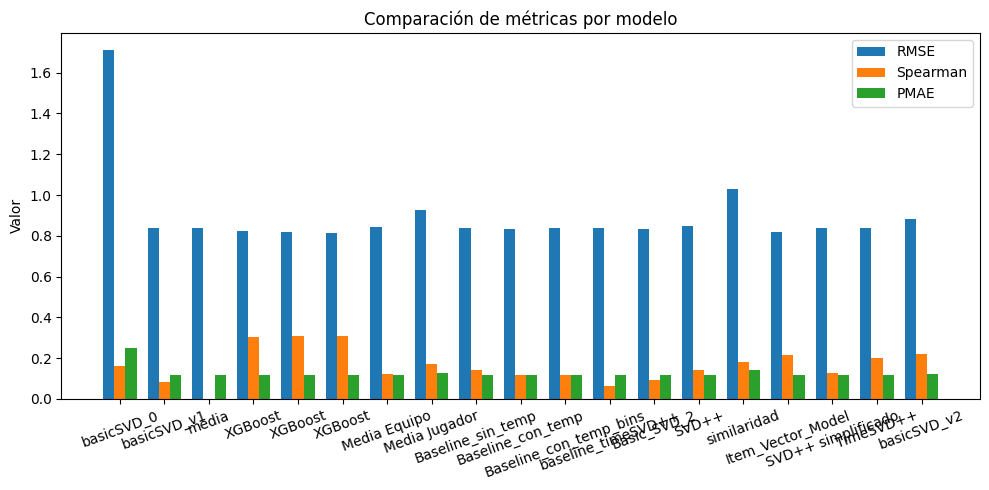

In [201]:
import matplotlib.pyplot as plt
import numpy as np

df_metricas["PMAE"] = df_metricas["PMAE"] / 100


# Elegimos las métricas a graficar
metrics = ["RMSE", "Spearman", "PMAE"]


# Posiciones y ancho de barras
x = np.arange(len(df_metricas["Modelo"]))  # posiciones para cada modelo
width = 0.25  # ancho de cada barra

fig, ax = plt.subplots(figsize=(10, 5))

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, df_metricas[metric], width, label=metric)

ax.set_xticks(x + width)
ax.set_xticklabels(df_metricas["Modelo"], rotation=20)
ax.set_ylabel("Valor")
ax.set_title("Comparación de métricas por modelo")
ax.legend()
plt.tight_layout()
plt.show()


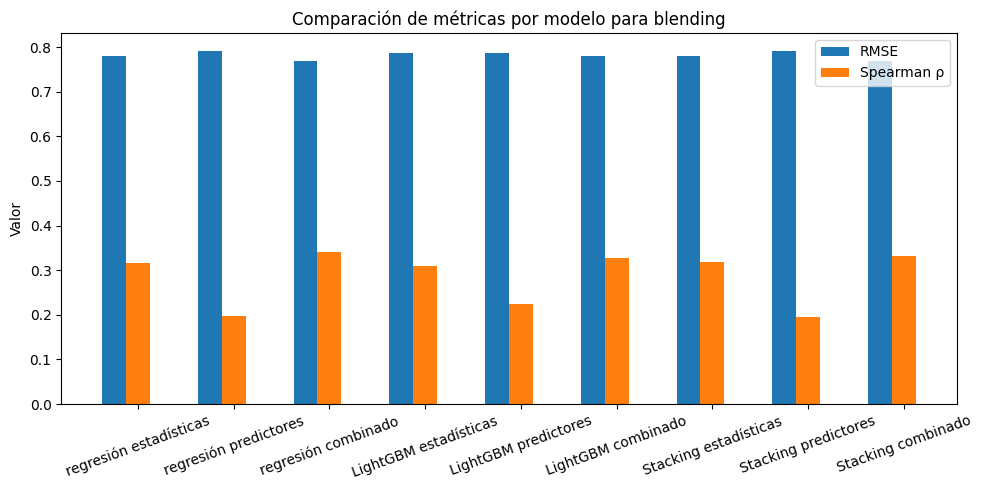

In [142]:
import matplotlib.pyplot as plt
import numpy as np

# Elegimos las métricas a graficar
df_blending["PMAE"] = df_blending["PMAE"] / 100

metrics = ["RMSE", "Spearman ρ"]

# Posiciones y ancho de barras
x = np.arange(len(df_blending["Modelo"]))  # posiciones para cada modelo
width = 0.25  # ancho de cada barra

fig, ax = plt.subplots(figsize=(10, 5))

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, df_blending[metric], width, label=metric)

ax.set_xticks(x + width)
ax.set_xticklabels(df_blending["Modelo"], rotation=20)
ax.set_ylabel("Valor")
ax.set_title("Comparación de métricas por modelo para blending")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["tab:blue", "tab:orange", "tab:green"]
for i, metric in enumerate(metrics):
    ax.stem(x + i*0.1, df_blending[metric], linefmt=colors[i]+"-", markerfmt=colors[i]+"o", basefmt=" ", label=metric)

ax.set_xticks(x + width)
ax.set_xticklabels(df_blending["Modelo"], rotation=20)
ax.set_ylabel("Valor")
ax.set_title("Comparación de métricas (chupetines) para blending")
ax.legend()
plt.tight_layout()
plt.show()


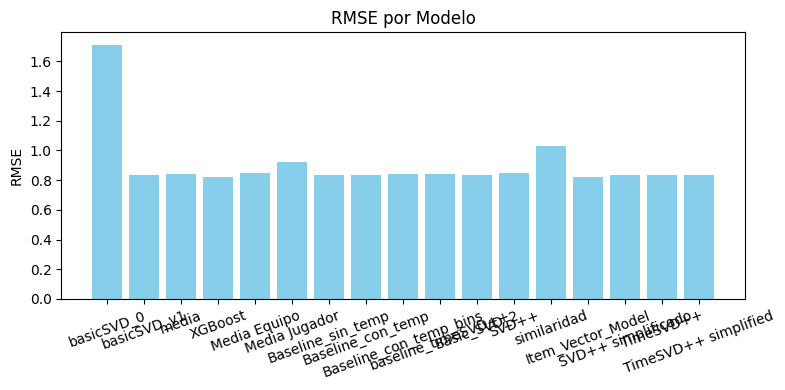

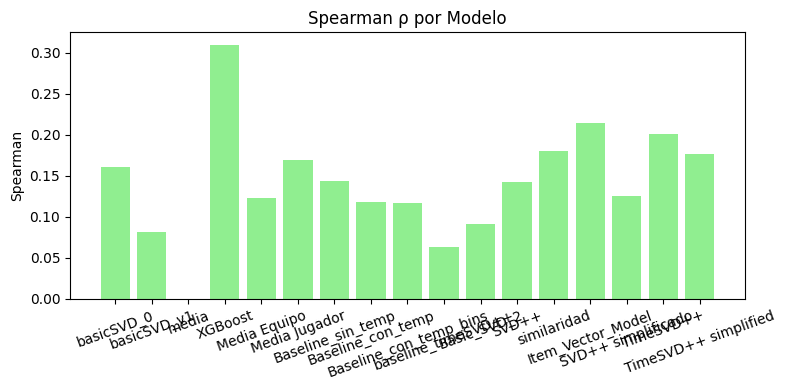

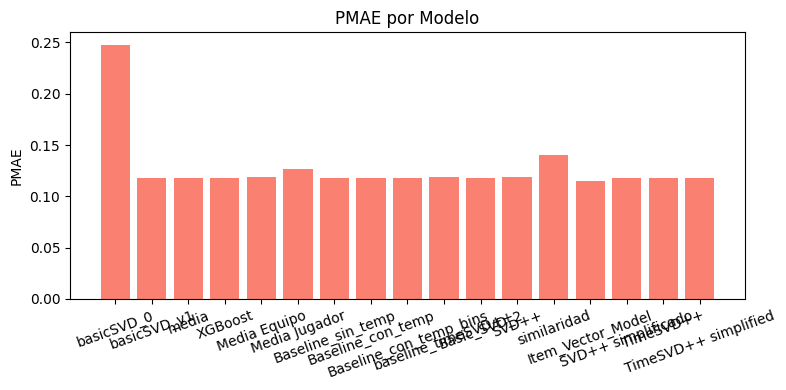

In [145]:
import matplotlib.pyplot as plt

# PMAE en decimal
# 1. Gráfico de barras para RMSE
plt.figure(figsize=(8, 4))
plt.bar(df_metricas["Modelo"], df_metricas["RMSE"], color="skyblue")
plt.ylabel("RMSE")
plt.title("RMSE por Modelo")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# 2. Gráfico de barras para Spearman ρ
plt.figure(figsize=(8, 4))
plt.bar(df_metricas["Modelo"], df_metricas["Spearman"], color="lightgreen")
plt.ylabel("Spearman")
plt.title("Spearman ρ por Modelo")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# 3. Gráfico de barras para PMAE (en decimal)
plt.figure(figsize=(8, 4))
plt.bar(df_metricas["Modelo"], df_metricas["PMAE"], color="salmon")
plt.ylabel("PMAE")
plt.title("PMAE por Modelo")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


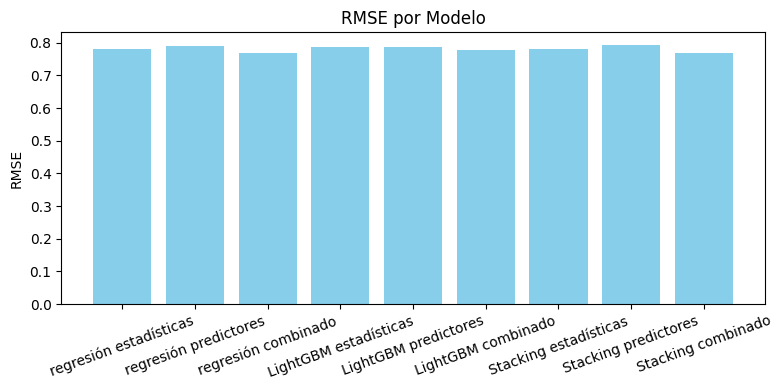

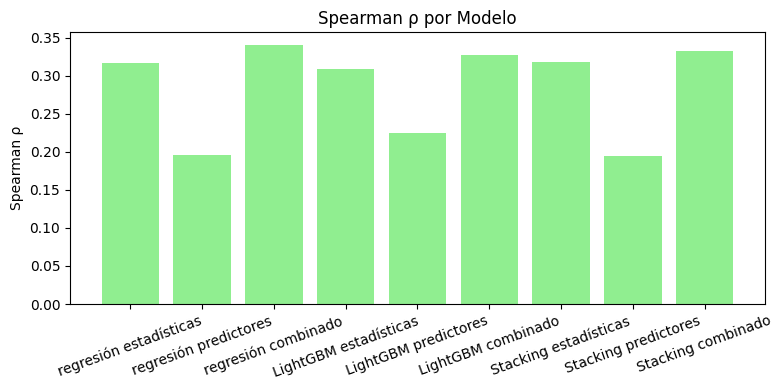

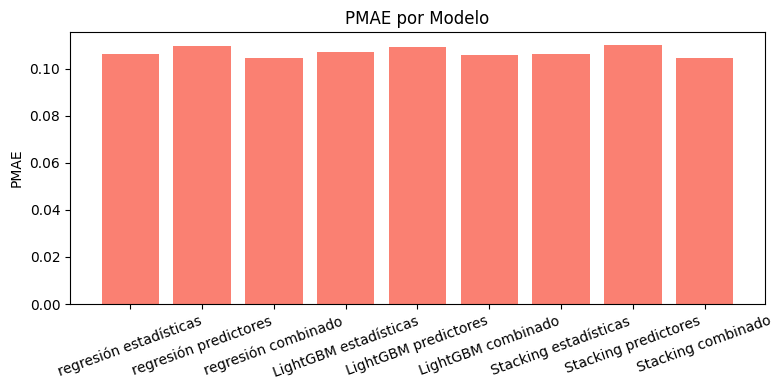

In [146]:
import matplotlib.pyplot as plt

# PMAE en decimal
# 1. Gráfico de barras para RMSE
plt.figure(figsize=(8, 4))
plt.bar(df_blending["Modelo"], df_blending["RMSE"], color="skyblue")
plt.ylabel("RMSE")
plt.title("RMSE por Modelo")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# 2. Gráfico de barras para Spearman ρ
plt.figure(figsize=(8, 4))
plt.bar(df_blending["Modelo"], df_blending["Spearman ρ"], color="lightgreen")
plt.ylabel("Spearman ρ")
plt.title("Spearman ρ por Modelo")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# 3. Gráfico de barras para PMAE (en decimal)
plt.figure(figsize=(8, 4))
plt.bar(df_blending["Modelo"], df_blending["PMAE"], color="salmon")
plt.ylabel("PMAE")
plt.title("PMAE por Modelo")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


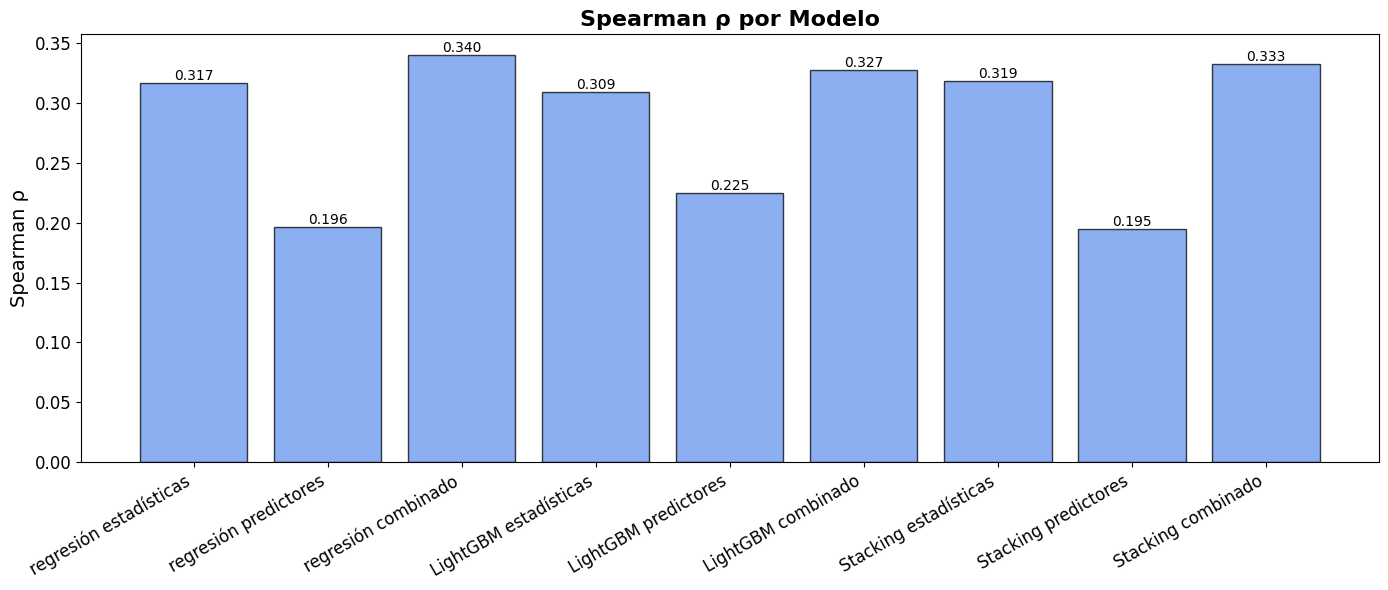

In [167]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))  # Aumenta el ancho para que entren mejor

bars = plt.bar(
    df_blending["Modelo"],
    df_blending["Spearman ρ"],
    color="cornflowerblue",
    alpha=0.75,
    edgecolor="k"
)

plt.ylabel("Spearman ρ", fontsize=14)
plt.title("Spearman ρ por Modelo", fontsize=16, weight="bold")
plt.xticks(rotation=30, ha="right", fontsize=12)  # Rotación más leve y fuente más grande
plt.yticks(fontsize=12)

# Espaciado en el eje x para que no queden tan juntas
plt.subplots_adjust(bottom=0.25)

# Opcional: mostrar el valor arriba de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height ,
        f"{height:.3f}",
        ha="center", va="bottom", fontsize=10
    )

plt.tight_layout()
plt.show()


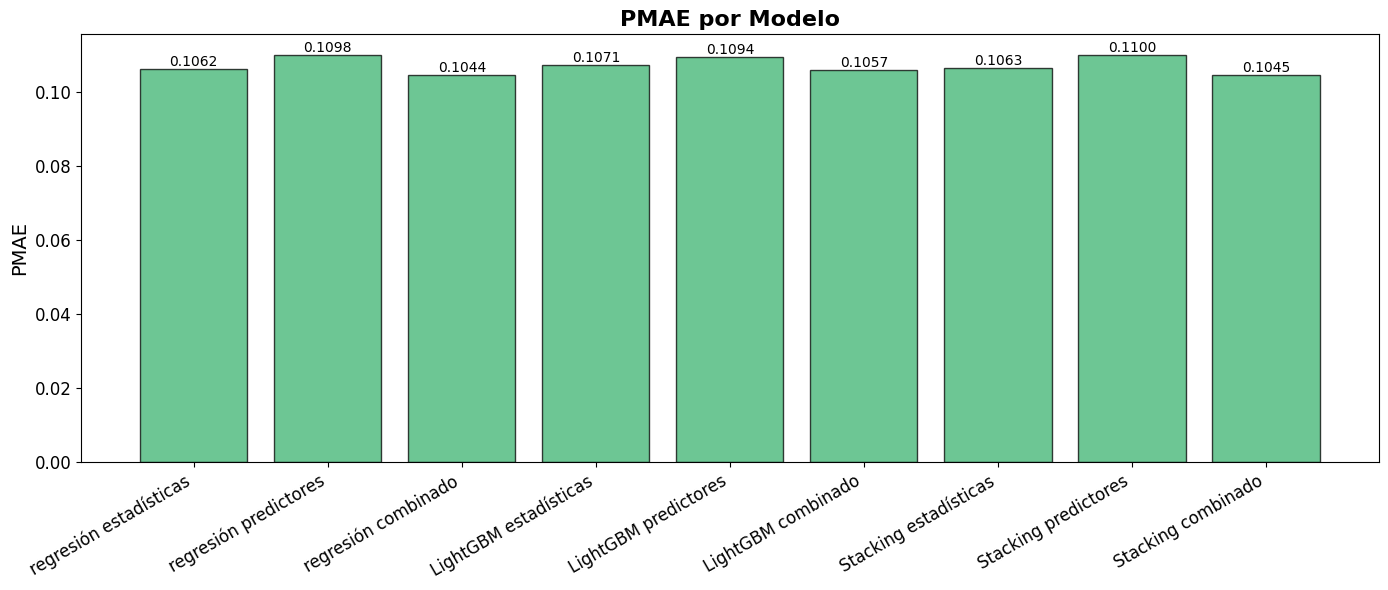

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))  # Aumenta el ancho para que entren mejor

bars = plt.bar(
    df_blending["Modelo"],
    df_blending["PMAE"],
    color="mediumseagreen",
    alpha=0.75,
    edgecolor="k"
)

plt.ylabel("PMAE", fontsize=14)
plt.title("PMAE por Modelo", fontsize=16, weight="bold")
plt.xticks(rotation=30, ha="right", fontsize=12)  # Rotación más leve y fuente más grande
plt.yticks(fontsize=12)

# Espaciado en el eje x para que no queden tan juntas
plt.subplots_adjust(bottom=0.25)

# Opcional: mostrar el valor arriba de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height ,
        f"{height:.4f}",
        ha="center", va="bottom", fontsize=10
    )

plt.tight_layout()
plt.show()


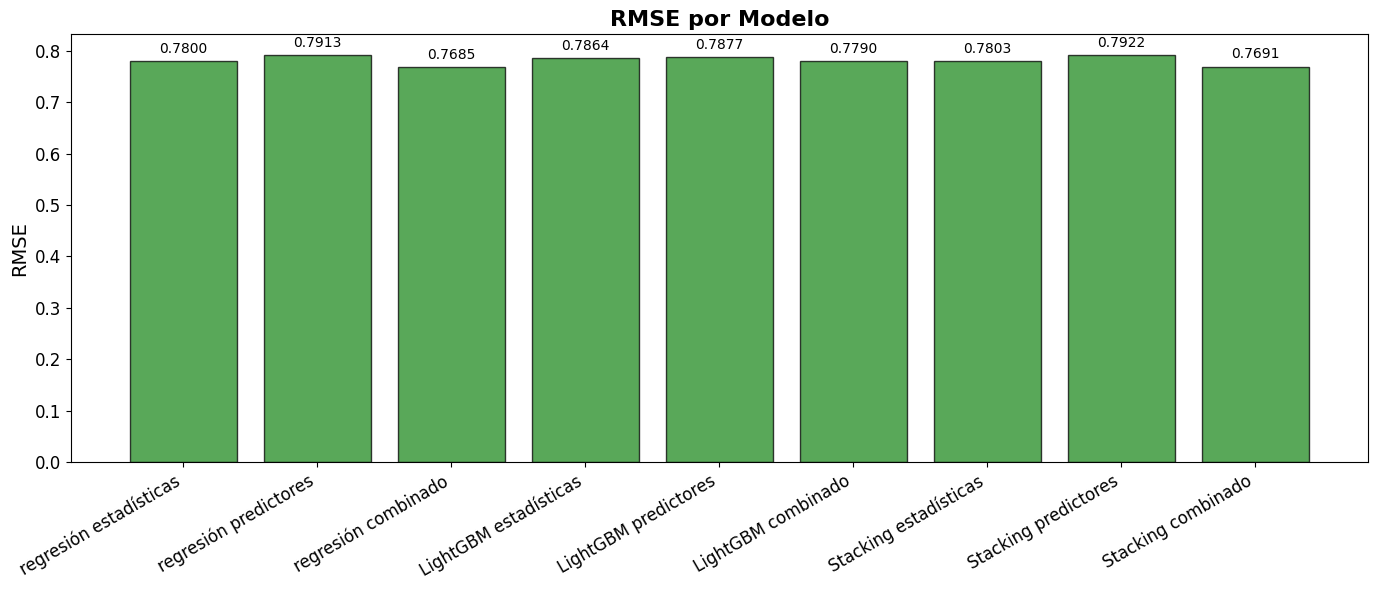

In [166]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))  # Aumenta el ancho para que entren mejor

bars = plt.bar(
    df_blending["Modelo"],
    df_blending["RMSE"],
    color="forestgreen",
    alpha=0.75,
    edgecolor="k"
)

plt.ylabel("RMSE", fontsize=14)
plt.title("RMSE por Modelo", fontsize=16, weight="bold")
plt.xticks(rotation=30, ha="right", fontsize=12)  # Rotación más leve y fuente más grande
plt.yticks(fontsize=12)

# Espaciado en el eje x para que no queden tan juntas
plt.subplots_adjust(bottom=0.25)

# Opcional: mostrar el valor arriba de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height + 0.01,
        f"{height:.4f}",
        ha="center", va="bottom", fontsize=10
    )

plt.tight_layout()
plt.show()


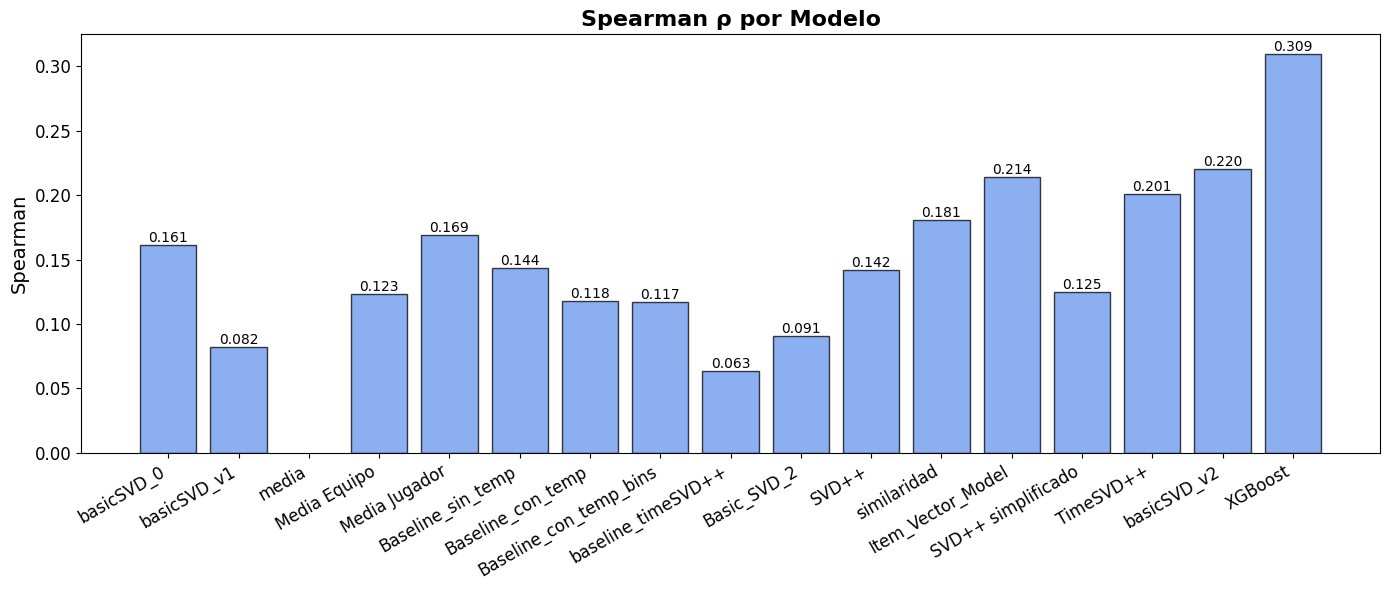

In [202]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))  # Aumenta el ancho para que entren mejor

# Supongamos que df_blending es tu DataFrame

# Filtrar las filas que NO son XGBoost
df_sin_xgboost = df_metricas[df_metricas["Modelo"] != "XGBoost"]

# Filtrar las filas que SÍ son XGBoost
xgboost_rows = df_metricas[df_metricas["Modelo"] == "XGBoost"]

# Seleccionar la fila de XGBoost con mayor Spearman ρ
mejor_xgboost = xgboost_rows.loc[xgboost_rows["Spearman"].idxmax()]

# Concatenar el DataFrame final (sin duplicados de XGBoost)
df_metricas = pd.concat([df_sin_xgboost, mejor_xgboost.to_frame().T], ignore_index=True)


bars = plt.bar(
    df_metricas["Modelo"],
    df_metricas["Spearman"],
    color="cornflowerblue",
    alpha=0.75,
    edgecolor="k"
)

plt.ylabel("Spearman", fontsize=14)
plt.title("Spearman ρ por Modelo", fontsize=16, weight="bold")
plt.xticks(rotation=30, ha="right", fontsize=12)  # Rotación más leve y fuente más grande
plt.yticks(fontsize=12)

# Espaciado en el eje x para que no queden tan juntas
plt.subplots_adjust(bottom=0.25)

# Opcional: mostrar el valor arriba de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height ,
        f"{height:.3f}",
        ha="center", va="bottom", fontsize=10
    )

plt.tight_layout()
plt.show()


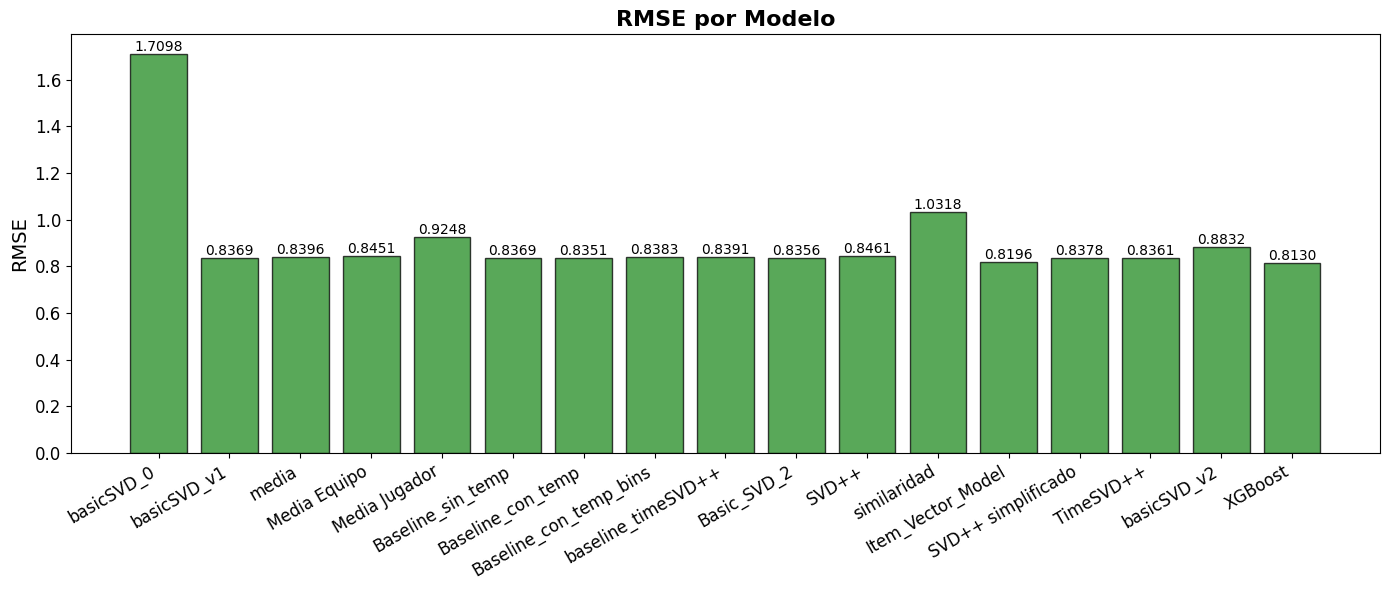

In [205]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))  # Aumenta el ancho para que entren mejor

# Supongamos que df_blending es tu DataFrame

# Filtrar las filas que NO son XGBoost
df_sin_xgboost = df_metricas[df_metricas["Modelo"] != "XGBoost"]

# Filtrar las filas que SÍ son XGBoost
xgboost_rows = df_metricas[df_metricas["Modelo"] == "XGBoost"]

# Seleccionar la fila de XGBoost con mayor Spearman ρ
mejor_xgboost = xgboost_rows.loc[xgboost_rows["RMSE"].idxmax()]

# Concatenar el DataFrame final (sin duplicados de XGBoost)
df_metricas = pd.concat([df_sin_xgboost, mejor_xgboost.to_frame().T], ignore_index=True)


bars = plt.bar(
    df_metricas["Modelo"],
    df_metricas["RMSE"],
    color="forestgreen",
    alpha=0.75,
    edgecolor="k"
)

plt.ylabel("RMSE", fontsize=14)
plt.title("RMSE por Modelo", fontsize=16, weight="bold")
plt.xticks(rotation=30, ha="right", fontsize=12)  # Rotación más leve y fuente más grande
plt.yticks(fontsize=12)

# Espaciado en el eje x para que no queden tan juntas
plt.subplots_adjust(bottom=0.25)

# Opcional: mostrar el valor arriba de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height,
        f"{height:.4f}",
        ha="center", va="bottom", fontsize=10
    )

plt.tight_layout()
plt.show()


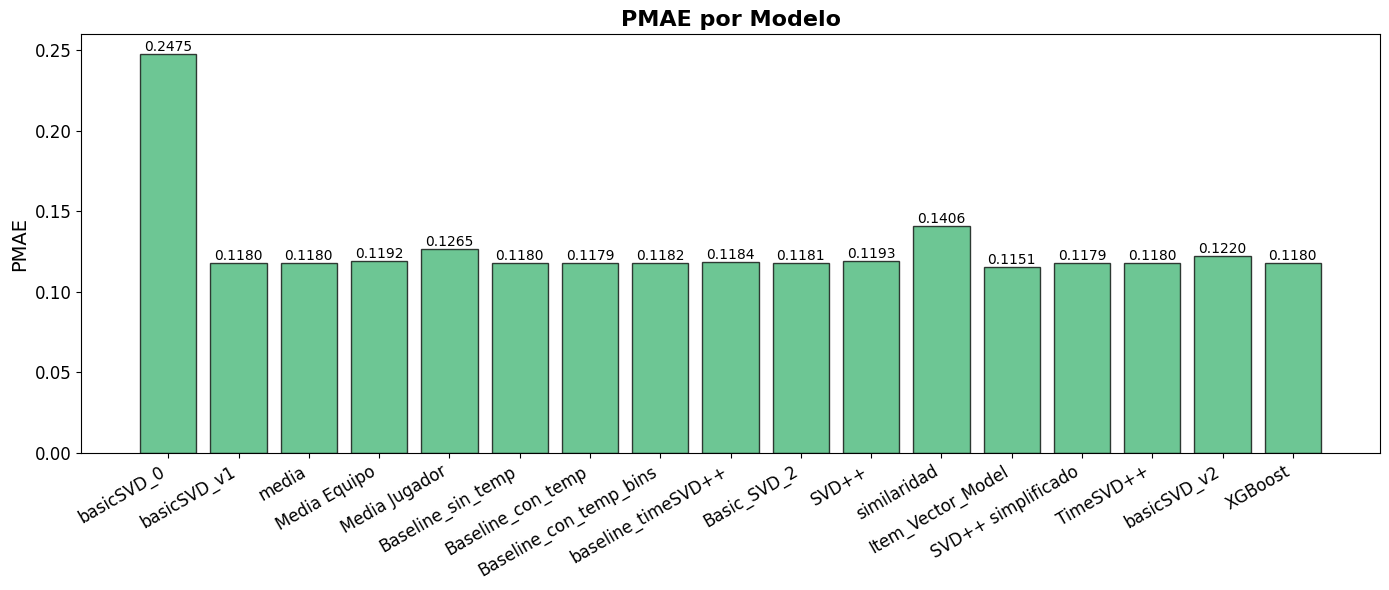

In [204]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))  # Aumenta el ancho para que entren mejor

# Supongamos que df_blending es tu DataFrame

# Filtrar las filas que NO son XGBoost
df_sin_xgboost = df_metricas[df_metricas["Modelo"] != "XGBoost"]

# Filtrar las filas que SÍ son XGBoost
xgboost_rows = df_metricas[df_metricas["Modelo"] == "XGBoost"]

# Seleccionar la fila de XGBoost con mayor Spearman ρ
mejor_xgboost = xgboost_rows.loc[xgboost_rows["PMAE"].idxmax()]

# Concatenar el DataFrame final (sin duplicados de XGBoost)
df_metricas = pd.concat([df_sin_xgboost, mejor_xgboost.to_frame().T], ignore_index=True)


bars = plt.bar(
    df_metricas["Modelo"],
    df_metricas["PMAE"],
    color="mediumseagreen",
    alpha=0.75,
    edgecolor="k"
)

plt.ylabel("PMAE", fontsize=14)
plt.title("PMAE por Modelo", fontsize=16, weight="bold")
plt.xticks(rotation=30, ha="right", fontsize=12)  # Rotación más leve y fuente más grande
plt.yticks(fontsize=12)

# Espaciado en el eje x para que no queden tan juntas
plt.subplots_adjust(bottom=0.25)

# Opcional: mostrar el valor arriba de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height,
        f"{height:.4f}",
        ha="center", va="bottom", fontsize=10
    )

plt.tight_layout()
plt.show()
